In [136]:
import numpy as np
from pathlib import Path
from utils import project_root
from scipy.spatial.transform import Rotation
import os
import pymap3d as pm
from random import randrange
import matplotlib.pyplot as plt
from matplotlib import pyplot
import probscale
import time
import copy
import warnings
import matplotlib
import pandas as pd
import scipy
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import random

%matplotlib notebook
matplotlib.style.use('ggplot')
random.seed(0)
np.random.seed(0)
plt.rcParams["figure.figsize"] = (10,10)

# Globals

In [137]:
# GLOBAL VARIABLES
# IMU rotational offset
imu_rot_off = [0, 0, 1.5708]
# rotation from base_link to IMU
R_b2i = Rotation.from_euler('z', 1.5708, degrees=False).as_matrix()
# GPS translational offset
x_off = -0.01
y_off = 0
z_off = 2.13
gps_off = np.array([x_off, y_off, z_off]).reshape((3,1))
# radar translational offset
radar_off = np.array([0.915, 0, 0.895]).reshape((3,1))
# gravity
GRAV = 9.80665

# define covariances
# GPS position_covariance:
gps_pos_cov = [[0.019599999999999996, 0, 0],
               [0, 0.019599999999999996, 0],
               [0, 0, 0.31359999999999993]]
# IMU covariances (noise) from /ouster/imu topic
lin_acc_cov = [[0.01, 0, 0],
              [0, 0.01, 0],
              [0, 0, 0.01]]
ang_vel_cov = [[0.0006, 0, 0],
              [0, 0.0006, 0],
              [0, 0, 0.0006]]
# extract variances and std. deviations
var_p = 0.019599999999999996
sigma_p = np.sqrt(var_p)
var_a = 0.01
sigma_a = np.sqrt(var_a)
var_w = 0.0006
sigma_w = np.sqrt(var_w)
# we manual tune the radar std. deviation and variance
sigma_r = 0.1
var_r = sigma_r**2

# rotation order
rot_order = 'xyz'

# common terms
I3 = np.identity(3)
O3 = np.zeros((3,3))

# Helpers

In [138]:
# rotation order
rot_order = 'xyz'

# add fault to the gps to see how well it is detected
def add_gps_fault(t_gps, p_gps_, t1, t2, flag):
    p_gps = copy.deepcopy(p_gps_)
    # check what kind of flag we have
    if flag == 1:
        # small ramp
        m = 0.5
        s = 0.1
    elif flag == 2:
        # big ramp
        m = 1.5
        s = 0.1
    elif flag == 3:
        # gradual spoofing
        s = 0.1
    
    # add some noisy biases in the time windows [t1, t2]
    k = 0
    for i, t in enumerate(t_gps):
        if t>t1 and t<t2:
            # if the fault is in ramp mode
            if flag == 1 or flag == 2:
                noise = np.random.normal(m, s, size=1)
            # if we have slowly increasing spoofing
            if flag == 3:
                m = k*0.02
                noise = np.random.normal(m, s, size=1)
                
            # add the noise to the gps x measurement
            p_gps[i,0] += noise
                
            k+=1

    return p_gps

# function to return the index of the closest IMU reading to the given timestamp
def get_IMU_reading(time, imu_times):
    min_dt = 10000
    for idx, stamp in enumerate(imu_times):
        #print(stamp, time)
        dt = abs(stamp - time)
        if dt<min_dt:
            min_dt = dt
            min_idx = idx
            
        # if we found a very close reading, stop
        if min_dt < 0.01:
            break

    return min_dt, min_idx

# page 25, Sola's
def quat2matrix(q):
    qw, qx, qy, qz = q
    
    R = [[qw**2 + qx**2 - qy**2 - qz**2, 2*(qx*qy - qw*qz),             2*(qx*qz + qw*qy)],
         [2*(qx*qy + qw*qz),             qw**2 - qx**2 + qy**2 - qz**2, 2*(qy*qz - qw*qx)],
         [2*(qx*qz - qw*qy),             2*(qy*qz + qw*qx),             qw**2 - qx**2 - qy**2 + qz**2]]
    
    return np.array(R).reshape((3,3))

# as defined in Sola, page 6
# The product of two rotation quaternions will be equivalent to the rotation a2 + b2i + c2j + d2k (q1)
# followed by the rotation a1 + b1i + c1j + d1k (q0).
def quat_mult(p, q):
    pw, px, py, pz = p
    qw, qx, qy, qz = q
    
    q_w = pw*qw - px*qx - py*qy - pz*qz
    q_x = pw*qx + px*qw + py*qz - pz*qy
    q_y = pw*qy - px*qz + py*qw + pz*qx
    q_z = pw*qz + px*qy - py*qx + pz*qw
    
    retq = np.array([q_w, q_x, q_y, q_z]).reshape((4,1))

    return retq

# convert euler to quaternion
def euler2quat(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_quat = rot.as_quat() # [x, y, z, w]
    
    retval = np.array([rot_quat[3], rot_quat[0], rot_quat[1], rot_quat[2]]).reshape((4,1)) # [w, x, y, z]
    
    return retval

# get rotation matrix from euler angles
def euler2matrix(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_matrix = rot.as_matrix().reshape((3,3))
        
    return rot_matrix

# convert quaternions to euler
def quat2euler(q_in, axis=rot_order):
    q_in_ = np.array([q_in[1], q_in[2], q_in[3], q_in[0]]).reshape((4,1)) # [w, x, y, z] -> [x, y, z, w]
    
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_quat(q_in_.flatten()) # [x, y, z, w]

    # Convert to euler
    rot_euler = rot.as_euler(axis) # [x,y,z]
    
    return rot_euler.reshape((3,1))

# extract euler angles from rotation matrix
def matrix2euler(R_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_matrix(R_in)

    # Convert to quaternions
    rot_e = rot.as_euler(axis).reshape((3,1))
        
    return rot_e

# function to normalize quaternion
def normalize_quaternion(v, tolerance=0.00001):
    mag2 = sum(n * n for n in v)
    if mag2 > tolerance:
        mag = np.sqrt(mag2)
        v = tuple(n / mag for n in v)
    return np.array(v).reshape((4,1))

# Visualize

## ESEKF state

In [139]:
# visualize position
def vis_p(t_list, x_list, t_gps, p_gps, lab, gt_gps):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_gps, gt_gps[:,0]-gps_off[0], 'k-.', linewidth=0.5, label="GPS - ground truth")
    axs[1].plot(t_gps, gt_gps[:,1]-gps_off[1], 'k-.', linewidth=0.5, label="GPS - ground truth")
    axs[2].plot(t_gps, gt_gps[:,2]-gps_off[2], 'k-.', linewidth=0.5, label="GPS - ground truth")

    axs[0].plot(t_list, x_list[:,0], 'b-', linewidth=0.5, markersize=.5, label="ESEKF: x")
    axs[1].plot(t_list, x_list[:,1], 'b-', linewidth=0.5, markersize=.5, label="ESEKF: y")
    axs[2].plot(t_list, x_list[:,2], 'b-', linewidth=0.5, markersize=.5, label="ESEKF: z")

    axs[0].plot(t_gps, p_gps[:,0]-gps_off[0], 'r-', linewidth=0.5, markersize=.5, label="GPS : x")
    axs[1].plot(t_gps, p_gps[:,1]-gps_off[1], 'r-', linewidth=0.5, markersize=.5, label="GPS : y")
    axs[2].plot(t_gps, p_gps[:,2]-gps_off[2], 'r-', linewidth=0.5, markersize=.5, label="GPS : z")

    axs[0].axvspan(20, 40, -2, 2, facecolor='yellow', alpha=0.2, label=f"gps fault - {lab}")
    
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    fig.supxlabel("time (sec)")
    fig.supylabel("dist (m)")
    plt.suptitle("Nominal state - position")
    plt.show()
    # visualize orientation
def vis_ori(t_list, x_list, t_imu, theta_imu_list):
    q_list = np.empty((0,4), float)
    e_list = np.empty((0,3), float)
    for x in x_list:
        e = quat2euler(x[6:10])
        q_list = np.append(q_list, [x[6:10].flatten()], axis=0)
        e_list = np.append(e_list, [e.flatten()], axis=0)

    fig, axs = plt.subplots(7)
    
    axs[0].plot(t_list, np.rad2deg(e_list[:,0]), 'b-', linewidth=0.3, label="ESEKF: theta_x")
    axs[1].plot(t_list, np.rad2deg(e_list[:,1]), 'b-', linewidth=0.3, label="ESEKF: theta_y")
    axs[2].plot(t_list, np.rad2deg(e_list[:,2]), 'b-', linewidth=0.3, label="ESEKF: theta_z")
    
    axs[0].plot(t_imu, np.rad2deg(theta_imu_list[:,0]), 'r--', linewidth=0.7, label="IMU: theta_x")
    axs[1].plot(t_imu, np.rad2deg(theta_imu_list[:,1]), 'r--', linewidth=0.7, label="IMU: theta_y")
    axs[2].plot(t_imu, np.rad2deg(theta_imu_list[:,2]), 'r--', linewidth=0.7, label="IMU: theta_z")

#     w_list = np.zeros((1,3))
#     for i in range(1, len(t_list)):
#         w = (e_list[i,:] - e_list[i-1, :])/(t_list[i] - t_list[i-1])
#         w_list = np.append(w_list, [w.flatten()], axis=0)

    axs[3].plot(t_list, q_list[:,0], 'k-', linewidth=0.3, label="ESEKF: q_w")
    axs[4].plot(t_list, q_list[:,1], 'k-', linewidth=0.3, label="ESEKF: q_x")
    axs[5].plot(t_list, q_list[:,2], 'k-', linewidth=0.3, label="ESEKF: q_y")
    axs[6].plot(t_list, q_list[:,3], 'k-', linewidth=0.3, label="ESEKF: q_z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[0].set_xlabel("time (sec)")
    axs[0].set_ylabel("(degrees)")
    axs[1].legend()
    axs[1].set_xlabel("time (sec)")
    axs[1].set_ylabel("(degrees)")
    axs[2].legend()
    axs[2].set_xlabel("time (sec)")
    axs[2].set_ylabel("(degrees)")
    axs[3].legend()
    axs[3].set_xlabel("time (sec)")
    axs[4].legend()
    axs[4].set_xlabel("time (sec)")
    axs[5].legend()
    axs[5].set_xlabel("time (sec)")
    axs[6].legend()
    axs[6].set_xlabel("time (sec)")

    plt.xlabel("time (sec)")
    plt.suptitle("Nominal state - orientation (euler/quaternion)")
    plt.show()
    
# visualize angular velocity bias
def vis_wb(t_list, x_list, ang_vel_imu_bias):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(x_list[:,13]), 'b--', linewidth=0.3, label="ESEKF: w_x bias")
    axs[1].plot(t_list, np.rad2deg(x_list[:,14]), 'b--', linewidth=0.3, label="ESEKF: w_y bias")
    axs[2].plot(t_list, np.rad2deg(x_list[:,15]), 'b--', linewidth=0.3, label="ESEKF: w_z bias")

    axs[0].hlines(np.rad2deg(ang_vel_imu_bias)[0], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_x bias")
    axs[1].hlines(np.rad2deg(ang_vel_imu_bias)[1], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_y bias")
    axs[2].hlines(np.rad2deg(ang_vel_imu_bias)[2], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_z bias")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(deg/sec)")
    plt.suptitle("Nominal state - angular velocity bias")
    plt.show()

# visualize velocity
def vis_v(t_list, x_list, t_gps, v_gps, t_radar, v_ro_list, t_ro_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,3], 'b-', linewidth=0.5, label="ESEKF: v_x")
    axs[1].plot(t_list, x_list[:,4], 'b-', linewidth=0.5, label="ESEKF: v_y")
    axs[2].plot(t_list, x_list[:,5], 'b-', linewidth=0.5, label="ESEKF: v_z")

    axs[0].plot(t_ro_list, v_ro_list[:,0], 'g--', linewidth=0.5, label="RO + ESEKF : v_x")
    axs[1].plot(t_ro_list, v_ro_list[:,1], 'g--', linewidth=0.5, label="RO + ESEKF : v_y")
    axs[0].set_xlim(t_radar[0], t_radar[-1])

    axs[0].plot(t_gps, v_gps[:,0], 'k-', linewidth=0.5, label="GPS : v_x")
    axs[1].plot(t_gps, v_gps[:,1], 'k-', linewidth=0.5, label="GPS : v_y")
    axs[2].plot(t_gps, v_gps[:,2], 'k-', linewidth=0.5, label="GPS : v_z")
    
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m/sec)")
    plt.suptitle("Nominal state - velocity")
    plt.show()
    
# visualize velocity norm
def vis_pol_v(t_list, x_list, t_gps, v_gps, v_ro_list, t_ro_list):
    fig, axs = plt.subplots()

    axs.plot(t_list, np.sqrt(x_list[:,3]**2 + x_list[:,4]**2), 'b-', linewidth=0.5, label="ESEKF: sqrt(vx + vy)^2")
    axs.plot(t_gps, np.sqrt(v_gps[:,0]**2 + v_gps[:,1]**2), 'r-', linewidth=0.5, label="GPS : sqrt(vx + vy)^2")
    axs.plot(t_ro_list, np.sqrt(v_ro_list[:,0]**2 + v_ro_list[:,1]**2), 'g-', linewidth=0.5, label="Radar : sqrt(vx + vy)^2")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs.legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m/sec)")
    plt.suptitle("Heading velocity (velocity norm)")
    plt.show()

# visualize linear acceleration bias
def vis_ab(t_list, x_list, lin_acc_imu_bias):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,10], 'b-', linewidth=0.3, label="ESEKF: a_bx")
    axs[1].plot(t_list, x_list[:,11], 'b-', linewidth=0.3, label="ESEKF: a_by")
    axs[2].plot(t_list, x_list[:,12], 'b-', linewidth=0.3, label="ESEKF: a_bz")

    axs[0].hlines(lin_acc_imu_bias[0], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_x bias")
    axs[1].hlines(lin_acc_imu_bias[1], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_y bias")
    axs[2].hlines(lin_acc_imu_bias[2], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_z bias")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time(sec)")
    plt.ylabel("(m/sec^2)")
    plt.suptitle("Nominal state - acceleration bias")
    plt.show()

# visualiza gravity
def vis_g(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(x_list[:,16], 'b-', linewidth=0.5, label="g_x")
    axs[1].plot(x_list[:,17], 'b-', linewidth=0.5, label="g_y")
    axs[2].plot(x_list[:,18], 'b--', linewidth=2, label="g_z")
    axs[2].hlines(-GRAV, 0, len(x_list), 'r', linewidth=0.5, label="G.T. : g_z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("# iteration")
    plt.ylabel("(m/sec^2)")
    plt.suptitle("Nominal state - gravity")
    plt.show()

# visualize GPS sensor extrinsic calibration - position
def vis_pi(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,19], 'b--o', markersize=0.7, linewidth=2, label="p_i__x")
    axs[1].plot(t_list, x_list[:,20], 'b--o', markersize=0.7, linewidth=2, label="p_i__y")
    axs[2].plot(t_list, x_list[:,21], 'b--o', markersize=0.7, linewidth=2, label="p_i__z")
    
    axs[0].hlines(gps_off[0], 0, t_list[-1], 'r', label="IMU : p_i_x")
    axs[1].hlines(gps_off[1], 0, t_list[-1], 'r', label="IMU : p_i_y")
    axs[2].hlines(gps_off[2], 0, t_list[-1], 'r', label="IMU : p_i_z")
        
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m)")
    plt.suptitle("Nominal state - p_i (GPS sensor position)")
    plt.show()

# visualize GPS sensor extrinsic calibration - rotation
def vis_qi(t_list, x_list):
    # convert to euler
    e_i_list = np.empty((0,3), float)
    q_i_list = np.empty((0,4), float)
    for x in x_list:
        e_i = quat2euler(x[22:26])
        e_i_list = np.append(e_i_list, [e_i.flatten()], axis=0)
        q_i_list = np.append(q_i_list, [x[22:26].flatten()], axis=0)

    fig, axs = plt.subplots(7)

    axs[0].plot(t_list, np.rad2deg(e_i_list)[:,0], 'b--', linewidth=3, label="θ_i__x")
    axs[1].plot(t_list, np.rad2deg(e_i_list)[:,1], 'b--', linewidth=3, label="θ_i__y")
    axs[2].plot(t_list, np.rad2deg(e_i_list)[:,2], 'b--', linewidth=3, label="θ_i__z")
    
    axs[0].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_x")
    axs[1].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_y")
    axs[2].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_z")
       
    axs[3].plot(t_list, q_i_list[:,0], 'k-', linewidth=0.3, label="ESEKF: qg_i_w")
    axs[4].plot(t_list, q_i_list[:,1], 'k-', linewidth=0.3, label="ESEKF: qg_i_x")
    axs[5].plot(t_list, q_i_list[:,2], 'k-', linewidth=0.3, label="ESEKF: qg_i_y")
    axs[6].plot(t_list, q_i_list[:,3], 'k-', linewidth=0.3, label="ESEKF: qg_i_z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[0].set_xlabel("time (sec)")
    axs[0].set_ylabel("(degrees)")
    axs[1].legend()
    axs[1].set_xlabel("time (sec)")
    axs[1].set_ylabel("(degrees)")
    axs[2].legend()
    axs[2].set_xlabel("time (sec)")
    axs[2].set_ylabel("(degrees)")
    axs[3].legend()
    axs[3].set_xlabel("time (sec)")
    axs[4].legend()
    axs[4].set_xlabel("time (sec)")
    axs[5].legend()
    axs[5].set_xlabel("time (sec)")
    axs[6].legend()
    axs[6].set_xlabel("time (sec)")

    plt.xlabel("time (sec)")
    plt.suptitle("Nominal state - qg_i (GPS sensor rotation) (euler/quaternion)")
    plt.show()

# visualize Radar sensor extrinsic calibration - position
def vis_pi_radar(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,26], 'b--o', markersize=0.7, linewidth=2, label="p_i__x")
    axs[1].plot(t_list, x_list[:,27], 'b--o', markersize=0.7, linewidth=2, label="p_i__y")
    axs[2].plot(t_list, x_list[:,28], 'b--o', markersize=0.7, linewidth=2, label="p_i__z")
    
    axs[0].hlines(radar_off[0], 0, t_list[-1], 'r', label="IMU : p_i_x")
    axs[1].hlines(radar_off[1], 0, t_list[-1], 'r', label="IMU : p_i_y")
    axs[2].hlines(radar_off[2], 0, t_list[-1], 'r', label="IMU : p_i_z")
        
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m)")
    plt.suptitle("Nominal state - p_i (Radar sensor position)")
    plt.show()

# visualize Radar sensor extrinsic calibration - rotation
def vis_qi_radar(t_list, x_list):
    e_i_list = np.empty((0,3), float)
    q_i_list = np.empty((0,4), float)
    for x in x_list:
        e_i = quat2euler(x[29:33])
        e_i_list = np.append(e_i_list, [e_i.flatten()], axis=0)
        q_i_list = np.append(q_i_list, [x[29:33].flatten()], axis=0)

    fig, axs = plt.subplots(7)

    axs[0].plot(t_list, np.rad2deg(e_i_list)[:,0], 'b--', linewidth=3, label="θ_i__x")
    axs[1].plot(t_list, np.rad2deg(e_i_list)[:,1], 'b--', linewidth=3, label="θ_i__y")
    axs[2].plot(t_list, np.rad2deg(e_i_list)[:,2], 'b--', linewidth=3, label="θ_i__z")
    
    axs[0].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_x")
    axs[1].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_y")
    axs[2].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_z")
       
    axs[3].plot(t_list, q_i_list[:,0], 'k-', linewidth=0.3, label="ESEKF: qr_i_w")
    axs[4].plot(t_list, q_i_list[:,1], 'k-', linewidth=0.3, label="ESEKF: qr_i_x")
    axs[5].plot(t_list, q_i_list[:,2], 'k-', linewidth=0.3, label="ESEKF: qr_i_y")
    axs[6].plot(t_list, q_i_list[:,3], 'k-', linewidth=0.3, label="ESEKF: qr_i_z")
        
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[0].set_xlabel("time (sec)")
    axs[0].set_ylabel("(degrees)")
    axs[1].legend()
    axs[1].set_xlabel("time (sec)")
    axs[1].set_ylabel("(degrees)")
    axs[2].legend()
    axs[2].set_xlabel("time (sec)")
    axs[2].set_ylabel("(degrees)")
    axs[3].legend()
    axs[3].set_xlabel("time (sec)")
    axs[4].legend()
    axs[4].set_xlabel("time (sec)")
    axs[5].legend()
    axs[5].set_xlabel("time (sec)")
    axs[6].legend()
    axs[6].set_xlabel("time (sec)")

    plt.xlabel("time (sec)")
    plt.suptitle("Nominal state - qr_i (Radar sensor rotation) (euler/quaternion)")
    plt.show()

## Trajectory

In [140]:
# visualize vehicle trajectory in 2d : GPS vs ESEKF
def vis_traj_2d(x_list, p_gps, gt_gps):
    fig, axs = plt.subplots()

    axs.plot(gt_gps[:,0], gt_gps[:,1], 'k-.', linewidth=0.5, label = "GPS - ground truth")
    axs.plot(p_gps[:,0], p_gps[:,1], 'r--', linewidth=0.5, label = "GPS")
    axs.plot(x_list[:,0], x_list[:,1], 'b-', linewidth=0.5, label = "ESEKF position")

    plt.title("Vehicle trajectory - GPS vs GPS+IMU+Radar")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.legend()
    plt.show()

# visualize vehicle trajectory in 3d : GPS vs ESEKF
def vis_traj_3d(x_list, p_gps):
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x_list[:,0], x_list[:,1], x_list[:,2], label="ESEKF")
    ax.plot(p_gps[:,0].flatten()-gps_off[0], p_gps[:,1].flatten()-gps_off[1], p_gps[:,2].flatten()-gps_off[2], label="real")

    plt.legend()
    plt.show()

## LSQ

In [141]:
# visualize least squares performance
def vis_LSQ(t_radar, ssr_ransac_list, ssr_lsq_list):
    ssr_ransac_list = np.array(ssr_ransac_list, dtype=object)
    ssr_lsq_list = np.array(ssr_lsq_list, dtype=object)

    fig, axs = plt.subplots(2)

    axs[0].plot(t_radar[:len(ssr_ransac_list)], ssr_ransac_list, 'b-')
    axs[1].plot(t_radar[:len(ssr_ransac_list)], ssr_lsq_list, 'r-')

    axs[0].title.set_text('RANSAC - Sum of Squared Residuals')
    axs[1].title.set_text('LSQ - Sum of Squared Residuals')

    axs[0].set_xlim(t_radar[0], t_radar[-1])
    axs[1].set_xlim(t_radar[0], t_radar[-1])

    axs[0].set_xlabel("t (sec)")
    axs[0].set_ylabel("SSR")
    axs[1].set_xlabel("t (sec)")
    axs[1].set_ylabel("SSR")

    plt.tight_layout()
    plt.show()
    

## Fault Detection

In [142]:
# visualize GLR
def vis_GLR(t_list, g_list, fault_detection_flag):
    if not fault_detection_flag:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,6))

        ax1.hist(g_list, density=False, bins="auto")
        ax2.plot(t_list, g_list, label="test statistic 'g'")

        ax1.title.set_text('GLR - histogram - value of g')
        ax2.title.set_text('GLR - value of g over time')

        ax1.set_xlabel("GLR")
        ax1.set_ylabel("counts")

        ax2.set_xlabel("GLR")
        ax2.set_ylabel("t (sec)")

        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots()

        ax.plot(t_list, g_list, label="test statistic 'g'")

        ax.title.set_text('GLR - value of g over time')

        ax.set_xlabel("t (sec)")
        ax.set_ylabel("GLR")

        plt.tight_layout()
        plt.show()

# Preprocess

In [143]:
# load GPS data
def LoadGPS():
    os.chdir(Path(project_root() / 'data/topics'))
    # load ROS data from txt file
    lines = []
    with open('gps.txt') as f:
        lines = f.readlines()

        lattitude = []
        longitude = []
        altitude = []
        sec_gps = []
        nsec_gps = []
        count = 0
        for line in lines:
            count += 1
            if line[4:7] == "sec":
                sec_gps.append(int(line[9:-1]))
            elif line[4:11] == "nanosec":
                nsec_gps.append(int(line[13:-1]))
            elif line[0:3] == "lat":
                lattitude.append(float(line[10:-1]))
            elif line[0:3] == "lon":
                longitude.append(float(line[11:-1]))
            elif line[0:3] == "alt":
                altitude.append(float(line[10:-1]))

    temp = [i*1e-9 for i in nsec_gps]
    t_gps = [sum(x) for x in zip(sec_gps, temp)]
    tt_gps = np.array([x-t_gps[0] for x in t_gps])

    # convert lat,long,alt to x,y,z
    lat_0 = lattitude[0]
    lon_0 = longitude[0]
    alt_0 = altitude[0]

    x_gps = []
    y_gps = []
    z_gps = []
    for i in range(len(lattitude)):
        # get [east, noth, up] w.r.t. an origin and assume it is [y, x, z]
        x_, y_, z_ = pm.geodetic2enu(lattitude[i], longitude[i], altitude[i], lat_0, lon_0, alt_0, ell=None, deg=True)
        # add the extrinsic calibration offset, so that the coordinates are w.r.t. "base_link", not "gps"
        x_gps.append(x_ + gps_off[0])
        y_gps.append(y_ + gps_off[1])
        z_gps.append(z_ + gps_off[2])

    x_gps = np.array(x_gps)
    y_gps = np.array(y_gps)
    z_gps = np.array(z_gps)

    # extract GPS bias from the first 3 seconds of the video, where the vehicle is static
    gps_bias = np.array([np.mean(x_gps[0:30]), np.mean(y_gps[0:30]), np.mean(z_gps[0:30])])

    # combine position into single array
    p_gps = np.hstack((x_gps, y_gps, z_gps))
        
    x_gps = p_gps[:,0]
    y_gps = p_gps[:,1]
    z_gps = p_gps[:,2]
    
    # extract linear velocities from differentiating gps positions
    vx_gps = []
    vy_gps = []
    vz_gps = []
    for i in range(len(tt_gps)):

        # in the first iteration, get x,y from gps and theta from imu
        if i==0:
            vx, vy, vz = 0, 0, 0
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_gps[i] - tt_gps[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")

            # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
            vx = (x_gps.flatten()[i] - x_gps.flatten()[i-1])/dt
            vy = (y_gps.flatten()[i] - y_gps.flatten()[i-1])/dt
            vz = (z_gps.flatten()[i] - z_gps.flatten()[i-1])/dt
            
        vx_gps.append(vx)
        vy_gps.append(vy)
        vz_gps.append(vz)

    vx_gps = np.array(vx_gps)
    vy_gps = np.array(vy_gps)
    vz_gps = np.array(vz_gps)

    # extract linear accelerations from double differentation of gps positions
    ax_gps = []
    ay_gps = []
    az_gps = []
    for i in range(len(tt_gps)):

        # in the first iteration, get x,y from gps and theta from imu
        if i==0:
            ax, ay, az = 0, 0, 0
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_gps[i] - tt_gps[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")

            # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
            ax = (vx_gps.flatten()[i] - vx_gps.flatten()[i-1])/dt
            ay = (vy_gps.flatten()[i] - vy_gps.flatten()[i-1])/dt
            az = (vz_gps.flatten()[i] - vz_gps.flatten()[i-1])/dt
            
        ax_gps.append(ax)
        ay_gps.append(ay)
        az_gps.append(az)

    ax_gps = np.array(ax_gps)
    ay_gps = np.array(ay_gps)
    az_gps = np.array(az_gps)

    # combine velocity and acceleration data into single arrays
    v_gps = np.hstack((vx_gps.reshape((-1,1)), vy_gps.reshape((-1,1)), vz_gps.reshape((-1,1))))
    a_gps = np.hstack((ax_gps.reshape((-1,1)), ay_gps.reshape((-1,1)), az_gps.reshape((-1,1))))

    return tt_gps, p_gps, v_gps, a_gps, gps_bias

# load IMU data
def LoadIMU():
    os.chdir(Path(project_root() / 'data/topics'))
    # load ROS data from txt file
    lines = []
    with open('imu.txt') as f:
        lines = f.readlines()

    ang_vel = [] # [w_x, w_y, w_z]
    ang_vel_e = []
    lin_acc = [] # [x_ddot, y_ddot, z_ddot]
    sec_imu = []
    nsec_imu = []
    count = 0

    for idx, line in enumerate(lines):
        count += 1
        if line[4:7] == "sec":
            sec_imu.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_imu.append(int(line[13:-1]))
        elif line[0:-1] == "orientation:":
            qx = float(lines[idx+1][5:-1])
            qy = float(lines[idx+2][5:-1])
            qz = float(lines[idx+3][5:-1])
            qw = float(lines[idx+4][5:-1])
        elif line[0:-1] == "angular_velocity:":
            w_x = float(lines[idx+1][5:-1])
            w_y = float(lines[idx+2][5:-1])
            w_z = float(lines[idx+3][5:-1])
            ang_vel.append([w_x, w_y, w_z])
            ang_vel_e.append([np.rad2deg(w_x), np.rad2deg(w_y), np.rad2deg(w_z)])
        elif line[0:-1] == "linear_acceleration:":
            a_x = float(lines[idx+1][5:-1])
            a_y = float(lines[idx+2][5:-1])
            a_z = float(lines[idx+3][5:-1])
            lin_acc.append([a_x, a_y, a_z])

    ang_vel = np.array(ang_vel)
    ang_vel_e = np.array(ang_vel_e)
    lin_acc = np.array(lin_acc)

    temp = [i*1e-9 for i in nsec_imu]
    t_imu = [sum(x) for x in zip(sec_imu, temp)]
    tt_imu = [x-t_imu[0] for x in t_imu]

    # extract the IMU bias from the first 3 seconds, when the vehicle is not moving
    static_ang_vel = np.array(ang_vel)[0:300,:]
    ang_vel_imu_bias = np.mean(static_ang_vel, axis=0)
    static_lin_acc = np.array(lin_acc)[0:300,:]
    lin_acc_imu_bias = np.mean(static_lin_acc, axis=0)
    lin_acc_imu_bias[2] = lin_acc_imu_bias[2] - GRAV # remove gravity, as this is not a bias

    # extract oriantation for the entire dataset based on IMU readings
    theta0_z = 0.16 # TUNE THIS
    q_imu_list = np.empty((0,4), float)
    q_prev = euler2quat(np.array([0, 0, theta0_z]))
    for i in range(len(tt_imu)):
        # in the first iteration, set theta = 0
        if i==0:
            q_next = euler2quat(np.array([0, 0, theta0_z]))
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_imu[i] - tt_imu[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")
            
            # find the current robot rotation matrix
            R_robot = quat2matrix(q_prev)
            R = R_b2i.T@R_robot
            
            # new orientation based on quaternion kinematics       
            w_theta = R@(ang_vel[i] - ang_vel_imu_bias)*dt
            w_norm = np.linalg.norm(w_theta)
            q_w = np.cos(w_norm/2)
            q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
            q2 = np.hstack((q_w, q_xyz.flatten())).reshape((4,1)) 
            
            q_next = quat_mult(q_prev, q2)
            r_next = quat2euler(q_next, "xyz")
                
        q_imu_list = np.append(q_imu_list, q_next.T, axis=0)
            
        q_prev = q_next
        
    theta_imu_list = np.empty((0,3), float)
    for x in q_imu_list:
        th = quat2euler(x)
        theta_imu_list = np.append(theta_imu_list, th.T, axis=0)

    return tt_imu, lin_acc, ang_vel, theta_imu_list, theta0_z, lin_acc_imu_bias, ang_vel_imu_bias

# load radar data
def LoadRadar():
    # load ROS data from txt file - azimuth and speed_radial readings from the ros2 bag "2021_10_26-16_14_27"
    os.chdir(Path(project_root() / 'data/radar_pointclouds/raw'))

    lines = []
    # '2022-02-17.txt' includes only azimuth angles
    # '2022-05-18.txt' includes azimuth and elevation angles 
    # note: elevation doesn't add much, since the field of view is only [-7.5, ..., 7.5] degrees
    with open('2022-05-18.txt') as f:
        lines = f.readlines()

    # these lists will keep all the returns from the entire video
    theta_list = []
    psi_list = []
    v_r_list = []
    r_list = []

    # these lists will keep the returns just for one frame of the video
    sec_list = []
    nsec_list = []
    theta = [] # azimuth angle in !radians!
    psi = [] # elevation angle in radians
    v_r = [] # radial speed
    r = [] # range

    # iterate over the entire video
    for line in lines:
        # check if we have a new scan
        if line[0:3] == "New":
            # if it is not the first, add the previous scan to the list of all the scans
            if theta and v_r:
                r_list.append(r)
                theta_list.append(theta)
                psi_list.append(psi)
                v_r_list.append(v_r)

            # reset the lists for this current frame
            r = []
            theta = []
            v_r = []

        elif line[0:3] == "Sec":
            sec_list.append(int(line[5:-1]))
        elif line[0:4] == "Nsec":
            nsec_list.append(int(line[6:-1]))
        elif line[0:1] == "r":
            r.append(float(line[2:-1]))
        elif line[0:1] == "a":
            theta.append(np.deg2rad(float(line[2:-1])))
        elif line[0:1] == "b":
            psi.append(np.deg2rad(float(line[2:-1])))
        elif line[0:3] == "v_r":
            v_r.append(float(line[4:-1]))

    # append the last 2 items
    r_list.append(r)
    theta_list.append(theta)
    psi_list.append(psi)
    v_r_list.append(v_r)

    temp = [i*1e-9 for i in nsec_list]
    t_radar = [sum(x) for x in zip(sec_list, temp)]
    tt_radar = [x-t_radar[0] for x in t_radar]

    return tt_radar, r_list, theta_list, psi_list, v_r_list

# Radar Odom

## Functions

In [144]:
# function to remove all the radar readings with 0 radial speed or radial speed < val
def remove_zero_radial(vr, the, ra, val=0):
    remove_idxs = []
    keep_idxs = []
    
    for j in range(len(vr)):
        if abs(vr[j]) <= val:
            remove_idxs.append(j)
        else:
            keep_idxs.append(j)
            
    vr = [vr[j] for j in keep_idxs]
    the = [the[j] for j in keep_idxs]
    ra = [ra[j] for j in keep_idxs]

    return vr, the, ra, remove_idxs

# function to remove all the radar readings that have very low range
def remove_low_range(vr, the, ra, range_thresh):
    remove_idxs = []
    keep_idxs = []
    
    for j in range(len(vr)):
        if ra[j] < range_thresh:
            remove_idxs.append(j)
        else:
            keep_idxs.append(j)
            
    vr = [vr[j] for j in keep_idxs]
    the = [the[j] for j in keep_idxs]
    ra = [ra[j] for j in keep_idxs]

    return vr, the, ra, remove_idxs

# part 1 - Ransac function
def Ransac(theta, psi, v_r, error_threshold, max_iter, stop_e, stop_in, ransac_flag=True, criteria="num_inliers"):    
    num_radar_points = len(theta)
    # check if we do not have enough non-zero radial_speed returns
    # c1_ = np.count_nonzero(v_r) < round(num_radar_points/8)
    c2_ = np.count_nonzero(v_r) < 5 # 5 is chosen arbitrarily
    if c2_:
        return False, [], [], 0, 100, 100, None
        
    i = 0
    max_inliers = 0
    min_e = 9999
    best_inliers = []
    best_outliers = []
    v_s = None
    alpha = None
    cond = False
    
    # if the criteria is error %, we need the sum of all the absolute radial speeds
    sum_vr = 0
    for j in range(num_radar_points):
        sum_vr += abs(v_r[j])
    
    # Ransac loop
    while (True):
        # exit criteria
        if cond or i>=max_iter:
            break
        
        # check if we will use 2 points or a subsample during ransac
        if (not ransac_flag):
            # generate random number between 0 and *# of radar points*-1
            p1 = randrange(num_radar_points)
            p2 = randrange(num_radar_points)
            while (p2==p1):
                p2 = randrange(num_radar_points)

            # Analytical approach (solving the 2x2 system)
#             # just azimuth
#             num = (np.cos(theta[p1])*v_r[p2]) - (np.cos(theta[p2])*v_r[p1])
#             denom = (np.cos(theta[p1])*np.sin(theta[p2])) - (np.sin(theta[p1])*np.cos(theta[p2]))
#             v_y = num/denom
#             v_x = ( v_r[p2] - (np.sin(theta[p2])*v_y) ) / np.cos(theta[p2])
            # azimuth + elevation
            num = (np.cos(psi[p1])*np.cos(theta[p1])*v_r[p2]) - (np.cos(psi[p1])*np.cos(theta[p2])*v_r[p1])
            denom = (np.cos(psi[p1])*np.cos(theta[p1])*np.cos(psi[p2])*np.sin(theta[p2])) - (np.cos(psi[p1])*np.sin(theta[p1])*np.cos(psi[p2])*np.cos(theta[p2]))
            v_y = num/denom
            v_x = ( v_r[p2] - (np.cos(psi[p2])*np.sin(theta[p2])*v_y) ) / np.cos(psi[p2])*np.cos(theta[p2])
        else:
            # generate random subsample of semi-random size m >= 2
            subsample = []
            n_ = 6
            m = round(num_radar_points/n_)
            while m < 2:
                n_ -= 1
                m = round(num_radar_points/n_)
            for j in range(m):
                # generate random indeces in [0, num_radar_points)
                p = randrange(0, num_radar_points)
                # no duplicates!!
                while (p in subsample):
                    p = randrange(0, num_radar_points)
                subsample.append(p)
    
            # initialize matrix A and B for the LSQ problem
            A = []
            b = []

            # iterate over the subsample
            for j in subsample:
#                 # fill the A and b matrix
        #         A1 = np.cos(theta[j]) # azimuth
        #         A2 = np.sin(theta[j]) # azimuth
                A1 = np.cos(psi[j])*np.cos(theta[j]) # elevation + azimuth
                A2 = np.cos(psi[j])*np.sin(theta[j]) # elevation + azimuth
                A.append([A1, A2])
                b.append(v_r[j])

            # solve LSQ    
            sol = np.linalg.lstsq(np.array(A), np.array(b), rcond=None)
            # x
            v_x = sol[0][0]
            v_y = sol[0][1]
            # sum of squared residuals
            SSR = sol[1]

        # now find the sensor velocity and yaw rate
        if v_x != 0: # avoid division by 0 (non-moving vehicle)
            alpha = np.arctan2(v_y,v_x)
            v_s = -v_x/np.cos(alpha)

            # calculate the error of the current fit and the number of outliers/inliers
            sum_e = 0
            current_inliers = [] # index of all the inlier radar readings
            current_outliers = [] # index of all the outlier radar readings
            for j in range(num_radar_points):
                # measure the error between the radial speed and the sensor velocity
#                 e = abs(v_r[j] - (v_x*np.cos(theta[j]) + v_y*np.sin(theta[j]))) # azimuth only
                e = abs(v_r[j] - (v_x*np.cos(psi[j])*np.cos(theta[j]) + v_y*np.cos(psi[j])*np.sin(theta[j]))) 

                # if the current radar reading has a small error, compared to the velocity profile of 
                # the randomly chosen subsample/2 points, it is an inlier
                if ( e < (error_threshold*abs(v_r[j])) ):
                    current_inliers.append(j)
                else:
                    current_outliers.append(j)
                # count the accumulated error to determine best fit
                sum_e += e

            # keep the best fit in terms of minimum error and maximum inliers (this is the same most of the times)
            if (len(current_inliers) > max_inliers):
                max_inliers = len(current_inliers)
                min_e = sum_e
                # calculate the % of inliers and
                pct_e = 100*min_e/sum_vr
                pct_inl = 100*max_inliers/num_radar_points
                if criteria == "num_inliers":
                    # keep the inliers and outliers
                    best_inliers = current_inliers
                    best_outliers = current_outliers
            if (sum_e < min_e):
                min_e = sum_e
                max_inliers = len(current_inliers)
                # calculate the % of error
                pct_e = 100*min_e/sum_vr
                pct_inl = 100*max_inliers/num_radar_points
                if criteria=="error":
                    best_inliers = current_inliers
                    best_outliers = current_outliers

        i+=1
        
        # determine which is the first condition to break the loop, based on the criteria given
        if criteria=="error":
            cond = min_e < stop_e*sum_vr # the minimum error being less than (stop_e)% of the sum of radial velocities
        else:
            cond = max_inliers > round(stop_in*num_radar_points) # the max inliers being more than (stop_in)% of the points 
            
        # give proper warning if ransac did not converge at max_iter
        if (i == max_iter):
            print(f"Warning! Ransac did not converge but stopped at {max_iter} iterations.")
            
            # depending on criteria, give diagnostic message
            if criteria == "error":
                print(f"Minimum error %: {pct_e}.")
            else:     
                print(f"% of inliers: {pct_inl}.")

    return True, best_inliers, best_outliers, i, pct_e, pct_inl, SSR

# part 2 - LSQ
# perform LSQ to get the sensor velocity and direction based on the inliers from Ransac,  
# the azimuth and the radial_speed radar readings
def inliers_LSQ(best_inliers, theta, psi, v_r, error_threshold):
    # print()"Step 2: LSQ on the inlier set.")
    # initialize the A matrix and b vector for the least squares prloblem
    A = []
    b = []

    # iterate over all the inliers
    for j in best_inliers:
        # fill the A and b matrix
#         A1 = np.cos(theta[j]) # azimuth
#         A2 = np.sin(theta[j]) # azimuth
        A1 = np.cos(psi[j])*np.cos(theta[j]) # elevation + azimuth
        A2 = np.cos(psi[j])*np.sin(theta[j]) # elevation + azimuth
        A.append([A1, A2])
        b.append(v_r[j])

    # solve the LSQ problem 
    sol = np.linalg.lstsq(np.array(A), np.array(b), rcond=None)
    # the solution is going to be used to extract the sensor velocity and heading direction
    # v_x and v_y are the radar sensor linear velocities in the x,y directions
    v_x = sol[0][0]
    v_y = sol[0][1]
    # sum of squared residuals
    SSR = sol[1]

    # calculate sensor velocity and direction
    alpha = np.arctan2(v_y,v_x)
    v_s = -v_x/np.cos(alpha)

    # get new, improved inliers
    final_inliers = []
    final_outliers = []
    sum_e = 0
    for j in range(len(v_r)):
        # measure the error between the radial speed and the sensor velocity
#         e = abs(v_r[j] - (v_x*np.cos(theta[j]) + v_y*np.sin(theta[j]))) # azimuth only
        e = abs(v_r[j] - (v_x*np.cos(psi[j])*np.cos(theta[j]) + v_y*np.cos(psi[j])*np.sin(theta[j]))) 
        sum_e += e

        # if the current radar reading has a small error, it is an inlier
        if (e<error_threshold):
            final_inliers.append(j)
        else:
            final_outliers.append(j)
            
    # determine which is the first condition to break the loop, based on the criteria given
    pct_e = 100*sum_e/sum([abs(_) for _ in v_r])
    pct_inl = 100*len(final_inliers)/len(v_r)
    
    return v_x, v_y, v_s, alpha, final_inliers, final_outliers, pct_e, pct_inl, SSR

# part 3 - ego-motion estimation
def ego_motion(v_s, alpha, b_, l_, beta_):
    # print()"Step 3: Ego-motion estimation.")
    # if the vehicle is moving, proceed to find the sensor and vehicle velocity and yaw rates
    if (v_s != 0):
        # now calculate the vehicle velocity and yaw rate based on the Ackerman condition
        v = ( np.cos(alpha + beta_) - ((b_/l_)*np.sin(alpha+beta_)) ) * v_s
        omega = (np.sin(alpha+beta_)/l_) * v_s
    else:
        print("\t\t\t WTF!!Non-moving vehicle!!")
        v = 0
        omega = 0
    
    return v, omega

## Loop

In [145]:
# apply radar odometry on the the current radar scan
'''
Returns:

0. retflag : 0 = Not enough non-zero radial_speed returns, 1 = Ransac didn't return enough inliers, 2 = 
1. v : vehicle radial velocity
2. w : vehicle yaw rate
'''
def radar_odometry(t, r_list, theta_list, psi_list, v_r_list, v_prev):
    # tuning
    # Ransac
    # use sub-samples flag
    ransac_flag = True
    # stoppage criteria
    crit = "num_inliers"
    max_iter = 50 # maximum iterations
    stop_error = 0.05 # total error %
    stop_inl = 0.9 # % of inliers
    # percentage of error allowed to be considered inlier
    error_threshold = 0.1

    # Filtering
    radial_speed_filtering = False
    radial_threshold = 0 # removing all 0 radial speed returns
    range_filtering = False
    range_threshold = 1 # meters
    velocity_filtering = False
    velocity_thresholod = 0.5 # percentage of velocity deviation that is allowed between iterations

    # LSQ criteria
    lsq_inlier_pct_thresh = 0.5 # % of Ransac inliers required to accept LSQ result
    lsq_inlier_num_thresh = 5 # number of Ransac inliers required to accept LSQ result

    # LSQ performance
    ssr_ransac, ssr_lsq = None, None

    # print time and size of radar scan
    print(f"# of radar readings: {len(theta_list)}")

    # filter based on radial_speeds returns. There should almost never be 0 radial speeds. If there are, we are probably stationary or sth is wrong
    if radial_speed_filtering:
        v_r_list, theta_list, r_list, remove_idxs = remove_zero_radial(v_r_list, theta_list, r_list, radial_threshold)
        print(f"# of radar readings after radial speed filtering: {len(theta_list)}. Removed {len(remove_idxs)} points!")

    # filter based on range, to avoid objects that are too close to the radar sensor and block the view
    if range_filtering:
        v_r_list, theta_list, r_list, remove_idxs = remove_low_range(v_r_list, theta_list, r_list, range_threshold)
        print(f"# of radar readings after range filtering: {len(theta_list)}. Removed {len(remove_idxs)} points!")
    
    # step 1 - ransac
    # if false, ransac is applied with 2 random pooints, otherwise, it uses a subsample
    # of the total radar_points
    # criteria can either be "error" or "num_inliers"
    print("Step 1. Ransac...")
    [retval, inliers, outliers, it, 
     pct_e_ransac, pct_inl_ransac, ssr_ransac] = Ransac(theta_list, psi_list, v_r_list, 
                                                        error_threshold, max_iter,
                                                        stop_error, stop_inl,
                                                        ransac_flag=True, criteria=crit)
    print(f"\t# of inliers: {len(inliers)}")
    print(f"\t# of iterations: {it}")
    print(f"\tSSR: {ssr_ransac}")

    # check if we had enough radial speed returns
    if not retval:
        print(f"Not enough non-zero radial_speed returns ({np.count_nonzero(v_r_list)}) !")
        retflag = 1
        v, omega = 0, 0
    else:
        # check if Ransac gave an adequate amount of inliers
        if len(inliers) < lsq_inlier_pct_thresh*len(theta_list) or len(inliers) < lsq_inlier_num_thresh:
            print("Warning! Not enough inliers!!")
            retflag = 2
            v, omega = None, None
        else:
            retflag = 0
            # step 2 - LSQ
            print("Step 2. LSQ...")
            [v_x, v_y, 
             v_s, alpha, 
             final_inliers, final_outliers, 
             pct_e_lsq, pct_inl_lsq, ssr_lsq] = inliers_LSQ(inliers, 
                                                            theta_list, 
                                                            psi_list,
                                                            v_r_list, 
                                                            error_threshold)
            print(f"\tLSQ SSR: {ssr_lsq}")
            print(f"\tLSQ # of optimized inliers: {len(final_inliers)}")
            print(f"\tLSQ Error: {pct_e_lsq} %")
            print(f"\tSensor velocity: {v_s} (m/sec)\n\tSensor direction: {alpha} (rad)")

            # step 3 - ego-motion
            l_ = 0.915; # x_s
            b_ = 0; # y_s
            beta_ = 0; # a_s
            print("Step 3. Ego-motion...")
            v, omega = ego_motion(v_s, alpha, b_, l_, beta_)
            print(f"\tVehicle velocity: {v} (m/s)\n\tVehicle yaw rate: {omega} (rad/sec)")

            # reject fits that indicate the problem of the largest group being moving targets (too big velocity deviation from previous reading)
            if velocity_filtering:
                v_diff = abs(v_prev - v)
                if v_diff > abs(velocity_thresholod*v_prev) and v_prev != 0:
                    print(f"Danger!! Large velocity deviation: {v_prev - v} m/sec! Skipping this iteration...")
                    retflag = 3
                    v, omega, ssr_lsq = None, None, None

    return [v, omega, ssr_ransac, ssr_lsq, retflag]

# Fault detection

In [146]:
"""
m0 : mean of non-fault residuals
m1 : mean of window sample subsample
r : residual value of every subsample item
u : degrees of freedom of non-fault residuals
S : variance of residuals
"""
def glr_t(m0, m1, r, u, S):
    
    t1 = (1/u)*(r-m1)*(1/S)*(r-m1)
    t0 = (1/u)*(r-m0)*(1/S)*(r-m0)
    
    l1 = -np.log(1 + t1)
    l0 = np.log(1 + t0)
    return l1 + l0

# Sensor Fusion

## Functions

### Predict

In [147]:
# update of the nominal state (ignores noise & inaccuracies) based on system dynamics
def nominal_state(dt, x_prev, a_imu, omega_imu):
    p_prev = x_prev[0:3]
    v_prev = x_prev[3:6]
    q_prev = x_prev[6:10]
    a_b = x_prev[10:13]
    omega_b = x_prev[13:16]
    g = x_prev[16:19]
    # find the current robot rotation matrix
    R_robot = quat2matrix(q_prev)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T@R_robot
    
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))   

    # apply dynamics to position, velocity and orientation
    p = p_prev + v_prev*dt + 0.5*(R @ (a_imu-a_b) + g)*(dt**2)
    v = v_prev + (R @ (a_imu - a_b) + g)*dt
    
    q = quat_mult(q_prev, q_omega)    
    q = normalize_quaternion(q)
    
    # the nominal state
    x_out = np.vstack((p, v, q, a_b, omega_b, g))
    
    return x_out

# predict the next
def predict(dt, x, P_prev, 
            a_imu, omega_imu,
            var_v, var_theta, var_alpha, var_omega):
    
    Fx = F_x(dt, x, a_imu, omega_imu)
    Fw = F_w()
    Qw = Q_w(dt, var_v, var_theta, var_alpha, var_omega)

#     dx = Fx @ dx_prev #+ Fw @ w # this is always zero!

    t1 = (Fx @ P_prev) @ Fx.T
    t2 = (Fw @ Qw) @ Fw.T

    P = t1 + t2 # this is the only term we are interested in
    
    return P

# calculate state transition matrix (including drift - last 6 elements)
def F_x(dt, x, a_imu, omega_imu):
    # extract linear acceleration and angular velocity biases
    a_b = x[10:13]
    omega_b = x[13:16]
    # find the current robot rotation matrix
    q_ = x[6:10]
    R_robot = quat2matrix(q_)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T @ R_robot

    # linear acceleration
    real_a = a_imu - a_b
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    
    # extract dq from angular velocity
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))    
    
    # convert dq to rotation matrix
    Rw = quat2matrix(q_omega.flatten())

    # shortcuts
    A = skew(real_a)
    RA = R @ A
    
    F = np.zeros((18, 18))
    F[0:3, 0:3] = I3
    F[0:3, 3:6] = I3*dt
    
    F[3:6, 3:6] = I3
    F[3:6, 6:9] = -RA*dt
    F[3:6, 9:12] = -R*dt
    F[3:6, 15:18] = I3*dt
    
    F[6:9, 6:9] = Rw.T
    F[6:9, 12:15] = -I3*dt
    
    F[9:18, 9:18] = np.eye(9)
        
    return F

# calculate noise state transition matrix
def F_w():    
    M = np.zeros((18,12))
    M[3:6, 0:3] = I3
    M[6:9, 3:6] = I3
    M[9:12, 6:9] = I3
    M[12:15, 9:12] = I3

    return M

# calculate noise covariance
def Q_w(dt, var_v, var_theta, var_alpha, var_omega):
    
    Q = np.zeros((12,12))
    Q[0:3, 0:3] = var_v * I3 * dt**2
    Q[3:6, 3:6] = var_theta * I3 * dt**2
    Q[6:9, 6:9] = var_alpha * I3 * dt**2
    Q[9:12, 9:12] = var_omega * I3 * dt**2
    
    return Q

# page 17 - Solas
# calculate skew symmetric matrix of vector in se(3)
def skew(x):
    x = x.flatten()
    
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]]).reshape((3,3))

### Correct

In [148]:
# calculate the true state based on the nominal state and the error state
def true_state(x_in, dx, flag):  
    p = x_in[0:3]
    v = x_in[3:6]
    q = x_in[6:10]
    a = x_in[10:13]
    w = x_in[13:16]
    g = x_in[16:19]
    
    dp = dx[0:3]
    dv = dx[3:6]
    dtheta = dx[6:9]
    dq = euler2quat(dtheta, rot_order)
    da = dx[9:12]
    dw = dx[12:15]
    dg = dx[15:18]
    
    p_t = p + dp
    v_t = v + dv
    q_t = quat_mult(q, dq)
    q_t = normalize_quaternion(q_t)
    a_t = a + da
    w_t = w + dw
    g_t = g + dg
    
    x_out = np.vstack((p_t, v_t, q_t, a_t, w_t, g_t))

    return x_out

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> otherwise
def correct(x, P, y_mu, V, flag):    
    # Kalman gain
    H = get_H(x, y_mu, flag) # jacobian
    K = (P @ H.T) @ np.linalg.inv(((H@P)@H.T) + V) # Kalman gain
    
    # error
    h = get_h(x, flag)
    innov = get_innov(x, y_mu, h, flag)
    dx = K @ innov
    
    # covariance update
    P = (np.eye(18) - (K@H)) @ P
    
    return innov, dx, P

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> velocity sensor
def get_innov(x, mu, h, flag):
    if flag==0 or flag==2:
        inno = mu - h
        
        return inno
    elif flag==1: # we never get here
        e = quat2euler(h)
        R = quat2matrix(h)

        q_mu = euler2quat(mu)
        R_mu = quat2matrix(q_mu)
                
        # page 19, Solas
        R_inno = R.T@R_mu
        phi = np.arccos( (np.trace(R_inno) - 1)/2 )
        u = v_func(R_inno - R_inno.T)/(2 * np.sin(phi))
        
        inno = u*phi
#         inno = matrix2euler(R_inno) - quat2euler(h)

        return inno, None
    else:
        raise

# page 19, solas
# this function is the reverse of the "skew" function
def v_func(R):
    return np.array([R[2,1], R[0,2], R[1,0]]).reshape((3,1))

# page 19, solas
# this function
def log_func(R):
    phi = np.arccos((np.trace(R) - 1)/2)
    u = v_func(R - R.T)/(2 * np.sin(phi))
    retval = skew(u*phi)
    
    return retval

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> velocity sensor
def get_h(x, flag):        
    if flag == 0:
        p_t = x[0:3]
        
        return p_t
    elif flag == 1: # we never ger here
        q_t = x[6:10]
        
        return q_t
    elif flag==2:
        v_t = x[3:6]
        
        return v_t

# get the full H matrix
def get_H(x, mu, flag):    
    J1 = Jac1(x, mu, flag)
    J2 = Jac2(x, flag)
    J = J1 @ J2 

    return J

# ESEKF reset
def reset(dx, P):
    dtheta = dx[6:9]
    
    G = np.zeros((18,18))
    G[0:6, 0:6] = np.eye(6)
    G[6:9, 6:9] = I3 - skew(0.5*dtheta)
    G[9:18, 9:18] = np.eye(9)
    
#     P = (G @ P) @ G.T # for better accuracy
    P = P
    dx = np.zeros((18,1))
    
    return dx, P

# Jacobians
# Jacobian 1
def Jac1(x, mu, flag):
    J1 = np.zeros((3,19))
    
    if flag==0: # position measurement
        J1[0:3, 0:3] = I3
    elif flag==1: # orientation measurement
        J1[0:3, 6:9] = I3
    elif flag==2: # velocity measurement
        J1[0:3, 3:6] = I3
        
    return J1

# Jacobian 2
def Jac2(x, flag):
    q = x[6:10]
    J2 = np.zeros((19,18))
    
    J2[0:3, 0:3] = I3
    J2[3:6, 3:6] = I3
    J2[6:10, 6:9] = Jac3(q)
    J2[10:19, 9:18] = np.eye(9)

    return J2

# Jacobian 3
def Jac3(q):
    q_w, q_x, q_y, q_z = q
    
    return 0.5 * np.array([[-q_x, -q_y, -q_z],
                         [q_w, -q_z, q_y],
                         [q_z, q_w, -q_x],
                         [-q_y, q_x, q_w]]).reshape((4,3))

## Loop

In [149]:
def sensor_fusion(t_gps, p_gps, 
                 t_imu, e_imu, a_imu, w_imu, theta0_z, lin_acc_imu_bias, ang_vel_imu_bias,
                 t_radar, r_radar, theta_radar, psi_radar, vr_radar,
                 normal_params,
                 t_params,
                 burr_params,
                 window_size, 
                 gaussian_thresh, 
                 t_thresh, 
                 fault_detection_flag):
    # load the distribution parameters
    m0, sigma0, var0 = normal_params
    df, _, _ = t_params
#     S = var0*(df-2)/df
    S = 1 # because we are in the univariate case
    c_hat, d_hat, loc_, scale_ = burr_params
    
    # ESEKF parameters
    # load velocity, orientation, acceleration and ang. velocity bias variances
    var_v = np.array([var_a, var_a, var_a])*1000 # hand-tuning
    var_alpha = np.array([var_a, var_a, var_a])*100 # IMU topic

    var_theta = np.array([var_w, var_w, var_w])*0.01 # hand-tuning
    var_omega = np.array([var_w, var_w, var_w])*0.001 # IMU topic

    # model system noise (12x1)
    w = np.hstack((var_v, var_theta, var_alpha, var_omega)).reshape((12,1))

    # measurement covariance vector
    var_gps = np.array([var_p, var_p, var_p])
    var_radar = np.array([var_r, var_r, var_r])

    # measurement noise covariance matrix 
    V_gps = var_gps*np.identity(3)
    V_radar = var_radar*np.identity(3)

    # step 1. initialize state and covariance for the very first iteration
    # nominal and error state
    p0 = np.array([0, 0, 0]).reshape(3,1)
    v0 = np.array([0, 0, 0]).reshape(3,1)
    q0 = euler2quat(np.array([0, 0, theta0_z]))
    a_b0 = lin_acc_imu_bias.reshape(3,1)
    omega_b0 = ang_vel_imu_bias.reshape(3,1)
    g0 = np.array([0, 0, -GRAV]).reshape(3,1)
    x = np.vstack([p0, v0, q0, a_b0, omega_b0, g0])
    dx = np.zeros((18,1))

    # initialize error-state covariance matrix based on how good our initial estimate is
    k0 = 1
    k1 = 1
    k2 = 1
    k3 = 1
    k4 = 1
    Pg_vec = np.array([var_gps[0]*k0, var_gps[1]*k0, var_gps[2]*k0, # position
                    var_v[0]*k1, var_v[1]*k1, var_v[2]*k1, # velocity
                    var_theta[0]*k2, var_theta[1]*k2, var_theta[2]*k2, # orientation
                    var_alpha[0]*k3, var_alpha[1]*k3, var_alpha[2]*k3, # lin. acc. bias
                    var_omega[0]*k4, var_omega[1]*k4, var_omega[2]*k4, # ang. velocity bias
                    1e-14, 1e-14, 1e-14]) # gravity
    Pg = Pg_vec*np.identity(18)
    Pg_prev = Pg

    k00 = 1
    k11 = 1
    k22 = 1
    k33 = 1
    k44 = 1
    Pr_vec = np.array([var_gps[0]*k00, var_gps[1]*k00, var_gps[2]*k00, # position
                    var_radar[0]*k11, var_radar[1]*k11, var_radar[2]*k11, # velocity
                    var_theta[0]*k22, var_theta[1]*k22, var_theta[2]*k22, # orientation
                    var_alpha[0]*k33, var_alpha[1]*k33, var_alpha[2]*k33, # lin. acc. bias
                    var_omega[0]*k44, var_omega[1]*k44, var_omega[2]*k44, # ang. velocity bias
                    1e-14, 1e-14, 1e-14]) # gravity
    Pr = Pr_vec*np.identity(18)
    Pr_prev = Pr

    # initialize time
    t_prev = 0
    t_gps_prev = 0
    t = 0
    dt = 0
    dt_gps = 0
    
    # initialize gps position previous state
    y_mu_prev = np.array([0, 0, 0]).reshape((3,1))

    # initialize flags as false - if True, it means that we are reading from this signal
    IMU_flag = False
    GPS_flag = False 
    RO_flag = False

    # counter for IMU/radar sample
    i_imu = 1
    i_gps = 1
    i_radar = 1
    i = -1

    # to keep the performance of LSQ in the radar odometry
    # keep the performance of Least Squares
    ssr_ransac_list = []
    ssr_lsq_list = []

    # keep the lsq timestamps
    t_lsq = []
    
    # keep the velocity residuals, glr values and timestamps for fault detection
    r = []
    t_resid_list = []
    vel_resid_list = []
    students_all_gs = []
    students_glr_list = []
    gaussian_all_gs = []
    gaussian_glr_list = []
    burr_glr_list = []
    t_glr_list = []
    t_fault_list = []
    
    # keep flags for GPS/RADAR fault detection and counter
    gps_radar_fault = False
    fault_counter = 0
    last_gps_id = None

    # initialize empty lists to keep history of state variables
    dx_list = np.empty((0,18), float)
    x_list = np.empty((0,19), float)
    t_list = np.empty((0,1), float)
    t_ro_list = np.empty((0,1), float)
    innovation_list = np.empty((0,3), float)
    v_ro_list = np.empty((0,3), float)

    # main loop (predictions : IMU, measurements : Radar)
    while True:
        print(f"\t\tIteration #{i}.")
        # if we have an imu signal, we are at the prediction phase
        if IMU_flag:
            print("IMU signal...")
            # set time
            t = t_imu[i_imu]
            print(f"At time: {t} seconds.")
            dt = t - t_prev
                    
            # get imu readings (3x1)
            alpha_imu = np.array(a_imu[i_imu]).reshape((3,1))
            omega_imu = np.array(w_imu[i_imu]).reshape((3,1))

            # step 2. nominal state kinematics
            x = nominal_state(dt, x, alpha_imu, omega_imu)   

            # step 3. error state kinematics - prediction
            Pg = predict(dt, x, Pg_prev, alpha_imu, omega_imu, var_v, var_theta, var_alpha, var_omega) # gps
            Pr = predict(dt, x, Pr_prev, alpha_imu, omega_imu, var_v, var_theta, var_alpha, var_omega) # radar
            
            # move to the next imu signal
            i_imu+=1
            IMU_flag = False
            t_prev = t
            
        # if we have a gps signal, we are in the measurement phase
        if GPS_flag:
            print("\t\t\t\t\t\t\t\tGPS signal...")
            last_gps_id = i
            # set time
            t = t_gps[i_gps]
            print(f"At time: {t} seconds.")
            dt_gps = t - t_gps_prev

            # get measurement - gps coordinates
            y_mu = p_gps[i_gps, :].reshape(3,1)
            y_mu = y_mu - gps_off
            
            # get the gps velocity measurement based on the current and previous gps position measurement
            if dt_gps != 0:
                v_gps_mu = (y_mu - y_mu_prev)/dt_gps
                # convert to heading velocity
                v_gps_heading_mu = np.sqrt(v_gps_mu[0]**2 + v_gps_mu[1]**2)[0]
            else:
                v_gps_heading_mu = 0
                
            # check if we can trust the GPS and if we can, perform correction
            if not gps_radar_fault:
                # step 4. correction
                inno, dx, Pg = correct(x, Pg, y_mu, V_gps, flag=0)
                dx_list = np.append(dx_list, dx.T, axis=0)
                innovation_list = np.append(innovation_list, inno.T, axis=0)

                # step 5. true state update
                x_t = true_state(x, dx, flag=0)

                # step 6. injection of error to nominal state
                x = x_t

                # step 7. ESKF reset
                dx, Pg = reset(dx, Pg)
            else:
                print("Cannot trust the GPS signal...")
            
            # move to the next gps signal
            i_gps+=1
            GPS_flag = False
            
            # keep the timestamp and position measurement to calculate velocities
            t_gps_prev = t
            y_mu_prev = y_mu
            
        # if we have a radar signal, we are in the measurement phase
        if RO_flag:
            print("\t\t\t\tRadar Odom signal...")
            # get current polar velocity of vehicle (needed for radar odometry velocity filtering)
            polar_vel = (x[3]**2 + x[4]**2)**0.5 # convert cartesian velocity to polar

            # extract time and velocity from radar odometry
            [v_odom, w_odom, 
            ssr_ransac, ssr_lsq, retflag] = radar_odometry(t_radar[i_radar], r_radar[i_radar], 
                                                           theta_radar[i_radar], psi_radar[i_radar], 
                                                           vr_radar[i_radar], 
                                                           polar_vel)
            ssr_ransac_list.append(ssr_ransac)
            ssr_lsq_list.append(ssr_lsq)

            # check if radar odometry succeded
            if retflag == 0 or retflag == 1:
                # set time
                t = t_radar[i_radar]
                print(f"At time: {t_radar[i_radar]} seconds.")
                
                # if we are performing fault detection
                if fault_detection_flag and i_gps>1:
                    # time the fault detection dt
                    t1 = time.time()
                    dt_burr = 0
                    # extract residual for fault detection and save it
                    vel_resid = v_gps_heading_mu - v_odom
                    # keep the velocity residual, the timestamp and the specific window residuals
                    vel_resid_list.append(vel_resid)
                    t_resid_list.append(t)
                    r.append(vel_resid)
                    # check if we reached the end of the window
                    if len(r) < window_size:
                        print(f"Window progress: [{len(r)}/{window_size}] !")
                    else:
                        print(f"Calculating g for GLRT..")
                        # perform student's t and gaussian GLRT
                        # iterate over every sample of the window and find the max g value
                        students_g_list = []
                        gaussian_g_list = []
                        burr_g_list = []
                        for j_ in range(window_size):
                            # iterate over every subsample to find the sum term
                            subsum_t = 0
                            subsum_gaussian = 0
                            subsum_burr = 0
                            m_hat = []
                            s_hat = []
                            for i_ in range(j_, window_size):
                                # student's t
                                # extract the residual mean of the current subsample
                                m1 = np.mean(r[i_:window_size])          
                                # find the glr term and add it to the sum of the current subsample
                                temp = glr_t(m0, m1, r[i_], df, S)
                                subsum_t += temp
                                
                                # gaussian
                                subsum_gaussian += r[i_] - m0
                                            
                                # burr and time it
#                                 t2 = time.time()
#                                 c, d, loc, scale = st.burr.fit(r[i_:window_size])
#                                 subsum_burr += glr_burr(r[i_], c, d, loc, scale, c_hat, d_hat, loc_, scale_)
#                                 t3 = time.time()
#                                 dt_burr += (t3-t2)
                                    
                            # student's t g value
                            sg = ((1+df)/2)*subsum_t
                            students_g_list.append(sg) # p is 1
                            
                            # gaussian g value
                            subsum_gaussian = (1/(window_size - j_ + 1)) * subsum_gaussian**2
                            gg = (1/(2*(sigma0**2)))*subsum_gaussian
                            gaussian_g_list.append(gg)
                            
                            # burr g value
                            burr_g_list.append(subsum_burr)
                            
                        # keep the max value of g
                        # gaussian
                        gaussian_g = max(gaussian_g_list)
                        gaussian_glr_list.append(gaussian_g)
                        gaussian_all_gs.extend(gaussian_g_list)
                            
                        # student's t
                        students_g = max(students_g_list)
                        students_glr_list.append(students_g)
                        students_all_gs.extend(students_g_list)
                                
                        # burr
#                         print(f"Burr g values: \n{burr_g_list}")
#                         burr_g = max(burr_g_list)
#                         burr_glr_list.append(burr_g)
                                
                        # keep GLRT timestamps
                        t_glr_list.append(t)
                        
                        # compare to threshold
                        if students_g > t_thresh:
                            # turn on the fault flag and increase the fault counter by 1
                            gps_radar_fault = True
                            fault_counter += 1
                            t_fault_list.append(t)
                            # rollback state
                            if fault_counter == 1:
                                x = np.array(x_list[last_gps_id]).reshape(19,1)
                            # give warning
#                             raise ValueError('GPS or Radar just got fucked! Investigate 8-|')
                            print("GPS or Radar just got fucked! Investigate 8-|")
    
                            # falling threshold is 10x smaller
                            t_thresh = 0.3037
                        else:
                            gps_radar_fault = False
                            fault_counter = 0
                        
                            # rising threshold is 10x smaller
                            t_thresh = 3.037
    
                        # pop the first residual
                        r.pop(0)
            
                    # time how much time it took for the fault detection part
                    t4 = time.time()
                    print(f"Fault detection dt: {t4-t1}")
#                     print(f"Burr fit dt: {dt_burr}")

                # convert polar velocity to cartesian    
                q = x[6:10]
                e = quat2euler(q)
                v_z = x[5] # we have no v_z information from radar_odometry, as it operates in 2d
                v_x = np.cos(e[2])*v_odom
                v_y = np.sin(e[2])*v_odom
                v_mu = np.array([v_x, v_y, v_z]).reshape(3,1)
            
                # check if we can trust the GPS and if we can, perform correction
                if True: #not gps_radar_fault:            
                    # step 4. correction
                    inno, dx, Pr = correct(x, Pr, v_mu, V_radar, flag=2)
                    dx_list = np.append(dx_list, dx.T, axis=0)
                    innovation_list = np.append(innovation_list, inno.T, axis=0)
                    t_ro_list = np.append(t_ro_list, t)
                    v_ro_list = np.append(v_ro_list, v_mu.T, axis=0)

                    # step 5. true state update
                    x_t = true_state(x, dx, flag=2)

                    # step 6. injection of error to nominal state
                    x = x_t

                    # step 7. ESKF reset
                    dx, Pr = reset(dx, Pr)
                else:
                    print("Cannot trust the Radar signal...")
                
            else:
                print(f"Radar Odometry failed. Flag: #{retflag}")
                
            # move to the next radar signal
            i_radar+=1
            RO_flag = False
            
        # save state values
        x_list = np.append(x_list, x.T, axis=0)
        
        # save timestamps
        t_list = np.append(t_list, t)
                
        # update states
        Pg_prev = Pg
        Pr_prev = Pr
        
        # determine which signal is next if none is over
        # check if the signals are over
        imu_t = t_imu[i_imu] if i_imu < len(t_imu) else 999999
        gps_t = t_gps[i_gps] if i_gps < len(t_gps) else 999999
        odom_t = t_radar[i_radar] if i_radar < len(t_radar) else 999999
        # find the minimum out of the next signal times
        next_times = [imu_t, gps_t, odom_t]
        minval = min(next_times)
        # get the flag that corresponds to the minimum next timing
        if minval == imu_t:
            IMU_flag = True
        if minval == gps_t:
            GPS_flag = True
        if minval == odom_t:
            RO_flag = True
            
        i+=1

        # early stop for debug
#         if i == 2000:
#             break
            
        # stop when we have finished all our input readings
        if i_imu >= len(t_imu) and i_gps >= len(t_gps) and i_radar >= len(t_radar):
            break

    print("Finito!")

    return [t_list, x_list, 
            v_ro_list, t_ro_list, 
            vel_resid_list, t_resid_list, 
            t_glr_list, 
            students_glr_list, students_all_gs,
            gaussian_glr_list, gaussian_all_gs, 
            burr_glr_list,
            t_fault_list, 
            ssr_ransac_list, ssr_lsq_list]

# Main

In [156]:
# LOAD DATA
## GPS
# fault_flag = 0
# fault_flag = 1 # small_ramp
# fault_flag = 2 # big_ramp
fault_flag = 3 # spoof
print("Loading data...")
t_gps, p_gps, v_gps, a_gps, gps_bias = LoadGPS()
if fault_flag != 0:
    print("Adding fault to the GPS signal...")
    p_gps = add_gps_fault(t_gps, p_gps, t1=20, t2=40, flag=fault_flag)
## IMU
t_imu, a_imu, w_imu, e_imu, theta0_z, ab_imu, wb_imu = LoadIMU()
## Radar
t_radar, r_radar, theta_radar, psi_radar, vr_radar = LoadRadar()

## make sure that all the sensor data have the same length
print("GPS, IMU, Radar shapes: ")
print(f"GPS: {np.shape(t_gps)} IMU: {np.shape(t_imu)} Radar: {np.shape(t_radar)}")

# results from residual analysis on the radar odometry algorithm on the non-fault dataset
m0 = 0.008440058269720194
sigma0 = 0.10176829123717653
var0 = sigma0**2
normal_params = [m0, sigma0, var0]
# student's t distribution (MLE parameters)
df = 6.652259949237751
loc_t = 0.006790057239769292
scale_t = 0.08555516117623328
t_params = [df, loc_t, scale_t]
# burr distribution (MLE parameters)
# 30.034521953908776, 0.9418849495079553, -1.6324826268198018, 1.6431460218401834
c = 30.034521953908776
d = 0.9418849495079553
loc_burr = -1.6324826268198018
scale_burr = 1.6431460218401834
burr_params = [c, d, loc_burr, scale_burr]
# set fault detection flag, window size and threshold
fault_detection_flag=True
window_size = 20
t_thresh = 3.037
gaussian_thresh = None

# SENSOR FUSION
print("Performing sensor fusion...")
[t_list, x_list, 
 v_ro_list, t_ro_list,
 vel_resid_list, t_resid_list, 
 t_glr_list, students_glr_list, students_all_gs,
 gaussian_glr_list, gaussian_all_gs,
 burr_glr_list, t_fault_list, 
 ssr_ransac_list, ssr_lsq_list] = sensor_fusion(t_gps, p_gps, 
                                        t_imu, e_imu, a_imu, w_imu, theta0_z, ab_imu, wb_imu, 
                                        t_radar, r_radar, theta_radar, psi_radar, vr_radar,
                                        normal_params,
                                        t_params,
                                        burr_params, 
                                        window_size, 
                                        gaussian_thresh, t_thresh, 
                                        fault_detection_flag)

Loading data...
Adding fault to the GPS signal...
GPS, IMU, Radar shapes: 
GPS: (909,) IMU: (9035,) Radar: (1658,)
Performing sensor fusion...
		Iteration #-1.
		Iteration #0.
IMU signal...
At time: 0.010000050000144256 seconds.
		Iteration #1.
IMU signal...
At time: 0.019999940000161587 seconds.
		Iteration #2.
IMU signal...
At time: 0.030000010000094335 seconds.
		Iteration #3.
IMU signal...
At time: 0.0399999400001434 seconds.
		Iteration #4.
IMU signal...
At time: 0.05000042000006033 seconds.
		Iteration #5.
				Radar Odom signal...
# of radar readings: 24
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
At time: 0.05591750144958496 seconds.
		Iteration #6.
IMU signal...
At time: 0.06000010000002476 seconds.
		Iteration #7.
IMU signal...
At time: 0.06999981000012667 seconds.
		Iteration #8.
IMU signal...
At time: 0.07999997000001713 seconds.
		Iteration #9.
IMU signal...
At time: 0.09000000000014552 seconds.
		Iteratio

				Radar Odom signal...
# of radar readings: 24
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
At time: 1.7617237567901611 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021681785583496094
		Iteration #225.
IMU signal...
At time: 1.7699998500002039 seconds.
		Iteration #226.
IMU signal...
At time: 1.7799997300000996 seconds.
		Iteration #227.
IMU signal...
At time: 1.7899999200001275 seconds.
		Iteration #228.
IMU signal...
At time: 1.800000000000182 seconds.
		Iteration #229.
								GPS signal...
At time: 1.808053970336914 seconds.
		Iteration #230.
IMU signal...
At time: 1.8099998900001992 seconds.
		Iteration #231.
				Radar Odom signal...
# of radar readings: 25
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (1) !
At time: 1.8166682720184326 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021753311157226562
		Iteration #232.
IMU signal..

		Iteration #406.
IMU signal...
At time: 3.1899999300001127 seconds.
		Iteration #407.
				Radar Odom signal...
# of radar readings: 26
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
At time: 3.1929996013641357 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0023217201232910156
		Iteration #408.
IMU signal...
At time: 3.200000040000077 seconds.
		Iteration #409.
								GPS signal...
At time: 3.2001705169677734 seconds.
		Iteration #410.
IMU signal...
At time: 3.2099999700001263 seconds.
		Iteration #411.
IMU signal...
At time: 3.2199999300000854 seconds.
		Iteration #412.
IMU signal...
At time: 3.2299999100000605 seconds.
		Iteration #413.
IMU signal...
At time: 3.2399999300000673 seconds.
		Iteration #414.
				Radar Odom signal...
# of radar readings: 20
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
At time: 3.247959852218628 seconds.
Calculatin

		Iteration #578.
IMU signal...
At time: 4.519999690000077 seconds.
		Iteration #579.
IMU signal...
At time: 4.529999920000137 seconds.
		Iteration #580.
IMU signal...
At time: 4.5400003200002175 seconds.
		Iteration #581.
IMU signal...
At time: 4.54999969000005 seconds.
		Iteration #582.
IMU signal...
At time: 4.559999920000109 seconds.
		Iteration #583.
				Radar Odom signal...
# of radar readings: 22
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.36363636363636.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.00114772]
Step 2. LSQ...
	LSQ SSR: [4.75316987e-05]
	LSQ # of optimized inliers: 22
	LSQ Error: 13.987026122210795 %
	Sensor velocity: -0.043453936535562385 (m/sec)
	Sensor direction: 3.0180382584642924 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.04312268113007916 (m/s)
	Vehicle yaw rate: -0.005852759793916844 (rad/sec)
At time: 4.56908655166626 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021924972534179688
		

		Iteration #665.
								GPS signal...
At time: 5.200446844100952 seconds.
		Iteration #666.
IMU signal...
At time: 5.20999968000001 seconds.
		Iteration #667.
IMU signal...
At time: 5.21999991000007 seconds.
		Iteration #668.
				Radar Odom signal...
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 53.57142857142857.
	# of inliers: 16
	# of iterations: 50
	SSR: [0.00049245]
Step 2. LSQ...
	LSQ SSR: [0.00021467]
	LSQ # of optimized inliers: 28
	LSQ Error: 13.397158698659279 %
	Sensor velocity: -0.0904042890575551 (m/sec)
	Sensor direction: 3.1211431089664576 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.09038538690831238 (m/s)
	Vehicle yaw rate: -0.0020203253493397267 (rad/sec)
At time: 5.228342771530151 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022134780883789062
		Iteration #669.
IMU signal...
At time: 5.229999930000076 seconds.
		Iteration #670.
IMU signal...
At time: 5.239999910000051 seconds.


	LSQ SSR: [0.00178292]
	LSQ # of optimized inliers: 26
	LSQ Error: 9.991152980167486 %
	Sensor velocity: -0.20004421641814327 (m/sec)
	Sensor direction: -3.073260031969689 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.19957736017140293 (m/s)
	Vehicle yaw rate: 0.014927770770848203 (rad/sec)
At time: 5.833592176437378 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022001266479492188
		Iteration #747.
IMU signal...
At time: 5.84000031000005 seconds.
		Iteration #748.
IMU signal...
At time: 5.849999910000179 seconds.
		Iteration #749.
IMU signal...
At time: 5.860000310000032 seconds.
		Iteration #750.
IMU signal...
At time: 5.870000310000023 seconds.
		Iteration #751.
IMU signal...
At time: 5.880000110000083 seconds.
		Iteration #752.
				Radar Odom signal...
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.0.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.00280768]
Step 2. LSQ...
	LSQ SSR: [0.00201641]

Step 3. Ego-motion...
	Vehicle velocity: 0.23814573453535276 (m/s)
	Vehicle yaw rate: 0.03306006814491048 (rad/sec)
At time: 6.439835548400879 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021920204162597656
		Iteration #824.
IMU signal...
At time: 6.439999870000065 seconds.
		Iteration #825.
IMU signal...
At time: 6.4499999000001935 seconds.
		Iteration #826.
IMU signal...
At time: 6.459999870000047 seconds.
		Iteration #827.
IMU signal...
At time: 6.469999870000038 seconds.
		Iteration #828.
IMU signal...
At time: 6.479999900000166 seconds.
		Iteration #829.
IMU signal...
At time: 6.490000100000088 seconds.
		Iteration #830.
				Radar Odom signal...
# of radar readings: 27
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 74.07407407407408.
	# of inliers: 20
	# of iterations: 50
	SSR: [4.11866499e-05]
Step 2. LSQ...
	LSQ SSR: [0.00297796]
	LSQ # of optimized inliers: 27
	LSQ Error: 8.087552155476637 %
	Sensor velocity: -0.255029

		Iteration #901.
				Radar Odom signal...
# of radar readings: 18
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 12
	# of iterations: 50
	SSR: [2.66704254e-05]
Step 2. LSQ...
	LSQ SSR: [0.00166448]
	LSQ # of optimized inliers: 18
	LSQ Error: 9.281399834157677 %
	Sensor velocity: -0.2520652944812589 (m/sec)
	Sensor direction: -3.0529421781261714 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.25107546415634185 (m/s)
	Vehicle yaw rate: 0.024389563820953284 (rad/sec)
At time: 7.045084476470947 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002219676971435547
		Iteration #902.
IMU signal...
At time: 7.049999900000103 seconds.
		Iteration #903.
IMU signal...
At time: 7.059999670000025 seconds.
		Iteration #904.
IMU signal...
At time: 7.069999670000016 seconds.
		Iteration #905.
IMU signal...
At time: 7.0799996700000065 seconds.
		Iteration #906.
IMU signal...
At time: 7.089999970000008 seconds.
		It

		Iteration #966.
IMU signal...
At time: 7.549999890000208 seconds.
		Iteration #967.
IMU signal...
At time: 7.559999890000199 seconds.
		Iteration #968.
IMU signal...
At time: 7.569999660000121 seconds.
		Iteration #969.
IMU signal...
At time: 7.580000090000112 seconds.
		Iteration #970.
IMU signal...
At time: 7.590000090000103 seconds.
		Iteration #971.
				Radar Odom signal...
# of radar readings: 19
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.94736842105263.
	# of inliers: 15
	# of iterations: 50
	SSR: [2.9167232e-05]
Step 2. LSQ...
	LSQ SSR: [0.00097109]
	LSQ # of optimized inliers: 19
	LSQ Error: 6.8889878771743795 %
	Sensor velocity: -0.21538344377480506 (m/sec)
	Sensor direction: 3.0780973484105325 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.21494941388812297 (m/s)
	Vehicle yaw rate: -0.014936229477189903 (rad/sec)
At time: 7.59608793258667 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0029761791229248047
		It

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 53.84615384615385.
	# of inliers: 14
	# of iterations: 50
	SSR: [0.00086731]
Step 2. LSQ...
	LSQ SSR: [0.00067698]
	LSQ # of optimized inliers: 24
	LSQ Error: 16.027993141365894 %
	Sensor velocity: -0.20249454249996943 (m/sec)
	Sensor direction: 2.7055652534609704 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.18354846596903807 (m/s)
	Vehicle yaw rate: -0.09346658934453572 (rad/sec)
At time: 8.145555257797241 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022253990173339844
		Iteration #1043.
IMU signal...
At time: 8.149999660000049 seconds.
		Iteration #1044.
IMU signal...
At time: 8.15999966000004 seconds.
		Iteration #1045.
IMU signal...
At time: 8.169999950000147 seconds.
		Iteration #1046.
IMU signal...
At time: 8.179999880000196 seconds.
		Iteration #1047.
IMU signal...
At time: 8.189999650000118 seconds.
		Iteration #1048.
IMU signal...
At time: 8.199999650000109 seconds.
		Iteration #1049.


Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 56.666666666666664.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.00085951]
Step 2. LSQ...
	LSQ SSR: [0.00293221]
	LSQ # of optimized inliers: 29
	LSQ Error: 12.371407672879327 %
	Sensor velocity: -0.2133746015964977 (m/sec)
	Sensor direction: 2.8757840208246424 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.2058809702891861 (m/s)
	Vehicle yaw rate: -0.061258236231245676 (rad/sec)
At time: 8.750547170639038 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022983551025390625
		Iteration #1121.
IMU signal...
At time: 8.759999650000054 seconds.
		Iteration #1122.
IMU signal...
At time: 8.769999650000045 seconds.
		Iteration #1123.
IMU signal...
At time: 8.779999950000047 seconds.
		Iteration #1124.
IMU signal...
At time: 8.789999880000096 seconds.
		Iteration #1125.
IMU signal...
At time: 8.799999650000018 seconds.
		Iteration #1126.
								GPS signal...
At time: 8.800849437713623 seconds.
		Iteratio

		Iteration #1202.
IMU signal...
At time: 9.399999930000149 seconds.
		Iteration #1203.
								GPS signal...
At time: 9.408833265304565 seconds.
		Iteration #1204.
IMU signal...
At time: 9.409999640000024 seconds.
		Iteration #1205.
				Radar Odom signal...
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00252964]
Step 2. LSQ...
	LSQ SSR: [0.00515755]
	LSQ # of optimized inliers: 22
	LSQ Error: 10.057673005394205 %
	Sensor velocity: -0.32243998173394156 (m/sec)
	Sensor direction: -3.1207346951785615 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.32236984480569497 (m/s)
	Vehicle yaw rate: 0.007349674409117281 (rad/sec)
At time: 9.411613941192627 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021750926971435547
		Iteration #1206.
IMU signal...
At time: 9.419999950000147 seconds.
		Iteration #1207.
IMU signal...
At time: 9.42999973000019 seconds.
		Iter

	# of iterations: 50
	SSR: [0.02063325]
Step 2. LSQ...
	LSQ SSR: [0.00486724]
	LSQ # of optimized inliers: 26
	LSQ Error: 8.99632761603705 %
	Sensor velocity: -0.33907499695204896 (m/sec)
	Sensor direction: 3.130564657695256 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.33905437857103143 (m/s)
	Vehicle yaw rate: -0.00408660314850241 (rad/sec)
At time: 9.961806297302246 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002214670181274414
		Iteration #1276.
IMU signal...
At time: 9.969999640000196 seconds.
		Iteration #1277.
IMU signal...
At time: 9.980000130000008 seconds.
		Iteration #1278.
IMU signal...
At time: 9.99000001000013 seconds.
		Iteration #1279.
IMU signal...
At time: 9.99999964000017 seconds.
		Iteration #1280.
IMU signal...
At time: 10.00999977000015 seconds.
		Iteration #1281.
								GPS signal...
At time: 10.016941785812378 seconds.
		Iteration #1282.
				Radar Odom signal...
# of radar readings: 27
Step 1. Ransac...
Warning! Ransac did not converge but stoppe

	SSR: [0.00155046]
Step 2. LSQ...
	LSQ SSR: [0.00802156]
	LSQ # of optimized inliers: 27
	LSQ Error: 9.738174438654521 %
	Sensor velocity: -0.35598760876763175 (m/sec)
	Sensor direction: 2.8300521467811346 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3388512535221816 (m/s)
	Vehicle yaw rate: -0.11925598519875001 (rad/sec)
At time: 10.567199468612671 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021758079528808594
		Iteration #1353.
IMU signal...
At time: 10.569999930000222 seconds.
		Iteration #1354.
IMU signal...
At time: 10.580000290000044 seconds.
		Iteration #1355.
IMU signal...
At time: 10.590000350000082 seconds.
		Iteration #1356.
IMU signal...
At time: 10.600000130000126 seconds.
		Iteration #1357.
								GPS signal...
At time: 10.608846664428711 seconds.
		Iteration #1358.
IMU signal...
At time: 10.610000060000175 seconds.
		Iteration #1359.
IMU signal...
At time: 10.620000140000002 seconds.
		Iteration #1360.
				Radar Odom signal...
# of radar readings: 22
St

	# of iterations: 50
	SSR: [0.01894313]
Step 2. LSQ...
	LSQ SSR: [0.00361121]
	LSQ # of optimized inliers: 23
	LSQ Error: 12.346437596552985 %
	Sensor velocity: -0.36697927985317536 (m/sec)
	Sensor direction: 2.806443075409054 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.34656096460998875 (m/s)
	Vehicle yaw rate: -0.13191618853218065 (rad/sec)
At time: 11.172506093978882 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002170085906982422
		Iteration #1431.
IMU signal...
At time: 11.180000130000053 seconds.
		Iteration #1432.
IMU signal...
At time: 11.18999985000005 seconds.
		Iteration #1433.
IMU signal...
At time: 11.199999960000014 seconds.
		Iteration #1434.
								GPS signal...
At time: 11.201036930084229 seconds.
		Iteration #1435.
IMU signal...
At time: 11.20999995000011 seconds.
		Iteration #1436.
IMU signal...
At time: 11.220000300000038 seconds.
		Iteration #1437.
				Radar Odom signal...
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge bu

		Iteration #1507.
				Radar Odom signal...
# of radar readings: 25
Step 1. Ransac...
	# of inliers: 23
	# of iterations: 25
	SSR: [0.00011514]
Step 2. LSQ...
	LSQ SSR: [0.0047052]
	LSQ # of optimized inliers: 25
	LSQ Error: 4.630414156374741 %
	Sensor velocity: -0.3714916593465604 (m/sec)
	Sensor direction: 2.917087220126219 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3621688268062761 (m/s)
	Vehicle yaw rate: -0.09038584286179563 (rad/sec)
At time: 11.777565956115723 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0023469924926757812
		Iteration #1508.
IMU signal...
At time: 11.779999690000068 seconds.
		Iteration #1509.
IMU signal...
At time: 11.789999890000217 seconds.
		Iteration #1510.
IMU signal...
At time: 11.79999966000014 seconds.
		Iteration #1511.
								GPS signal...
At time: 11.808979988098145 seconds.
		Iteration #1512.
IMU signal...
At time: 11.809999750000088 seconds.
		Iteration #1513.
IMU signal...
At time: 11.819999930000222 seconds.
		Iteration #1514.


		Iteration #1586.
IMU signal...
At time: 12.3900002700002 seconds.
		Iteration #1587.
IMU signal...
At time: 12.399999410000191 seconds.
		Iteration #1588.
								GPS signal...
At time: 12.40105390548706 seconds.
		Iteration #1589.
IMU signal...
At time: 12.409999840000182 seconds.
		Iteration #1590.
IMU signal...
At time: 12.419999740000094 seconds.
		Iteration #1591.
IMU signal...
At time: 12.429999840000164 seconds.
		Iteration #1592.
				Radar Odom signal...
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.33333333333333.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.00320224]
Step 2. LSQ...
	LSQ SSR: [0.0070128]
	LSQ # of optimized inliers: 27
	LSQ Error: 11.457383066163905 %
	Sensor velocity: -0.3955404451612392 (m/sec)
	Sensor direction: 2.8960614254334214 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.38367752877107436 (m/s)
	Vehicle yaw rate: -0.10507614267364344 (rad/sec)
At time: 12.43881583213806

		Iteration #1663.
IMU signal...
At time: 12.989999790000184 seconds.
		Iteration #1664.
IMU signal...
At time: 12.9999998400001 seconds.
		Iteration #1665.
								GPS signal...
At time: 13.009020328521729 seconds.
		Iteration #1666.
IMU signal...
At time: 13.009999690000086 seconds.
		Iteration #1667.
IMU signal...
At time: 13.019999620000135 seconds.
		Iteration #1668.
IMU signal...
At time: 13.030000040000004 seconds.
		Iteration #1669.
IMU signal...
At time: 13.039999690000059 seconds.
		Iteration #1670.
				Radar Odom signal...
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.33333333333333.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.00748909]
Step 2. LSQ...
	LSQ SSR: [0.00578988]
	LSQ # of optimized inliers: 25
	LSQ Error: 12.574358266906609 %
	Sensor velocity: -0.41357634717815267 (m/sec)
	Sensor direction: 3.1090005249549604 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.41335670653610534 (m/s)
	Ve

		Iteration #1752.
IMU signal...
At time: 13.689999600000192 seconds.
		Iteration #1753.
IMU signal...
At time: 13.699999600000183 seconds.
		Iteration #1754.
				Radar Odom signal...
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.33333333333333.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00350524]
Step 2. LSQ...
	LSQ SSR: [0.00638659]
	LSQ # of optimized inliers: 29
	LSQ Error: 7.921216328193899 %
	Sensor velocity: -0.40821301628427387 (m/sec)
	Sensor direction: 2.752105065405298 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.37763939275940106 (m/s)
	Vehicle yaw rate: -0.16940368651891805 (rad/sec)
At time: 13.704274892807007 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002195119857788086
		Iteration #1755.
IMU signal...
At time: 13.709999600000174 seconds.
		Iteration #1756.
								GPS signal...
At time: 13.713234901428223 seconds.
		Iteration #1757.
IMU signal...
At time: 13.720000030000165

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.55555555555556.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00013441]
Step 2. LSQ...
	LSQ SSR: [0.00692008]
	LSQ # of optimized inliers: 33
	LSQ Error: 10.779058027078845 %
	Sensor velocity: -0.3637658026078577 (m/sec)
	Sensor direction: 2.7221954857088853 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3322398885381633 (m/s)
	Vehicle yaw rate: -0.1618896727110038 (rad/sec)
At time: 14.199615001678467 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021622180938720703
		Iteration #1818.
IMU signal...
At time: 14.199999590000061 seconds.
		Iteration #1819.
								GPS signal...
At time: 14.209009647369385 seconds.
		Iteration #1820.
IMU signal...
At time: 14.209999630000084 seconds.
		Iteration #1821.
IMU signal...
At time: 14.220000020000043 seconds.
		Iteration #1822.
IMU signal...
At time: 14.229999820000103 seconds.
		Iteration #1823.
IMU signal...
At time: 14.239999820000094 seconds.
		Iter

		Iteration #1882.
IMU signal...
At time: 14.69999982000013 seconds.
		Iteration #1883.
IMU signal...
At time: 14.709999820000121 seconds.
		Iteration #1884.
IMU signal...
At time: 14.719999790000202 seconds.
		Iteration #1885.
								GPS signal...
At time: 14.721198558807373 seconds.
		Iteration #1886.
IMU signal...
At time: 14.729999790000193 seconds.
		Iteration #1887.
IMU signal...
At time: 14.740000220000184 seconds.
		Iteration #1888.
IMU signal...
At time: 14.749999790000174 seconds.
		Iteration #1889.
				Radar Odom signal...
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.3225806451613.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00011045]
Step 2. LSQ...
	LSQ SSR: [0.00691684]
	LSQ # of optimized inliers: 30
	LSQ Error: 6.5685336648406825 %
	Sensor velocity: -0.4049620708777043 (m/sec)
	Sensor direction: 2.8049070965427587 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3822253981095052 (m/s)
	Vehi

		Iteration #1961.
IMU signal...
At time: 15.309999810000136 seconds.
		Iteration #1962.
IMU signal...
At time: 15.320000010000058 seconds.
		Iteration #1963.
IMU signal...
At time: 15.329999780000207 seconds.
		Iteration #1964.
IMU signal...
At time: 15.339999780000198 seconds.
		Iteration #1965.
IMU signal...
At time: 15.34999978000019 seconds.
		Iteration #1966.
				Radar Odom signal...
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.87096774193549.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.02148234]
Step 2. LSQ...
	LSQ SSR: [0.00684749]
	LSQ # of optimized inliers: 27
	LSQ Error: 9.134811995553276 %
	Sensor velocity: -0.42545158300551805 (m/sec)
	Sensor direction: 3.077375909343148 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.42457464788256294 (m/s)
	Vehicle yaw rate: -0.029838624708576487 (rad/sec)
At time: 15.355098247528076 seconds.
Calculating g for GLRT..
Fault detection dt: 0.00221538543701171

	LSQ # of optimized inliers: 25
	LSQ Error: 9.720572621258608 %
	Sensor velocity: -0.5148240254404971 (m/sec)
	Sensor direction: 3.0277921044517977 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5114939905897636 (m/s)
	Vehicle yaw rate: -0.06389167466370801 (rad/sec)
At time: 15.905479431152344 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002191305160522461
		Iteration #2038.
IMU signal...
At time: 15.909999900000003 seconds.
		Iteration #2039.
IMU signal...
At time: 15.920000010000194 seconds.
		Iteration #2040.
IMU signal...
At time: 15.929999780000117 seconds.
		Iteration #2041.
IMU signal...
At time: 15.939999780000107 seconds.
		Iteration #2042.
IMU signal...
At time: 15.949999780000098 seconds.
		Iteration #2043.
IMU signal...
At time: 15.96000024 seconds.
		Iteration #2044.
				Radar Odom signal...
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.61538461538461.
	# of inliers: 33
	# of iteratio

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00058549]
Step 2. LSQ...
	LSQ SSR: [0.00674157]
	LSQ # of optimized inliers: 30
	LSQ Error: 14.239047647208881 %
	Sensor velocity: -0.46647956437309696 (m/sec)
	Sensor direction: 2.8799153508864856 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4505993951030653 (m/s)
	Vehicle yaw rate: -0.13188938233882935 (rad/sec)
At time: 16.51076054573059 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002197742462158203
		Iteration #2116.
IMU signal...
At time: 16.51999980000005 seconds.
		Iteration #2117.
IMU signal...
At time: 16.52999977000013 seconds.
		Iteration #2118.
IMU signal...
At time: 16.539999770000122 seconds.
		Iteration #2119.
IMU signal...
At time: 16.55000013000017 seconds.
		Iteration #2120.
IMU signal...
At time: 16.560000000000173 seconds.
		Iteration #2121.
				Radar Odom signal...
# of radar readings: 27
Step 1. Ransac...
Warning! Ransa

		Iteration #2178.
								GPS signal...
At time: 17.00930404663086 seconds.
		Iteration #2179.
IMU signal...
At time: 17.01000024000018 seconds.
		Iteration #2180.
IMU signal...
At time: 17.01999980000005 seconds.
		Iteration #2181.
IMU signal...
At time: 17.0299995700002 seconds.
		Iteration #2182.
IMU signal...
At time: 17.039999800000032 seconds.
		Iteration #2183.
IMU signal...
At time: 17.049999570000182 seconds.
		Iteration #2184.
IMU signal...
At time: 17.060000000000173 seconds.
		Iteration #2185.
				Radar Odom signal...
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.36585365853658.
	# of inliers: 36
	# of iterations: 50
	SSR: [0.0009405]
Step 2. LSQ...
	LSQ SSR: [0.00682039]
	LSQ # of optimized inliers: 40
	LSQ Error: 5.816804758107667 %
	Sensor velocity: -0.40993401315936956 (m/sec)
	Sensor direction: 2.9222474781882437 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4001120525030854 (m/s)
	Vehicle 

Calculating g for GLRT..
Fault detection dt: 0.002271413803100586
		Iteration #2249.
IMU signal...
At time: 17.559999840000046 seconds.
		Iteration #2250.
IMU signal...
At time: 17.5699997600002 seconds.
		Iteration #2251.
IMU signal...
At time: 17.579999560000033 seconds.
		Iteration #2252.
IMU signal...
At time: 17.589999790000093 seconds.
		Iteration #2253.
IMU signal...
At time: 17.599999560000015 seconds.
		Iteration #2254.
IMU signal...
At time: 17.609999670000207 seconds.
		Iteration #2255.
				Radar Odom signal...
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.58823529411765.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00204477]
Step 2. LSQ...
	LSQ SSR: [0.00465962]
	LSQ # of optimized inliers: 28
	LSQ Error: 12.772757461885176 %
	Sensor velocity: -0.36810753918840117 (m/sec)
	Sensor direction: 3.023642979228095 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.36554992722885804 (m/s)
	Vehicle yaw rat

		Iteration #2327.
IMU signal...
At time: 18.16999956000018 seconds.
		Iteration #2328.
IMU signal...
At time: 18.179999550000048 seconds.
		Iteration #2329.
IMU signal...
At time: 18.18999955000004 seconds.
		Iteration #2330.
IMU signal...
At time: 18.19999955000003 seconds.
		Iteration #2331.
								GPS signal...
At time: 18.207422733306885 seconds.
		Iteration #2332.
IMU signal...
At time: 18.20999981 seconds.
		Iteration #2333.
				Radar Odom signal...
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.66666666666667.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.00036391]
Step 2. LSQ...
	LSQ SSR: [0.00574725]
	LSQ # of optimized inliers: 27
	LSQ Error: 11.427541356812535 %
	Sensor velocity: -0.3083978887468971 (m/sec)
	Sensor direction: 2.9519630009236373 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3028695824745598 (m/s)
	Vehicle yaw rate: -0.06353171751758876 (rad/sec)
At time: 18.216542959213257 secon

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.66666666666667.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.0001912]
Step 2. LSQ...
	LSQ SSR: [0.00493903]
	LSQ # of optimized inliers: 29
	LSQ Error: 9.807054837221164 %
	Sensor velocity: -0.29808307641406123 (m/sec)
	Sensor direction: 2.8514868589610773 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.28562726309761005 (m/s)
	Vehicle yaw rate: -0.0931887839060868 (rad/sec)
At time: 18.76783585548401 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002234220504760742
		Iteration #2404.
IMU signal...
At time: 18.769999550000193 seconds.
		Iteration #2405.
IMU signal...
At time: 18.779999780000026 seconds.
		Iteration #2406.
IMU signal...
At time: 18.78999970000018 seconds.
		Iteration #2407.
								GPS signal...
At time: 18.79974675178528 seconds.
		Iteration #2408.
IMU signal...
At time: 18.79999989000021 seconds.
		Iteration #2409.
IMU signal...
At time: 18.809999550000157 seconds.
		Iteration

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.9090909090909.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00062202]
Step 2. LSQ...
	LSQ SSR: [0.00338115]
	LSQ # of optimized inliers: 32
	LSQ Error: 5.850430194552352 %
	Sensor velocity: -0.4105577411118085 (m/sec)
	Sensor direction: 2.8882986223783815 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3974577509932233 (m/s)
	Vehicle yaw rate: -0.1124408794512984 (rad/sec)
At time: 19.318178176879883 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002234220504760742
		Iteration #2475.
IMU signal...
At time: 19.319999540000026 seconds.
		Iteration #2476.
IMU signal...
At time: 19.329999810000118 seconds.
		Iteration #2477.
IMU signal...
At time: 19.339999700000135 seconds.
		Iteration #2478.
IMU signal...
At time: 19.349999960000105 seconds.
		Iteration #2479.
IMU signal...
At time: 19.359999890000154 seconds.
		Iteration #2480.
IMU signal...
At time: 19.369999540000208 seconds.
		Iteration #2481

Fault detection dt: 0.0022308826446533203
		Iteration #2545.
IMU signal...
At time: 19.86999961000015 seconds.
		Iteration #2546.
IMU signal...
At time: 19.879999660000067 seconds.
		Iteration #2547.
IMU signal...
At time: 19.889999560000206 seconds.
		Iteration #2548.
IMU signal...
At time: 19.89999980000016 seconds.
		Iteration #2549.
								GPS signal...
At time: 19.903663158416748 seconds.
		Iteration #2550.
IMU signal...
At time: 19.909999740000103 seconds.
		Iteration #2551.
IMU signal...
At time: 19.91999959000009 seconds.
		Iteration #2552.
				Radar Odom signal...
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.78378378378379.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00369221]
Step 2. LSQ...
	LSQ SSR: [0.00922798]
	LSQ # of optimized inliers: 33
	LSQ Error: 12.709647251679133 %
	Sensor velocity: -0.5686616502054579 (m/sec)
	Sensor direction: -3.11772770427095 (rad)
Step 3. Ego-motion...
	Vehicle 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.78787878787878.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00932319]
Step 2. LSQ...
	LSQ SSR: [0.01264036]
	LSQ # of optimized inliers: 28
	LSQ Error: 12.212634581505696 %
	Sensor velocity: -0.5486833234709291 (m/sec)
	Sensor direction: 3.0310372096118434 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5453335947374145 (m/s)
	Vehicle yaw rate: -0.066160037740129 (rad/sec)
At time: 20.47355842590332 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021560192108154297
		Iteration #2623.
IMU signal...
At time: 20.479999530000214 seconds.
		Iteration #2624.
IMU signal...
At time: 20.489999990000115 seconds.
		Iteration #2625.
								GPS signal...
At time: 20.495826244354248 seconds.
		Iteration #2626.
IMU signal...
At time: 20.499999730000127 seconds.
		Iteration #2627.
IMU signal...
At time: 20.50999963000004 seconds.
		Iteration #2628.
IMU signal...
At time: 20.51999976000002 seconds.
		Iteratio

At time: 20.980000160000145 seconds.
		Iteration #2688.
IMU signal...
At time: 20.989999820000094 seconds.
		Iteration #2689.
IMU signal...
At time: 20.99999998000021 seconds.
		Iteration #2690.
								GPS signal...
At time: 21.00769019126892 seconds.
Cannot trust the GPS signal...
		Iteration #2691.
IMU signal...
At time: 21.009999960000187 seconds.
		Iteration #2692.
IMU signal...
At time: 21.019999820000066 seconds.
		Iteration #2693.
				Radar Odom signal...
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.03982126]
Step 2. LSQ...
	LSQ SSR: [0.0068003]
	LSQ # of optimized inliers: 28
	LSQ Error: 7.868552085069745 %
	Sensor velocity: -0.5177724220506419 (m/sec)
	Sensor direction: 2.9736187589818455 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5104850470314244 (m/s)
	Vehicle yaw rate: -0.09460528581705616 (rad/sec)
At time: 21.02395796775818 se

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.37837837837837.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00091827]
Step 2. LSQ...
	LSQ SSR: [0.01375673]
	LSQ # of optimized inliers: 33
	LSQ Error: 12.119514540877015 %
	Sensor velocity: -0.5277463035964098 (m/sec)
	Sensor direction: 2.9311206499595674 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5161002155746969 (m/s)
	Vehicle yaw rate: -0.12050006015313822 (rad/sec)
At time: 21.574174165725708 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.002323150634765625
		Iteration #2764.
IMU signal...
At time: 21.579999690000022 seconds.
		Iteration #2765.
IMU signal...
At time: 21.58999972000015 seconds.
		Iteration #2766.
								GPS signal...
At time: 21.599851608276367 seconds.
Cannot trust the GPS signal...
		Iteration #2767.
IMU signal...
At time: 21.599999610000168 seconds.
		Iteration #2768.
IMU signal...
At time: 21.610000050000053 seconds.


		Iteration #2837.
IMU signal...
At time: 22.149999720000096 seconds.
		Iteration #2838.
IMU signal...
At time: 22.15999966000004 seconds.
		Iteration #2839.
IMU signal...
At time: 22.16999962 seconds.
		Iteration #2840.
IMU signal...
At time: 22.179999740000085 seconds.
		Iteration #2841.
				Radar Odom signal...
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.29411764705883.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00227838]
Step 2. LSQ...
	LSQ SSR: [0.01127882]
	LSQ # of optimized inliers: 31
	LSQ Error: 11.91332957412251 %
	Sensor velocity: -0.5138683192578796 (m/sec)
	Sensor direction: 2.942941284308314 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5037623886181113 (m/s)
	Vehicle yaw rate: -0.11083123289680437 (rad/sec)
At time: 22.1803081035614 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.0021712779998779297
		Iteration #2842.
IMU signal...


	# of inliers: 27
	# of iterations: 50
	SSR: [0.04724341]
Step 2. LSQ...
	LSQ SSR: [0.00834662]
	LSQ # of optimized inliers: 29
	LSQ Error: 19.721148254282888 %
	Sensor velocity: -0.4993282876262299 (m/sec)
	Sensor direction: 2.965435806422004 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.49160091449386895 (m/s)
	Vehicle yaw rate: -0.09563484563882008 (rad/sec)
At time: 22.674686193466187 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.0021820068359375
		Iteration #2905.
IMU signal...
At time: 22.679999620000217 seconds.
		Iteration #2906.
IMU signal...
At time: 22.689999740000076 seconds.
		Iteration #2907.
IMU signal...
At time: 22.700000190000083 seconds.
		Iteration #2908.
								GPS signal...
At time: 22.703848600387573 seconds.
Cannot trust the GPS signal...
		Iteration #2909.
IMU signal...
At time: 22.709999630000084 seconds.
		Iteration #2910.
IMU signal...
At time: 22.719999510000207 seconds.
		Iteration #2911.
IMU sign

GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.002373933792114258
		Iteration #2976.
IMU signal...
At time: 23.229999500000076 seconds.
		Iteration #2977.
IMU signal...
At time: 23.239999790000184 seconds.
		Iteration #2978.
IMU signal...
At time: 23.249999930000058 seconds.
		Iteration #2979.
IMU signal...
At time: 23.25999950000005 seconds.
		Iteration #2980.
IMU signal...
At time: 23.26999973000011 seconds.
		Iteration #2981.
				Radar Odom signal...
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.11111111111111.
	# of inliers: 31
	# of iterations: 50
	SSR: [1.0222899]
Step 2. LSQ...
	LSQ SSR: [0.00980876]
	LSQ # of optimized inliers: 31
	LSQ Error: 21.434517690484242 %
	Sensor velocity: -0.5616682040672896 (m/sec)
	Sensor direction: 3.1121363623900127 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5614245494923249 (m/s)
	Vehicle yaw rate: -0.018078983301381364 (rad/sec)
At time: 23.2798

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.72727272727273.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.53348467]
Step 2. LSQ...
	LSQ SSR: [0.00675293]
	LSQ # of optimized inliers: 26
	LSQ Error: 27.68302243947826 %
	Sensor velocity: -0.5765398719069544 (m/sec)
	Sensor direction: -3.123590230273233 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.576446449820634 (m/s)
	Vehicle yaw rate: 0.011342682206455132 (rad/sec)
At time: 23.77602481842041 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.002219676971435547
		Iteration #3046.
IMU signal...
At time: 23.77999950000003 seconds.
		Iteration #3047.
IMU signal...
At time: 23.790000180000106 seconds.
		Iteration #3048.
IMU signal...
At time: 23.799999500000013 seconds.
		Iteration #3049.
								GPS signal...
At time: 23.807844400405884 seconds.
Cannot trust the GPS signal...
		Iteration #3050.
IMU signal...
At time: 23.809999500000004 seconds.
		I

		Iteration #3110.
IMU signal...
At time: 24.27999953000017 seconds.
		Iteration #3111.
IMU signal...
At time: 24.289999920000128 seconds.
		Iteration #3112.
IMU signal...
At time: 24.29999949000012 seconds.
		Iteration #3113.
								GPS signal...
At time: 24.303985595703125 seconds.
Cannot trust the GPS signal...
		Iteration #3114.
IMU signal...
At time: 24.30999949000011 seconds.
		Iteration #3115.
IMU signal...
At time: 24.3199994900001 seconds.
		Iteration #3116.
				Radar Odom signal...
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.61538461538461.
	# of inliers: 34
	# of iterations: 50
	SSR: [0.00781346]
Step 2. LSQ...
	LSQ SSR: [0.01149658]
	LSQ # of optimized inliers: 35
	LSQ Error: 11.111671883343057 %
	Sensor velocity: -0.6058838744940143 (m/sec)
	Sensor direction: -3.1210642495507517 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6057562145879651 (m/s)
	Vehicle yaw rate: 0.013592300997491766 (rad/s

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.0020447]
Step 2. LSQ...
	LSQ SSR: [0.00886584]
	LSQ # of optimized inliers: 32
	LSQ Error: 5.067914504483879 %
	Sensor velocity: -0.6583509860205137 (m/sec)
	Sensor direction: 3.091787508379536 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6575346177065093 (m/s)
	Vehicle yaw rate: -0.03582045051714405 (rad/sec)
At time: 24.876543760299683 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.0022525787353515625
		Iteration #3187.
IMU signal...
At time: 24.879999490000046 seconds.
		Iteration #3188.
IMU signal...
At time: 24.88999953000007 seconds.
		Iteration #3189.
								GPS signal...
At time: 24.89612078666687 seconds.
Cannot trust the GPS signal...
		Iteration #3190.
IMU signal...
At time: 24.899999920000027 seconds.
		Iteration #3191.
IMU signal...
At time: 24.90999949000002 seconds.
		It

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.57142857142857.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.01616961]
Step 2. LSQ...
	LSQ SSR: [0.01133972]
	LSQ # of optimized inliers: 23
	LSQ Error: 11.109596043746304 %
	Sensor velocity: -0.6610085711466752 (m/sec)
	Sensor direction: 3.1367661342016073 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6610008719686395 (m/s)
	Vehicle yaw rate: -0.003486730379937548 (rad/sec)
At time: 25.536616563796997 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.002207040786743164
		Iteration #3272.
IMU signal...
At time: 25.539999910000006 seconds.
		Iteration #3273.
IMU signal...
At time: 25.549999909999997 seconds.
		Iteration #3274.
IMU signal...
At time: 25.559999910000215 seconds.
		Iteration #3275.
IMU signal...
At time: 25.570000110000137 seconds.
		Iteration #3276.
IMU signal...
At time: 25.579999700000144 seconds.
		Iteration #3277.
IMU signal...
At t

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.84210526315789.
	# of inliers: 34
	# of iterations: 50
	SSR: [0.04576952]
Step 2. LSQ...
	LSQ SSR: [0.01419674]
	LSQ # of optimized inliers: 35
	LSQ Error: 6.892335393379676 %
	Sensor velocity: -0.6570711796884647 (m/sec)
	Sensor direction: 3.135335137056924 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6570583154222945 (m/s)
	Vehicle yaw rate: -0.004493559494373058 (rad/sec)
At time: 26.086901903152466 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.002296924591064453
		Iteration #3342.
IMU signal...
At time: 26.08999971000003 seconds.
		Iteration #3343.
								GPS signal...
At time: 26.096123456954956 seconds.
Cannot trust the GPS signal...
		Iteration #3344.
IMU signal...
At time: 26.09999971000002 seconds.
		Iteration #3345.
IMU signal...
At time: 26.10999971000001 seconds.
		Iteration #3346.
IMU signal...
At time: 26.11999968000009 seconds.
		It

		Iteration #3427.
IMU signal...
At time: 26.75000010000008 seconds.
		Iteration #3428.
IMU signal...
At time: 26.75999947000014 seconds.
		Iteration #3429.
IMU signal...
At time: 26.7699997000002 seconds.
		Iteration #3430.
IMU signal...
At time: 26.77999947000012 seconds.
		Iteration #3431.
IMU signal...
At time: 26.78999947000011 seconds.
		Iteration #3432.
IMU signal...
At time: 26.79999973000008 seconds.
		Iteration #3433.
								GPS signal...
At time: 26.80023694038391 seconds.
Cannot trust the GPS signal...
		Iteration #3434.
				Radar Odom signal...
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.77777777777777.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00340557]
Step 2. LSQ...
	LSQ SSR: [0.01726285]
	LSQ # of optimized inliers: 31
	LSQ Error: 7.999202679744092 %
	Sensor velocity: -0.6556312449263844 (m/sec)
	Sensor direction: -3.136618900124478 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6556

	# of inliers: 33
	# of iterations: 1
	SSR: [0.00893595]
Step 2. LSQ...
	LSQ SSR: [0.01374056]
	LSQ # of optimized inliers: 33
	LSQ Error: 4.595619677768328 %
	Sensor velocity: -0.6609926300361589 (m/sec)
	Sensor direction: -3.140560694623164 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6609922780776729 (m/s)
	Vehicle yaw rate: 0.0007454832244510054 (rad/sec)
At time: 27.40838885307312 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.002256631851196289
		Iteration #3512.
IMU signal...
At time: 27.409999690000177 seconds.
		Iteration #3513.
IMU signal...
At time: 27.4199994600001 seconds.
		Iteration #3514.
IMU signal...
At time: 27.429999930000122 seconds.
		Iteration #3515.
IMU signal...
At time: 27.43999969000015 seconds.
		Iteration #3516.
IMU signal...
At time: 27.449999460000072 seconds.
		Iteration #3517.
IMU signal...
At time: 27.459999460000063 seconds.
		Iteration #3518.
				Radar Odom signal...
# of radar readings: 31
S

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.0.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.0141232]
Step 2. LSQ...
	LSQ SSR: [0.01288904]
	LSQ # of optimized inliers: 29
	LSQ Error: 5.04083456605003 %
	Sensor velocity: -0.6022953485239131 (m/sec)
	Sensor direction: 3.08158521534213 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6012112734403339 (m/s)
	Vehicle yaw rate: -0.039475971738553314 (rad/sec)
At time: 28.013622283935547 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.0021805763244628906
		Iteration #3590.
IMU signal...
At time: 28.019999460000008 seconds.
		Iteration #3591.
IMU signal...
At time: 28.029999710000084 seconds.
		Iteration #3592.
IMU signal...
At time: 28.039999460000217 seconds.
		Iteration #3593.
IMU signal...
At time: 28.04999946000021 seconds.
		Iteration #3594.
IMU signal...
At time: 28.0599994600002 seconds.
		Iteration #3595.
				Radar Odom signal...
# of radar re

		Iteration #3661.
IMU signal...
At time: 28.5799997900001 seconds.
		Iteration #3662.
IMU signal...
At time: 28.58999945000005 seconds.
		Iteration #3663.
IMU signal...
At time: 28.59999945000004 seconds.
		Iteration #3664.
								GPS signal...
At time: 28.608193159103394 seconds.
Cannot trust the GPS signal...
		Iteration #3665.
IMU signal...
At time: 28.609999450000032 seconds.
		Iteration #3666.
				Radar Odom signal...
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.81818181818181.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.08985724]
Step 2. LSQ...
	LSQ SSR: [0.01016961]
	LSQ # of optimized inliers: 30
	LSQ Error: 8.596428126598424 %
	Sensor velocity: -0.6291501015250136 (m/sec)
	Sensor direction: -3.107450635531697 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6287834441177517 (m/s)
	Vehicle yaw rate: 0.02347134552725144 (rad/sec)
At time: 28.618722915649414 seconds.
Calculating g for GLRT..
GPS or

		Iteration #3742.
IMU signal...
At time: 29.209999540000126 seconds.
		Iteration #3743.
IMU signal...
At time: 29.22000018000017 seconds.
		Iteration #3744.
				Radar Odom signal...
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.00246682]
Step 2. LSQ...
	LSQ SSR: [0.01281904]
	LSQ # of optimized inliers: 21
	LSQ Error: 11.15737859115239 %
	Sensor velocity: -0.6688409447149686 (m/sec)
	Sensor direction: -3.08200387528057 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.667653828309476 (m/s)
	Vehicle yaw rate: 0.04353205724815283 (rad/sec)
At time: 29.223883390426636 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.002168893814086914
		Iteration #3745.
IMU signal...
At time: 29.229999470000166 seconds.
		Iteration #3746.
IMU signal...
At time: 29.239999530000205 seconds.
		Iteration #3747.
IMU signal...
At time

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.33333333333333.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.10341563]
Step 2. LSQ...
	LSQ SSR: [0.00942746]
	LSQ # of optimized inliers: 25
	LSQ Error: 9.713376759923289 %
	Sensor velocity: -0.6679786927345919 (m/sec)
	Sensor direction: 3.1146190716526427 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6677357054621178 (m/s)
	Vehicle yaw rate: -0.019689172898425224 (rad/sec)
At time: 29.719338417053223 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.0022394657135009766
		Iteration #3808.
IMU signal...
At time: 29.7199997900002 seconds.
		Iteration #3809.
IMU signal...
At time: 29.72999948000006 seconds.
		Iteration #3810.
IMU signal...
At time: 29.73999964000018 seconds.
		Iteration #3811.
IMU signal...
At time: 29.74999967000008 seconds.
		Iteration #3812.
IMU signal...
At time: 29.759999760000028 seconds.
		Iteration #3813.
IMU signal...
At time: 

GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.002625703811645508
		Iteration #3893.
IMU signal...
At time: 30.389999660000058 seconds.
		Iteration #3894.
IMU signal...
At time: 30.399999430000207 seconds.
		Iteration #3895.
								GPS signal...
At time: 30.400325059890747 seconds.
Cannot trust the GPS signal...
		Iteration #3896.
IMU signal...
At time: 30.40999966000004 seconds.
		Iteration #3897.
IMU signal...
At time: 30.41999976000011 seconds.
		Iteration #3898.
IMU signal...
At time: 30.4299997600001 seconds.
		Iteration #3899.
				Radar Odom signal...
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 89.47368421052632.
	# of inliers: 34
	# of iterations: 50
	SSR: [0.00193031]
Step 2. LSQ...
	LSQ SSR: [0.02185956]
	LSQ # of optimized inliers: 34
	LSQ Error: 7.246541332958444 %
	Sensor velocity: -0.6954976659663256 (m/sec)
	Sensor direction: 3.101290883062573 (rad)
Step 3. Ego-motion...
	Vehi

		Iteration #3970.
IMU signal...
At time: 30.989999630000057 seconds.
		Iteration #3971.
IMU signal...
At time: 31.000000060000048 seconds.
		Iteration #3972.
								GPS signal...
At time: 31.008277416229248 seconds.
Cannot trust the GPS signal...
		Iteration #3973.
IMU signal...
At time: 31.01000023000006 seconds.
		Iteration #3974.
IMU signal...
At time: 31.01999963000003 seconds.
		Iteration #3975.
IMU signal...
At time: 31.02999963000002 seconds.
		Iteration #3976.
IMU signal...
At time: 31.039999610000223 seconds.
		Iteration #3977.
				Radar Odom signal...
# of radar readings: 27
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.18518518518519.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00208775]
Step 2. LSQ...
	LSQ SSR: [0.01528885]
	LSQ # of optimized inliers: 24
	LSQ Error: 8.926719180047598 %
	Sensor velocity: -0.6681683940965126 (m/sec)
	Sensor direction: 3.1409767623292595 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0

		Iteration #4053.
IMU signal...
At time: 31.639999650000163 seconds.
		Iteration #4054.
				Radar Odom signal...
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.41176470588235.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00792773]
Step 2. LSQ...
	LSQ SSR: [0.00926853]
	LSQ # of optimized inliers: 30
	LSQ Error: 9.382149832276093 %
	Sensor velocity: -0.6181962194196712 (m/sec)
	Sensor direction: 3.1122139865458642 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6179294541507606 (m/s)
	Vehicle yaw rate: -0.019846085705260245 (rad/sec)
At time: 31.64664936065674 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.0022630691528320312
		Iteration #4055.
IMU signal...
At time: 31.649999650000154 seconds.
		Iteration #4056.
IMU signal...
At time: 31.659999690000177 seconds.
		Iteration #4057.
IMU signal...
At time: 31.66999949000001 seconds.
		Iteration #4058.
IMU 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.48148148148148.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.01405036]
Step 2. LSQ...
	LSQ SSR: [0.0124431]
	LSQ # of optimized inliers: 23
	LSQ Error: 9.443238787334371 %
	Sensor velocity: -0.6086303906432119 (m/sec)
	Sensor direction: -3.125747396926998 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6085539871687797 (m/s)
	Vehicle yaw rate: 0.010539345579148568 (rad/sec)
At time: 32.14087271690369 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.002191305160522461
		Iteration #4119.
IMU signal...
At time: 32.149999420000086 seconds.
		Iteration #4120.
IMU signal...
At time: 32.159999810000045 seconds.
		Iteration #4121.
IMU signal...
At time: 32.169999510000025 seconds.
		Iteration #4122.
IMU signal...
At time: 32.179999640000005 seconds.
		Iteration #4123.
IMU signal...
At time: 32.18999955000004 seconds.
		Iteration #4124.
				Radar Odom signal..

		Iteration #4189.
IMU signal...
At time: 32.699999640000215 seconds.
		Iteration #4190.
								GPS signal...
At time: 32.704570055007935 seconds.
Cannot trust the GPS signal...
		Iteration #4191.
IMU signal...
At time: 32.70999991000008 seconds.
		Iteration #4192.
IMU signal...
At time: 32.71999941000013 seconds.
		Iteration #4193.
IMU signal...
At time: 32.729999470000166 seconds.
		Iteration #4194.
IMU signal...
At time: 32.73999964000018 seconds.
		Iteration #4195.
				Radar Odom signal...
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.0.
	# of inliers: 16
	# of iterations: 50
	SSR: [0.1741245]
Step 2. LSQ...
	LSQ SSR: [0.00296694]
	LSQ # of optimized inliers: 16
	LSQ Error: 21.547620257523604 %
	Sensor velocity: -0.6531908622179841 (m/sec)
	Sensor direction: -3.092894481353374 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6524164902949399 (m/s)
	Vehicle yaw rate: 0.03475041524811445 (rad/sec)
At time: 3

		Iteration #4260.
IMU signal...
At time: 33.249999660000185 seconds.
		Iteration #4261.
IMU signal...
At time: 33.25999963000004 seconds.
		Iteration #4262.
IMU signal...
At time: 33.26999940000019 seconds.
		Iteration #4263.
IMU signal...
At time: 33.27999963000002 seconds.
		Iteration #4264.
IMU signal...
At time: 33.28999940000017 seconds.
		Iteration #4265.
								GPS signal...
At time: 33.296619176864624 seconds.
Cannot trust the GPS signal...
		Iteration #4266.
				Radar Odom signal...
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.23076923076923.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.07272954]
Step 2. LSQ...
	LSQ SSR: [0.0155006]
	LSQ # of optimized inliers: 28
	LSQ Error: 27.24789130837674 %
	Sensor velocity: -0.7086352904070385 (m/sec)
	Sensor direction: -3.132352843628746 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7086050410763858 (m/s)
	Vehicle yaw rate: 0.007155805736355409 (rad/sec

		Iteration #4327.
IMU signal...
At time: 33.77999963000002 seconds.
		Iteration #4328.
IMU signal...
At time: 33.78999940000017 seconds.
		Iteration #4329.
				Radar Odom signal...
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.875.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.07520143]
Step 2. LSQ...
	LSQ SSR: [0.01051229]
	LSQ # of optimized inliers: 25
	LSQ Error: 23.517913394699843 %
	Sensor velocity: -0.7222544362747785 (m/sec)
	Sensor direction: 3.1129145656128827 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7219574537857313 (m/s)
	Vehicle yaw rate: -0.022633920463448105 (rad/sec)
At time: 33.792842626571655 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.0027506351470947266
		Iteration #4330.
IMU signal...
At time: 33.800000040000214 seconds.
		Iteration #4331.
								GPS signal...
At time: 33.80852150917053 seconds.
Cannot trust the GPS signa

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.77777777777777.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.73284498]
Step 2. LSQ...
	LSQ SSR: [0.01070472]
	LSQ # of optimized inliers: 28
	LSQ Error: 23.51144825227407 %
	Sensor velocity: -0.6711209847463411 (m/sec)
	Sensor direction: -3.121236009602204 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6709819356443609 (m/s)
	Vehicle yaw rate: 0.014929866034637255 (rad/sec)
At time: 34.28694248199463 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.002239704132080078
		Iteration #4393.
IMU signal...
At time: 34.29000006000001 seconds.
		Iteration #4394.
IMU signal...
At time: 34.2999995900002 seconds.
		Iteration #4395.
								GPS signal...
At time: 34.3046190738678 seconds.
Cannot trust the GPS signal...
		Iteration #4396.
IMU signal...
At time: 34.30999959000019 seconds.
		Iteration #4397.
IMU signal...
At time: 34.31999959000018 seconds.
		Iterat

		Iteration #4457.
IMU signal...
At time: 34.78999982000005 seconds.
		Iteration #4458.
IMU signal...
At time: 34.79999986000007 seconds.
		Iteration #4459.
IMU signal...
At time: 34.81000002000019 seconds.
		Iteration #4460.
								GPS signal...
At time: 34.81660866737366 seconds.
Cannot trust the GPS signal...
		Iteration #4461.
IMU signal...
At time: 34.82000025000002 seconds.
		Iteration #4462.
IMU signal...
At time: 34.83000002000017 seconds.
		Iteration #4463.
				Radar Odom signal...
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00037373]
Step 2. LSQ...
	LSQ SSR: [0.01061979]
	LSQ # of optimized inliers: 28
	LSQ Error: 15.480450923441332 %
	Sensor velocity: -0.6599138633335718 (m/sec)
	Sensor direction: -3.1125175057509367 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6596349491982887 (m/s)
	Vehicle yaw rate: 0.020966546343812016 (rad/se

		Iteration #4522.
								GPS signal...
At time: 35.29684519767761 seconds.
Cannot trust the GPS signal...
		Iteration #4523.
IMU signal...
At time: 35.299999810000145 seconds.
		Iteration #4524.
IMU signal...
At time: 35.310000100000025 seconds.
		Iteration #4525.
IMU signal...
At time: 35.31999981000013 seconds.
		Iteration #4526.
IMU signal...
At time: 35.33000001000005 seconds.
		Iteration #4527.
				Radar Odom signal...
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.52941176470588.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.03979985]
Step 2. LSQ...
	LSQ SSR: [0.01153206]
	LSQ # of optimized inliers: 28
	LSQ Error: 18.901786066027398 %
	Sensor velocity: -0.6809041295927818 (m/sec)
	Sensor direction: -3.117010926291762 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6806984179386938 (m/s)
	Vehicle yaw rate: 0.01829083498711146 (rad/sec)
At time: 35.33370614051819 seconds.
Calculating g for GLRT..
GPS o

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.77777777777777.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.00203138]
Step 2. LSQ...
	LSQ SSR: [0.0079505]
	LSQ # of optimized inliers: 21
	LSQ Error: 16.93837524289557 %
	Sensor velocity: -0.7093615279991295 (m/sec)
	Sensor direction: -3.112111081270033 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.709053274892318 (m/s)
	Vehicle yaw rate: 0.02285252878547329 (rad/sec)
At time: 35.82891082763672 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.002218961715698242
		Iteration #4591.
IMU signal...
At time: 35.82999938000012 seconds.
		Iteration #4592.
IMU signal...
At time: 35.83999962000007 seconds.
		Iteration #4593.
IMU signal...
At time: 35.8499998100001 seconds.
		Iteration #4594.
IMU signal...
At time: 35.85999958000002 seconds.
		Iteration #4595.
IMU signal...
At time: 35.86999938000008 seconds.
		Iteration #4596.
IMU signal...
At time: 35.8799

	Sensor direction: -3.1082030604665345 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7050103346109732 (m/s)
	Vehicle yaw rate: 0.025736349835813736 (rad/sec)
At time: 36.324249505996704 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.0022230148315429688
		Iteration #4655.
IMU signal...
At time: 36.329999570000155 seconds.
		Iteration #4656.
IMU signal...
At time: 36.340000030000056 seconds.
		Iteration #4657.
IMU signal...
At time: 36.34999960000005 seconds.
		Iteration #4658.
IMU signal...
At time: 36.35999960000004 seconds.
		Iteration #4659.
IMU signal...
At time: 36.36999957000012 seconds.
		Iteration #4660.
				Radar Odom signal...
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.6470588235294.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.96941155]
Step 2. LSQ...
	LSQ SSR: [0.01297309]
	LSQ # of optimized inliers: 23
	LSQ Error: 40.193641467692785 %


		Iteration #4718.
IMU signal...
At time: 36.819999570000164 seconds.
		Iteration #4719.
IMU signal...
At time: 36.829999600000065 seconds.
		Iteration #4720.
IMU signal...
At time: 36.84000006000019 seconds.
		Iteration #4721.
IMU signal...
At time: 36.849999570000136 seconds.
		Iteration #4722.
IMU signal...
At time: 36.85999960000004 seconds.
		Iteration #4723.
IMU signal...
At time: 36.86999957000012 seconds.
		Iteration #4724.
				Radar Odom signal...
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 55.172413793103445.
	# of inliers: 16
	# of iterations: 50
	SSR: [1.16578955]
Step 2. LSQ...
	LSQ SSR: [0.00225667]
	LSQ # of optimized inliers: 17
	LSQ Error: 44.45817056276292 %
	Sensor velocity: -0.6991916726286296 (m/sec)
	Sensor direction: 3.106922847469093 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6987715021112376 (m/s)
	Vehicle yaw rate: -0.026487413981664515 (rad/sec)
At time: 36.874411821365356 second

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 63.41463414634146.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.09381248]
Step 2. LSQ...
	LSQ SSR: [0.01064275]
	LSQ # of optimized inliers: 27
	LSQ Error: 34.236753844526696 %
	Sensor velocity: -0.6923823486392702 (m/sec)
	Sensor direction: -3.0863014321645807 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6913242705620237 (m/s)
	Vehicle yaw rate: 0.041817664428791465 (rad/sec)
At time: 37.369789838790894 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.002194643020629883
		Iteration #4788.
IMU signal...
At time: 37.36999956 seconds.
		Iteration #4789.
IMU signal...
At time: 37.379999560000215 seconds.
		Iteration #4790.
IMU signal...
At time: 37.389999990000206 seconds.
		Iteration #4791.
IMU signal...
At time: 37.39999979000004 seconds.
		Iteration #4792.
								GPS signal...
At time: 37.408989667892456 seconds.
Cannot trust the GPS signal...
		Iter

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.18181818181819.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.21444992]
Step 2. LSQ...
	LSQ SSR: [0.02051678]
	LSQ # of optimized inliers: 32
	LSQ Error: 24.56964266087408 %
	Sensor velocity: -0.7041302206238369 (m/sec)
	Sensor direction: 3.088614387619334 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7031423117485869 (m/s)
	Vehicle yaw rate: -0.040749891337693876 (rad/sec)
At time: 37.9201123714447 seconds.
Calculating g for GLRT..
GPS or Radar just got fucked! Investigate 8-|
Fault detection dt: 0.0031821727752685547
		Iteration #4860.
IMU signal...
At time: 37.92999979000001 seconds.
		Iteration #4861.
IMU signal...
At time: 37.93999939000014 seconds.
		Iteration #4862.
IMU signal...
At time: 37.94999936000022 seconds.
		Iteration #4863.
IMU signal...
At time: 37.95999941000014 seconds.
		Iteration #4864.
IMU signal...
At time: 37.9699993600002 seconds.
		Iteration #4865.
				Radar Odom signal...
# 

		Iteration #4923.
IMU signal...
At time: 38.41999940000005 seconds.
		Iteration #4924.
IMU signal...
At time: 38.42999935000012 seconds.
		Iteration #4925.
IMU signal...
At time: 38.440000010000176 seconds.
		Iteration #4926.
IMU signal...
At time: 38.44999939000013 seconds.
		Iteration #4927.
IMU signal...
At time: 38.45999941000014 seconds.
		Iteration #4928.
IMU signal...
At time: 38.46999944000004 seconds.
		Iteration #4929.
				Radar Odom signal...
# of radar readings: 42
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.95238095238095.
	# of inliers: 34
	# of iterations: 50
	SSR: [0.00399559]
Step 2. LSQ...
	LSQ SSR: [0.02322134]
	LSQ # of optimized inliers: 34
	LSQ Error: 33.023584297400625 %
	Sensor velocity: -0.7049559904225078 (m/sec)
	Sensor direction: -3.1017629476875577 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7043968913210733 (m/s)
	Vehicle yaw rate: 0.030678433292247818 (rad/sec)
At time: 38.47031927108765 seconds.

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 42.5.
	# of inliers: 18
	# of iterations: 50
	SSR: [5.15656216]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #4993.
IMU signal...
At time: 38.96999938000022 seconds.
		Iteration #4994.
IMU signal...
At time: 38.97999958000014 seconds.
		Iteration #4995.
IMU signal...
At time: 38.989999790000184 seconds.
		Iteration #4996.
IMU signal...
At time: 38.99999978000005 seconds.
		Iteration #4997.
								GPS signal...
At time: 39.007914781570435 seconds.
Cannot trust the GPS signal...
		Iteration #4998.
IMU signal...
At time: 39.009999350000044 seconds.
		Iteration #4999.
IMU signal...
At time: 39.01999944000022 seconds.
		Iteration #5000.
				Radar Odom signal...
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 24
	# of iterations: 50
	SSR: [3.49673986]
Step 2. LSQ...
	LSQ SSR: [0.0141

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 41.86046511627907.
	# of inliers: 18
	# of iterations: 50
	SSR: [5.3342805]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #5057.
IMU signal...
At time: 39.46999961000006 seconds.
		Iteration #5058.
IMU signal...
At time: 39.47999957000002 seconds.
		Iteration #5059.
IMU signal...
At time: 39.489999660000194 seconds.
		Iteration #5060.
IMU signal...
At time: 39.49999942000022 seconds.
		Iteration #5061.
								GPS signal...
At time: 39.5041298866272 seconds.
Cannot trust the GPS signal...
		Iteration #5062.
IMU signal...
At time: 39.5099994000002 seconds.
		Iteration #5063.
				Radar Odom signal...
# of radar readings: 46
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 39.130434782608695.
	# of inliers: 18
	# of iterations: 50
	SSR: [9.5829032]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #5064.
IMU signal..

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 5.555555555555555.
	# of inliers: 3
	# of iterations: 50
	SSR: [18.04112729]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #5190.
IMU signal...
At time: 40.50999946000002 seconds.
		Iteration #5191.
								GPS signal...
At time: 40.51235556602478 seconds.
Cannot trust the GPS signal...
		Iteration #5192.
IMU signal...
At time: 40.5199995800001 seconds.
		Iteration #5193.
IMU signal...
At time: 40.52999953000017 seconds.
		Iteration #5194.
IMU signal...
At time: 40.54000026000017 seconds.
		Iteration #5195.
IMU signal...
At time: 40.54999953000015 seconds.
		Iteration #5196.
IMU signal...
At time: 40.55999965000001 seconds.
		Iteration #5197.
				Radar Odom signal...
# of radar readings: 44
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.9090909090909.
	# of inliers: 29
	# of iterations: 50
	SSR: [7.040114]
Step 2. LSQ...
	LSQ SSR: [

								GPS signal...
At time: 41.50463342666626 seconds.
Cannot trust the GPS signal...
		Iteration #5318.
IMU signal...
At time: 41.509999520000065 seconds.
		Iteration #5319.
IMU signal...
At time: 41.51999947000013 seconds.
		Iteration #5320.
IMU signal...
At time: 41.52999995000005 seconds.
		Iteration #5321.
IMU signal...
At time: 41.53999939000005 seconds.
		Iteration #5322.
IMU signal...
At time: 41.549999550000166 seconds.
		Iteration #5323.
				Radar Odom signal...
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 21.951219512195124.
	# of inliers: 9
	# of iterations: 50
	SSR: [17.10386363]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #5324.
IMU signal...
At time: 41.559999670000025 seconds.
		Iteration #5325.
IMU signal...
At time: 41.56999962000009 seconds.
		Iteration #5326.
IMU signal...
At time: 41.58000009000011 seconds.
		Iteration #5327.
IMU signal...
At time: 41.58999932

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 27.906976744186046.
	# of inliers: 12
	# of iterations: 50
	SSR: [13.5767136]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #5387.
IMU signal...
At time: 42.049999550000166 seconds.
		Iteration #5388.
IMU signal...
At time: 42.059999410000046 seconds.
		Iteration #5389.
IMU signal...
At time: 42.06999958000006 seconds.
		Iteration #5390.
IMU signal...
At time: 42.07999955000014 seconds.
		Iteration #5391.
IMU signal...
At time: 42.08999932000006 seconds.
		Iteration #5392.
								GPS signal...
At time: 42.09651041030884 seconds.
Cannot trust the GPS signal...
		Iteration #5393.
IMU signal...
At time: 42.09999932000005 seconds.
		Iteration #5394.
				Radar Odom signal...
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.1025641025641.
	# of inliers: 25
	# of iterations: 50
	SSR: [2.41612331]
Step 2. LSQ...
	LSQ 

	# of iterations: 50
	SSR: [1.53124034]
Step 2. LSQ...
	LSQ SSR: [0.01396591]
	LSQ # of optimized inliers: 27
	LSQ Error: 58.74562972773272 %
	Sensor velocity: -0.6901804897564106 (m/sec)
	Sensor direction: 3.097581430554651 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6895121620673793 (m/s)
	Vehicle yaw rate: -0.03318675649881921 (rad/sec)
At time: 42.59896183013916 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021581649780273438
		Iteration #5457.
IMU signal...
At time: 42.59999954 seconds.
		Iteration #5458.
								GPS signal...
At time: 42.60836172103882 seconds.
		Iteration #5459.
IMU signal...
At time: 42.60999931000015 seconds.
		Iteration #5460.
IMU signal...
At time: 42.61999931000014 seconds.
		Iteration #5461.
IMU signal...
At time: 42.62999974000013 seconds.
		Iteration #5462.
IMU signal...
At time: 42.63999931000012 seconds.
		Iteration #5463.
IMU signal...
At time: 42.64999931000011 seconds.
		Iteration #5464.
				Radar Odom signal...
# of radar readings: 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 51.282051282051285.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00745419]
Step 2. LSQ...
	LSQ SSR: [0.01137578]
	LSQ # of optimized inliers: 22
	LSQ Error: 75.88293028709073 %
	Sensor velocity: -0.7060083159062351 (m/sec)
	Sensor direction: -3.08284486774681 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.704790342189435 (m/s)
	Vehicle yaw rate: 0.045303356847668966 (rad/sec)
At time: 43.149362325668335 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021975040435791016
		Iteration #5528.
IMU signal...
At time: 43.14999931000011 seconds.
		Iteration #5529.
IMU signal...
At time: 43.15999954000017 seconds.
		Iteration #5530.
IMU signal...
At time: 43.17000003000021 seconds.
		Iteration #5531.
IMU signal...
At time: 43.17999930000019 seconds.
		Iteration #5532.
IMU signal...
At time: 43.18999930000018 seconds.
		Iteration #5533.
IMU signal...
At time: 43.19999930000017 seconds.
		Iteration #5534.
		

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 58.97435897435897.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.74454681]
Step 2. LSQ...
	LSQ SSR: [0.01140211]
	LSQ # of optimized inliers: 26
	LSQ Error: 52.80915377087978 %
	Sensor velocity: -0.6982150322465804 (m/sec)
	Sensor direction: 3.116433501831475 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6979940648086956 (m/s)
	Vehicle yaw rate: -0.019196333114057367 (rad/sec)
At time: 43.69964122772217 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002161264419555664
		Iteration #5598.
IMU signal...
At time: 43.69999930000017 seconds.
		Iteration #5599.
IMU signal...
At time: 43.71000002000005 seconds.
		Iteration #5600.
								GPS signal...
At time: 43.712761878967285 seconds.
		Iteration #5601.
IMU signal...
At time: 43.719999300000154 seconds.
		Iteration #5602.
IMU signal...
At time: 43.729999300000145 seconds.
		Iteration #5603.
IMU signal...
At time: 43.739999300000136 seconds.
		Iteratio

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.56756756756756.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.03434259]
Step 2. LSQ...
	LSQ SSR: [0.01326645]
	LSQ # of optimized inliers: 26
	LSQ Error: 33.18268476327943 %
	Sensor velocity: -0.7145072040780538 (m/sec)
	Sensor direction: -3.1247808630373797 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7144062336194413 (m/s)
	Vehicle yaw rate: 0.013127409427780611 (rad/sec)
At time: 44.25083565711975 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002201080322265625
		Iteration #5670.
IMU signal...
At time: 44.259999490000155 seconds.
		Iteration #5671.
IMU signal...
At time: 44.269999290000214 seconds.
		Iteration #5672.
IMU signal...
At time: 44.279999290000205 seconds.
		Iteration #5673.
IMU signal...
At time: 44.289999290000196 seconds.
		Iteration #5674.
IMU signal...
At time: 44.29999973000008 seconds.
		Iteration #5675.
								GPS signal...
At time: 44.3045711517334 seconds.
		Iteratio

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.84210526315789.
	# of inliers: 33
	# of iterations: 50
	SSR: [0.16461925]
Step 2. LSQ...
	LSQ SSR: [0.02478483]
	LSQ # of optimized inliers: 34
	LSQ Error: 15.969387575709861 %
	Sensor velocity: -0.7284161934509242 (m/sec)
	Sensor direction: -3.118321123435307 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.728218960316519 (m/s)
	Vehicle yaw rate: 0.01852440372788093 (rad/sec)
At time: 44.801082372665405 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021872520446777344
		Iteration #5741.
IMU signal...
At time: 44.80999972000018 seconds.
		Iteration #5742.
IMU signal...
At time: 44.8199994900001 seconds.
		Iteration #5743.
IMU signal...
At time: 44.82999949000009 seconds.
		Iteration #5744.
IMU signal...
At time: 44.83999949000008 seconds.
		Iteration #5745.
IMU signal...
At time: 44.84999949000007 seconds.
		Iteration #5746.
				Radar Odom signal...
# of radar readings: 43
Step 1. Ransac...
Warni

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.04902203]
Step 2. LSQ...
	LSQ SSR: [0.00943653]
	LSQ # of optimized inliers: 20
	LSQ Error: 28.87010520149045 %
	Sensor velocity: -0.6779556794331599 (m/sec)
	Sensor direction: -3.108793141069959 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6775910370462612 (m/s)
	Vehicle yaw rate: 0.02429795514205415 (rad/sec)
At time: 45.350276947021484 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021839141845703125
		Iteration #5810.
IMU signal...
At time: 45.35999928000001 seconds.
		Iteration #5811.
IMU signal...
At time: 45.36999928 seconds.
		Iteration #5812.
IMU signal...
At time: 45.37999928000022 seconds.
		Iteration #5813.
IMU signal...
At time: 45.38999928000021 seconds.
		Iteration #5814.
IMU signal...
At time: 45.39999996000006 seconds.
		Iteration #5815.
				Radar Odom signal...
# of radar readings: 32
Step 1. Ransac...
Warning! R

		Iteration #5878.
IMU signal...
At time: 45.89999979000004 seconds.
		Iteration #5879.
				Radar Odom signal...
# of radar readings: 21
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.42857142857143.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.00835662]
Step 2. LSQ...
	LSQ SSR: [0.02313366]
	LSQ # of optimized inliers: 18
	LSQ Error: 17.237175967320358 %
	Sensor velocity: -0.7253259404594308 (m/sec)
	Sensor direction: -3.1409680993649784 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7253257989962233 (m/s)
	Vehicle yaw rate: 0.0004950878153346618 (rad/sec)
At time: 45.901551485061646 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022106170654296875
		Iteration #5880.
IMU signal...
At time: 45.909999510000034 seconds.
		Iteration #5881.
IMU signal...
At time: 45.919999480000115 seconds.
		Iteration #5882.
								GPS signal...
At time: 45.920599699020386 seconds.
		Iteration #5883.
IMU signal...
At time: 45.9299992800001

		Iteration #5943.
IMU signal...
At time: 46.40000000000009 seconds.
		Iteration #5944.
								GPS signal...
At time: 46.40073585510254 seconds.
		Iteration #5945.
IMU signal...
At time: 46.40999950000014 seconds.
		Iteration #5946.
IMU signal...
At time: 46.41999947000022 seconds.
		Iteration #5947.
IMU signal...
At time: 46.42999950000012 seconds.
		Iteration #5948.
IMU signal...
At time: 46.43999951000001 seconds.
		Iteration #5949.
IMU signal...
At time: 46.44999952000012 seconds.
		Iteration #5950.
				Radar Odom signal...
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.71428571428571.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.2815936]
Step 2. LSQ...
	LSQ SSR: [0.02158396]
	LSQ # of optimized inliers: 25
	LSQ Error: 41.93510248165303 %
	Sensor velocity: -0.7299155657923924 (m/sec)
	Sensor direction: 3.1406207638659023 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7299152210643796 (m/s)
	Vehicle yaw

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.51998012]
Step 2. LSQ...
	LSQ SSR: [0.01453789]
	LSQ # of optimized inliers: 25
	LSQ Error: 32.49776894985674 %
	Sensor velocity: -0.7072621534399458 (m/sec)
	Sensor direction: 3.071830868256979 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7055418325733117 (m/s)
	Vehicle yaw rate: -0.053879628211161504 (rad/sec)
At time: 46.94705891609192 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021827220916748047
		Iteration #6014.
IMU signal...
At time: 46.949999270000035 seconds.
		Iteration #6015.
IMU signal...
At time: 46.959999270000026 seconds.
		Iteration #6016.
IMU signal...
At time: 46.96999927000002 seconds.
		Iteration #6017.
IMU signal...
At time: 46.97999927000001 seconds.
		Iteration #6018.
IMU signal...
At time: 46.989999390000094 seconds.
		Iteration #6019.
IMU signal...
At time: 46.99999947000015 seconds.
		Iteration #6020.

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 74.07407407407408.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.39883011]
Step 2. LSQ...
	LSQ SSR: [0.02016575]
	LSQ # of optimized inliers: 20
	LSQ Error: 21.24300701794384 %
	Sensor velocity: -0.7074873030804462 (m/sec)
	Sensor direction: 3.093060322402884 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7066542633521676 (m/s)
	Vehicle yaw rate: -0.03751096239578229 (rad/sec)
At time: 47.4972448348999 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021865367889404297
		Iteration #6084.
IMU signal...
At time: 47.499999460000026 seconds.
		Iteration #6085.
IMU signal...
At time: 47.509999490000155 seconds.
		Iteration #6086.
IMU signal...
At time: 47.51999926000008 seconds.
		Iteration #6087.
								GPS signal...
At time: 47.52074980735779 seconds.
		Iteration #6088.
IMU signal...
At time: 47.52999949000014 seconds.
		Iteration #6089.
IMU signal...
At time: 47.53999937000003 seconds.
		Iteration #

		Iteration #6155.
IMU signal...
At time: 48.0499995900002 seconds.
		Iteration #6156.
IMU signal...
At time: 48.05999956000005 seconds.
		Iteration #6157.
IMU signal...
At time: 48.069999570000164 seconds.
		Iteration #6158.
IMU signal...
At time: 48.07999949000009 seconds.
		Iteration #6159.
IMU signal...
At time: 48.08999974000017 seconds.
		Iteration #6160.
IMU signal...
At time: 48.09999949000007 seconds.
		Iteration #6161.
				Radar Odom signal...
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 9.67741935483871.
	# of inliers: 3
	# of iterations: 50
	SSR: [0.10531191]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #6162.
IMU signal...
At time: 48.10999926000022 seconds.
		Iteration #6163.
								GPS signal...
At time: 48.112953424453735 seconds.
		Iteration #6164.
IMU signal...
At time: 48.11999926000021 seconds.
		Iteration #6165.
IMU signal...
At time: 48.129999360000056 seconds.


Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.75757575757575.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.53491215]
Step 2. LSQ...
	LSQ SSR: [0.01083451]
	LSQ # of optimized inliers: 26
	LSQ Error: 16.498144335104836 %
	Sensor velocity: -0.711030901899377 (m/sec)
	Sensor direction: -3.127611169043269 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7109614061920537 (m/s)
	Vehicle yaw rate: 0.010864419322962636 (rad/sec)
At time: 48.59797525405884 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022296905517578125
		Iteration #6225.
IMU signal...
At time: 48.59999997 seconds.
		Iteration #6226.
								GPS signal...
At time: 48.609119176864624 seconds.
		Iteration #6227.
IMU signal...
At time: 48.60999926000022 seconds.
		Iteration #6228.
IMU signal...
At time: 48.61999937000019 seconds.
		Iteration #6229.
IMU signal...
At time: 48.62999930000001 seconds.
		Iteration #6230.
IMU signal...
At time: 48.63999933000014 seconds.
		Iteration #6231.

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.6470588235294.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.12836199]
Step 2. LSQ...
	LSQ SSR: [0.02498431]
	LSQ # of optimized inliers: 24
	LSQ Error: 19.381376279836083 %
	Sensor velocity: -0.731154270284027 (m/sec)
	Sensor direction: 3.1328309601998767 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7311262061045355 (m/s)
	Vehicle yaw rate: -0.007001166746996438 (rad/sec)
At time: 49.20396876335144 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002199888229370117
		Iteration #6304.
IMU signal...
At time: 49.209999670000116 seconds.
		Iteration #6305.
IMU signal...
At time: 49.21999944000004 seconds.
		Iteration #6306.
IMU signal...
At time: 49.229999470000166 seconds.
		Iteration #6307.
IMU signal...
At time: 49.239999820000094 seconds.
		Iteration #6308.
IMU signal...
At time: 49.24999944000001 seconds.
		Iteration #6309.
				Radar Odom signal...
# of radar readings: 31
Step 1. Ransac...
Wa

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.72727272727273.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.72042922]
Step 2. LSQ...
	LSQ SSR: [0.01644351]
	LSQ # of optimized inliers: 33
	LSQ Error: 17.895276681706257 %
	Sensor velocity: -0.7008571576243731 (m/sec)
	Sensor direction: -3.0995049523062033 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7002365089658709 (m/s)
	Vehicle yaw rate: 0.03222815186151811 (rad/sec)
At time: 49.75329566001892 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021796226501464844
		Iteration #6374.
IMU signal...
At time: 49.75999957000022 seconds.
		Iteration #6375.
IMU signal...
At time: 49.76999944000022 seconds.
		Iteration #6376.
IMU signal...
At time: 49.77999954000006 seconds.
		Iteration #6377.
IMU signal...
At time: 49.78999952000004 seconds.
		Iteration #6378.
IMU signal...
At time: 49.79999944000019 seconds.
		Iteration #6379.
				Radar Odom signal...
# of radar readings: 32
Step 1. Ransac...
War

	# of inliers: 18
	# of iterations: 50
	SSR: [0.00156985]
Step 2. LSQ...
	LSQ SSR: [0.01316268]
	LSQ # of optimized inliers: 18
	LSQ Error: 18.699951386197682 %
	Sensor velocity: -0.7314585433758293 (m/sec)
	Sensor direction: 3.1385985583925162 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7314552647594368 (m/s)
	Vehicle yaw rate: -0.0023935008082673604 (rad/sec)
At time: 50.3034987449646 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002216339111328125
		Iteration #6444.
								GPS signal...
At time: 50.30498266220093 seconds.
		Iteration #6445.
IMU signal...
At time: 50.30999926000004 seconds.
		Iteration #6446.
IMU signal...
At time: 50.31999927000015 seconds.
		Iteration #6447.
IMU signal...
At time: 50.32999952 seconds.
		Iteration #6448.
IMU signal...
At time: 50.339999870000156 seconds.
		Iteration #6449.
IMU signal...
At time: 50.34999954 seconds.
		Iteration #6450.
				Radar Odom signal...
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge 

		Iteration #6515.
IMU signal...
At time: 50.859999460000154 seconds.
		Iteration #6516.
IMU signal...
At time: 50.86999958000001 seconds.
		Iteration #6517.
IMU signal...
At time: 50.879999590000125 seconds.
		Iteration #6518.
IMU signal...
At time: 50.88999937000017 seconds.
		Iteration #6519.
IMU signal...
At time: 50.90000016000022 seconds.
		Iteration #6520.
				Radar Odom signal...
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.75757575757575.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00924765]
Step 2. LSQ...
	LSQ SSR: [0.01816819]
	LSQ # of optimized inliers: 26
	LSQ Error: 12.434762002114004 %
	Sensor velocity: -0.6978717030393266 (m/sec)
	Sensor direction: -3.114406819859813 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6976138310573109 (m/s)
	Vehicle yaw rate: 0.020732117163394122 (rad/sec)
At time: 50.90978980064392 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002173185348510742
		

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.66666666666667.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.02910836]
Step 2. LSQ...
	LSQ SSR: [0.01912924]
	LSQ # of optimized inliers: 26
	LSQ Error: 10.164213690564164 %
	Sensor velocity: -0.6919133609458346 (m/sec)
	Sensor direction: -3.105944570804589 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6914737706617576 (m/s)
	Vehicle yaw rate: 0.026950995664441715 (rad/sec)
At time: 51.40511965751648 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002199411392211914
		Iteration #6585.
								GPS signal...
At time: 51.409040212631226 seconds.
		Iteration #6586.
IMU signal...
At time: 51.40999953000005 seconds.
		Iteration #6587.
IMU signal...
At time: 51.41999942000007 seconds.
		Iteration #6588.
IMU signal...
At time: 51.429999440000074 seconds.
		Iteration #6589.
IMU signal...
At time: 51.439999970000144 seconds.
		Iteration #6590.
IMU signal...
At time: 51.44999952000012 seconds.
		Iteratio

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.66666666666667.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.00108377]
Step 2. LSQ...
	LSQ SSR: [0.01180588]
	LSQ # of optimized inliers: 26
	LSQ Error: 8.004986432349511 %
	Sensor velocity: -0.6990984331413251 (m/sec)
	Sensor direction: 3.0849211155851983 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6979760992070799 (m/s)
	Vehicle yaw rate: -0.043276261955547735 (rad/sec)
At time: 52.00936770439148 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021753311157226562
		Iteration #6663.
IMU signal...
At time: 52.009999220000054 seconds.
		Iteration #6664.
IMU signal...
At time: 52.019999220000045 seconds.
		Iteration #6665.
IMU signal...
At time: 52.02999926000007 seconds.
		Iteration #6666.
IMU signal...
At time: 52.03999949000013 seconds.
		Iteration #6667.
IMU signal...
At time: 52.04999945000009 seconds.
		Iteration #6668.
IMU signal...
At time: 52.05999922000001 seconds.
		Iteration #6669.

		Iteration #6748.
IMU signal...
At time: 52.679999480000106 seconds.
		Iteration #6749.
IMU signal...
At time: 52.689999209999996 seconds.
		Iteration #6750.
IMU signal...
At time: 52.699999210000215 seconds.
		Iteration #6751.
								GPS signal...
At time: 52.70552968978882 seconds.
		Iteration #6752.
IMU signal...
At time: 52.709999210000205 seconds.
		Iteration #6753.
IMU signal...
At time: 52.71999944000004 seconds.
		Iteration #6754.
				Radar Odom signal...
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.125.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00039895]
Step 2. LSQ...
	LSQ SSR: [0.01920133]
	LSQ # of optimized inliers: 26
	LSQ Error: 11.375757944408848 %
	Sensor velocity: -0.7355053850293807 (m/sec)
	Sensor direction: -3.0970659330378276 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7347763883901564 (m/s)
	Vehicle yaw rate: 0.03578013342660262 (rad/sec)
At time: 52.72529196739197 seconds.


Fault detection dt: 0.002207517623901367
		Iteration #6819.
IMU signal...
At time: 53.22999964000019 seconds.
		Iteration #6820.
IMU signal...
At time: 53.239999400000215 seconds.
		Iteration #6821.
IMU signal...
At time: 53.249999430000116 seconds.
		Iteration #6822.
IMU signal...
At time: 53.25999920000004 seconds.
		Iteration #6823.
IMU signal...
At time: 53.26999920000003 seconds.
		Iteration #6824.
				Radar Odom signal...
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.33333333333333.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.22152302]
Step 2. LSQ...
	LSQ SSR: [0.00901962]
	LSQ # of optimized inliers: 26
	LSQ Error: 9.679604008308806 %
	Sensor velocity: -0.6947116969282723 (m/sec)
	Sensor direction: -3.1364224280349027 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6947024116990841 (m/s)
	Vehicle yaw rate: 0.003925464662822519 (rad/sec)
At time: 53.275590658187866 seconds.
Calculating g for GLRT..
F

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.37837837837837.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00469931]
Step 2. LSQ...
	LSQ SSR: [0.01665441]
	LSQ # of optimized inliers: 30
	LSQ Error: 11.477641489689805 %
	Sensor velocity: -0.7284228959843533 (m/sec)
	Sensor direction: 3.1159298203882297 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7281830464056327 (m/s)
	Vehicle yaw rate: -0.020427697808626535 (rad/sec)
At time: 53.82673454284668 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022346973419189453
		Iteration #6896.
IMU signal...
At time: 53.82999943000004 seconds.
		Iteration #6897.
IMU signal...
At time: 53.83999920000019 seconds.
		Iteration #6898.
IMU signal...
At time: 53.849999430000025 seconds.
		Iteration #6899.
IMU signal...
At time: 53.859999200000175 seconds.
		Iteration #6900.
IMU signal...
At time: 53.869999200000166 seconds.
		Iteration #6901.
IMU signal...
At time: 53.87999983000009 seconds.
		Iteration #690

		Iteration #6973.
				Radar Odom signal...
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.0509021]
Step 2. LSQ...
	LSQ SSR: [0.00952288]
	LSQ # of optimized inliers: 27
	LSQ Error: 7.173857437600325 %
	Sensor velocity: -0.7028658608621903 (m/sec)
	Sensor direction: -3.138207987811533 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7028618348635859 (m/s)
	Vehicle yaw rate: 0.0025999579057333928 (rad/sec)
At time: 54.432151079177856 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002182483673095703
		Iteration #6974.
IMU signal...
At time: 54.43999942000005 seconds.
		Iteration #6975.
IMU signal...
At time: 54.4499991900002 seconds.
		Iteration #6976.
IMU signal...
At time: 54.45999919000019 seconds.
		Iteration #6977.
IMU signal...
At time: 54.469999210000196 seconds.
		Iteration #6978.
IMU signal...
At time: 54.4799993900001 seconds.
		Ite

		Iteration #7051.
IMU signal...
At time: 55.03999919000012 seconds.
		Iteration #7052.
IMU signal...
At time: 55.04999919000011 seconds.
		Iteration #7053.
IMU signal...
At time: 55.0599991900001 seconds.
		Iteration #7054.
IMU signal...
At time: 55.06999930000006 seconds.
		Iteration #7055.
IMU signal...
At time: 55.07999939000001 seconds.
		Iteration #7056.
IMU signal...
At time: 55.08999919000007 seconds.
		Iteration #7057.
				Radar Odom signal...
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.57142857142857.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00026823]
Step 2. LSQ...
	LSQ SSR: [0.01326158]
	LSQ # of optimized inliers: 24
	LSQ Error: 9.401952273047565 %
	Sensor velocity: -0.6908307567220597 (m/sec)
	Sensor direction: -3.09119546074833 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6899536298042441 (m/s)
	Vehicle yaw rate: 0.038034092577325054 (rad/sec)
At time: 55.09196758270264 seconds.
Calc

		Iteration #7122.
IMU signal...
At time: 55.5999993800001 seconds.
		Iteration #7123.
								GPS signal...
At time: 55.601545333862305 seconds.
		Iteration #7124.
IMU signal...
At time: 55.60999938000009 seconds.
		Iteration #7125.
IMU signal...
At time: 55.61999941000022 seconds.
		Iteration #7126.
IMU signal...
At time: 55.62999981000007 seconds.
		Iteration #7127.
IMU signal...
At time: 55.64000004000013 seconds.
		Iteration #7128.
				Radar Odom signal...
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.20689655172414.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.01283537]
Step 2. LSQ...
	LSQ SSR: [0.01577099]
	LSQ # of optimized inliers: 26
	LSQ Error: 8.258397499712006 %
	Sensor velocity: -0.7093912806975485 (m/sec)
	Sensor direction: 3.14095299860788 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7093911355708188 (m/s)
	Vehicle yaw rate: -0.0004959187277381257 (rad/sec)
At time: 55.643293380737305 se

		Iteration #7197.
IMU signal...
At time: 56.18999940000003 seconds.
		Iteration #7198.
				Radar Odom signal...
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.0.
	# of inliers: 36
	# of iterations: 50
	SSR: [0.00352823]
Step 2. LSQ...
	LSQ SSR: [0.02533479]
	LSQ # of optimized inliers: 37
	LSQ Error: 6.252231187176093 %
	Sensor velocity: -0.7093279780394931 (m/sec)
	Sensor direction: -3.1377233370710678 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7093226681550789 (m/s)
	Vehicle yaw rate: 0.0029995711629265303 (rad/sec)
At time: 56.19252109527588 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002208232879638672
		Iteration #7199.
IMU signal...
At time: 56.199999400000024 seconds.
		Iteration #7200.
								GPS signal...
At time: 56.20954513549805 seconds.
		Iteration #7201.
IMU signal...
At time: 56.209999370000105 seconds.
		Iteration #7202.
IMU signal...
At time: 56.21999939000011 seconds.
		Iter

		Iteration #7270.
IMU signal...
At time: 56.74999917000014 seconds.
		Iteration #7271.
IMU signal...
At time: 56.7599994000002 seconds.
		Iteration #7272.
IMU signal...
At time: 56.76999917000012 seconds.
		Iteration #7273.
IMU signal...
At time: 56.77999946 seconds.
		Iteration #7274.
IMU signal...
At time: 56.78999940000017 seconds.
		Iteration #7275.
				Radar Odom signal...
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.41935483870968.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00053265]
Step 2. LSQ...
	LSQ SSR: [0.01770656]
	LSQ # of optimized inliers: 26
	LSQ Error: 11.903231838806166 %
	Sensor velocity: -0.7359521567274317 (m/sec)
	Sensor direction: -3.135268619398377 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7359374401588756 (m/s)
	Vehicle yaw rate: 0.005086508830224282 (rad/sec)
At time: 56.798967599868774 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021860599517822266
		Iterati

		Iteration #7340.
								GPS signal...
At time: 57.29776573181152 seconds.
		Iteration #7341.
IMU signal...
At time: 57.2999991600002 seconds.
		Iteration #7342.
IMU signal...
At time: 57.30999926000004 seconds.
		Iteration #7343.
IMU signal...
At time: 57.31999939000002 seconds.
		Iteration #7344.
IMU signal...
At time: 57.32999985000015 seconds.
		Iteration #7345.
IMU signal...
At time: 57.3399992300001 seconds.
		Iteration #7346.
				Radar Odom signal...
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.22065093]
Step 2. LSQ...
	LSQ SSR: [0.02227753]
	LSQ # of optimized inliers: 32
	LSQ Error: 13.247213425824132 %
	Sensor velocity: -0.7118016368335833 (m/sec)
	Sensor direction: 3.0895873156121376 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7108393003525614 (m/s)
	Vehicle yaw rate: -0.04043803385922085 (rad/sec)
At time: 57.3491644859314 seconds.
Calculati

		Iteration #7411.
IMU signal...
At time: 57.849999260000004 seconds.
		Iteration #7412.
IMU signal...
At time: 57.85999916000014 seconds.
		Iteration #7413.
IMU signal...
At time: 57.869999200000166 seconds.
		Iteration #7414.
IMU signal...
At time: 57.87999961000014 seconds.
		Iteration #7415.
IMU signal...
At time: 57.88999922000016 seconds.
		Iteration #7416.
				Radar Odom signal...
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.57142857142857.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.034318]
Step 2. LSQ...
	LSQ SSR: [0.01338395]
	LSQ # of optimized inliers: 24
	LSQ Error: 12.670581087932451 %
	Sensor velocity: -0.6955740669983708 (m/sec)
	Sensor direction: -3.123025731578801 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6954541776122757 (m/s)
	Vehicle yaw rate: 0.014113581916947933 (rad/sec)
At time: 57.89939546585083 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002192974090576172
		It

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.77777777777777.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00096213]
Step 2. LSQ...
	LSQ SSR: [0.01080359]
	LSQ # of optimized inliers: 23
	LSQ Error: 11.430118625539018 %
	Sensor velocity: -0.6789484949690319 (m/sec)
	Sensor direction: 3.1092135841746367 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6785926198572134 (m/s)
	Vehicle yaw rate: -0.024021726060510968 (rad/sec)
At time: 58.44873833656311 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002202272415161133
		Iteration #7488.
IMU signal...
At time: 58.44999926000014 seconds.
		Iteration #7489.
IMU signal...
At time: 58.45999942000003 seconds.
		Iteration #7490.
IMU signal...
At time: 58.46999981000022 seconds.
		Iteration #7491.
IMU signal...
At time: 58.47999915000014 seconds.
		Iteration #7492.
IMU signal...
At time: 58.48999920000006 seconds.
		Iteration #7493.
								GPS signal...
At time: 58.497960567474365 seconds.
		Iteration

		Iteration #7559.
								GPS signal...
At time: 59.00901913642883 seconds.
		Iteration #7560.
IMU signal...
At time: 59.00999915000011 seconds.
		Iteration #7561.
IMU signal...
At time: 59.01999947000013 seconds.
		Iteration #7562.
IMU signal...
At time: 59.02999931000022 seconds.
		Iteration #7563.
IMU signal...
At time: 59.03999933 seconds.
		Iteration #7564.
IMU signal...
At time: 59.049999150000076 seconds.
		Iteration #7565.
				Radar Odom signal...
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 51.61290322580645.
	# of inliers: 16
	# of iterations: 50
	SSR: [0.92923206]
Step 2. LSQ...
	LSQ SSR: [0.00663255]
	LSQ # of optimized inliers: 19
	LSQ Error: 26.02673797919125 %
	Sensor velocity: -0.7010883428976596 (m/sec)
	Sensor direction: 3.0767553886809345 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.699615216626712 (m/s)
	Vehicle yaw rate: -0.049644599262080376 (rad/sec)
At time: 59.055954456329346 seconds

		Iteration #7630.
IMU signal...
At time: 59.55999957000017 seconds.
		Iteration #7631.
IMU signal...
At time: 59.56999935000022 seconds.
		Iteration #7632.
IMU signal...
At time: 59.57999949000009 seconds.
		Iteration #7633.
IMU signal...
At time: 59.58999968000012 seconds.
		Iteration #7634.
IMU signal...
At time: 59.599999500000195 seconds.
		Iteration #7635.
				Radar Odom signal...
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.42105263157895.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.01926677]
Step 2. LSQ...
	LSQ SSR: [0.01904018]
	LSQ # of optimized inliers: 28
	LSQ Error: 30.93247545006562 %
	Sensor velocity: -0.7147858591778056 (m/sec)
	Sensor direction: 3.1099095595576958 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7144271315717191 (m/s)
	Vehicle yaw rate: -0.02474627205342179 (rad/sec)
At time: 59.60527181625366 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002251148223876953
		It

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 43.24324324324324.
	# of inliers: 20
	# of iterations: 50
	SSR: [1.22692726]
Step 2. LSQ...
	LSQ SSR: [0.01165174]
	LSQ # of optimized inliers: 23
	LSQ Error: 59.17290340955366 %
	Sensor velocity: -0.6752262774171317 (m/sec)
	Sensor direction: -3.074127984235872 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6736902201686275 (m/s)
	Vehicle yaw rate: 0.04974794437736577 (rad/sec)
At time: 60.09953474998474 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002184629440307617
		Iteration #7699.
IMU signal...
At time: 60.099999400000115 seconds.
		Iteration #7700.
IMU signal...
At time: 60.10999926000022 seconds.
		Iteration #7701.
								GPS signal...
At time: 60.11200428009033 seconds.
		Iteration #7702.
IMU signal...
At time: 60.11999941000022 seconds.
		Iteration #7703.
IMU signal...
At time: 60.12999937000018 seconds.
		Iteration #7704.
IMU signal...
At time: 60.1399995700001 seconds.
		Iteration #77

Fault detection dt: 0.0021810531616210938
		Iteration #7771.
IMU signal...
At time: 60.65999941000018 seconds.
		Iteration #7772.
IMU signal...
At time: 60.66999966000003 seconds.
		Iteration #7773.
IMU signal...
At time: 60.6799993300001 seconds.
		Iteration #7774.
IMU signal...
At time: 60.68999936 seconds.
		Iteration #7775.
IMU signal...
At time: 60.69999952000012 seconds.
		Iteration #7776.
								GPS signal...
At time: 60.704017877578735 seconds.
		Iteration #7777.
				Radar Odom signal...
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 46.15384615384615.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.88259453]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #7778.
IMU signal...
At time: 60.70999939000012 seconds.
		Iteration #7779.
IMU signal...
At time: 60.71999966000021 seconds.
		Iteration #7780.
IMU signal...
At time: 60.72999936000019 seconds.
		Iteration #7781.
IMU signal...


Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.58823529411765.
	# of inliers: 24
	# of iterations: 50
	SSR: [3.54611932]
Step 2. LSQ...
	LSQ SSR: [0.01728968]
	LSQ # of optimized inliers: 24
	LSQ Error: 42.6247697938693 %
	Sensor velocity: -0.7256314578938677 (m/sec)
	Sensor direction: 3.131666926420988 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7255957135600073 (m/s)
	Vehicle yaw rate: -0.007871367882987224 (rad/sec)
At time: 61.201019048690796 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002201557159423828
		Iteration #7842.
IMU signal...
At time: 61.20999991000008 seconds.
		Iteration #7843.
IMU signal...
At time: 61.21999938000022 seconds.
		Iteration #7844.
IMU signal...
At time: 61.22999938000021 seconds.
		Iteration #7845.
IMU signal...
At time: 61.23999921000018 seconds.
		Iteration #7846.
IMU signal...
At time: 61.24999935000005 seconds.
		Iteration #7847.
				Radar Odom signal...
# of radar readings: 39
Step 1. Ransac...
Warni

		Iteration #7904.
IMU signal...
At time: 61.69999912000003 seconds.
		Iteration #7905.
IMU signal...
At time: 61.70999982000012 seconds.
		Iteration #7906.
								GPS signal...
At time: 61.71196150779724 seconds.
		Iteration #7907.
IMU signal...
At time: 61.71999912000001 seconds.
		Iteration #7908.
IMU signal...
At time: 61.72999912 seconds.
		Iteration #7909.
IMU signal...
At time: 61.73999912000022 seconds.
		Iteration #7910.
IMU signal...
At time: 61.74999912000021 seconds.
		Iteration #7911.
				Radar Odom signal...
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 52.94117647058823.
	# of inliers: 19
	# of iterations: 50
	SSR: [1.44179954]
Step 2. LSQ...
	LSQ SSR: [0.00969735]
	LSQ # of optimized inliers: 20
	LSQ Error: 47.28986258142833 %
	Sensor velocity: -0.6931004234974389 (m/sec)
	Sensor direction: -3.1089343722714715 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6927308385971412 (m/s)
	Vehicle yaw rat

		Iteration #7968.
IMU signal...
At time: 62.199999110000135 seconds.
		Iteration #7969.
								GPS signal...
At time: 62.208078145980835 seconds.
		Iteration #7970.
IMU signal...
At time: 62.209999570000036 seconds.
		Iteration #7971.
IMU signal...
At time: 62.219999340000186 seconds.
		Iteration #7972.
IMU signal...
At time: 62.22999911000011 seconds.
		Iteration #7973.
IMU signal...
At time: 62.2399991100001 seconds.
		Iteration #7974.
				Radar Odom signal...
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.47624663]
Step 2. LSQ...
	LSQ SSR: [0.01285346]
	LSQ # of optimized inliers: 24
	LSQ Error: 23.409912647206085 %
	Sensor velocity: -0.6981466289350825 (m/sec)
	Sensor direction: 3.1057742580906442 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.697698830602138 (m/s)
	Vehicle yaw rate: -0.027323656142451313 (rad/sec)
At time: 62.24753189086914 seconds.
Cal

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 60.526315789473685.
	# of inliers: 23
	# of iterations: 50
	SSR: [7.00023127]
Step 2. LSQ...
	LSQ SSR: [0.01435262]
	LSQ # of optimized inliers: 23
	LSQ Error: 63.85183909925849 %
	Sensor velocity: -0.7094523191017886 (m/sec)
	Sensor direction: 3.0915961811993156 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7085658135177207 (m/s)
	Vehicle yaw rate: -0.038749003281500806 (rad/sec)
At time: 62.68916988372803 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002188444137573242
		Iteration #8031.
IMU signal...
At time: 62.689999110000144 seconds.
		Iteration #8032.
IMU signal...
At time: 62.699999110000135 seconds.
		Iteration #8033.
								GPS signal...
At time: 62.704134702682495 seconds.
		Iteration #8034.
IMU signal...
At time: 62.709999770000195 seconds.
		Iteration #8035.
IMU signal...
At time: 62.71999911000012 seconds.
		Iteration #8036.
IMU signal...
At time: 62.72999911000011 seconds.
		Iterat

Fault detection dt: 0.0021970272064208984
		Iteration #8095.
IMU signal...
At time: 63.18999910000002 seconds.
		Iteration #8096.
IMU signal...
At time: 63.19999956000015 seconds.
		Iteration #8097.
								GPS signal...
At time: 63.20016837120056 seconds.
		Iteration #8098.
IMU signal...
At time: 63.20999930000016 seconds.
		Iteration #8099.
IMU signal...
At time: 63.21999910000022 seconds.
		Iteration #8100.
IMU signal...
At time: 63.229999100000214 seconds.
		Iteration #8101.
				Radar Odom signal...
# of radar readings: 43
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.11627906976744.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.02032501]
Step 2. LSQ...
	LSQ SSR: [0.01555938]
	LSQ # of optimized inliers: 29
	LSQ Error: 61.431885027097486 %
	Sensor velocity: -0.6993160550448972 (m/sec)
	Sensor direction: -3.136493010780944 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6993069617331903 (m/s)
	Vehicle yaw rate: 0.003897537304548

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 58.97435897435897.
	# of inliers: 23
	# of iterations: 50
	SSR: [1.77744019]
Step 2. LSQ...
	LSQ SSR: [0.00549956]
	LSQ # of optimized inliers: 24
	LSQ Error: 52.4500839632088 %
	Sensor velocity: -0.6999792690534833 (m/sec)
	Sensor direction: -3.102487570380254 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6994441304679985 (m/s)
	Vehicle yaw rate: 0.029907947168738947 (rad/sec)
At time: 63.734302043914795 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002187967300415039
		Iteration #8166.
IMU signal...
At time: 63.739999100000205 seconds.
		Iteration #8167.
IMU signal...
At time: 63.74999975000014 seconds.
		Iteration #8168.
IMU signal...
At time: 63.759999100000186 seconds.
		Iteration #8169.
IMU signal...
At time: 63.76999910000018 seconds.
		Iteration #8170.
IMU signal...
At time: 63.77999933000001 seconds.
		Iteration #8171.
				Radar Odom signal...
# of radar readings: 45
Step 1. Ransac...
War

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 62.5.
	# of inliers: 25
	# of iterations: 50
	SSR: [4.22798451]
Step 2. LSQ...
	LSQ SSR: [0.01360114]
	LSQ # of optimized inliers: 25
	LSQ Error: 55.539627596019784 %
	Sensor velocity: -0.7037427180855966 (m/sec)
	Sensor direction: 3.108333317864086 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7033535197037941 (m/s)
	Vehicle yaw rate: -0.025575628786531635 (rad/sec)
At time: 64.22875928878784 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002223491668701172
		Iteration #8229.
IMU signal...
At time: 64.22999909000009 seconds.
		Iteration #8230.
IMU signal...
At time: 64.23999932000015 seconds.
		Iteration #8231.
IMU signal...
At time: 64.24999909000007 seconds.
		Iteration #8232.
IMU signal...
At time: 64.25999978000004 seconds.
		Iteration #8233.
IMU signal...
At time: 64.26999909000006 seconds.
		Iteration #8234.
IMU signal...
At time: 64.27999909000005 seconds.
		Iteration #8235.
				Radar Odom 

		Iteration #8298.
				Radar Odom signal...
# of radar readings: 45
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.11111111111111.
	# of inliers: 32
	# of iterations: 50
	SSR: [2.24602046]
Step 2. LSQ...
	LSQ SSR: [0.01683229]
	LSQ # of optimized inliers: 35
	LSQ Error: 46.30382820002241 %
	Sensor velocity: -0.7251919862087776 (m/sec)
	Sensor direction: -3.1379166742963216 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7251870865185419 (m/s)
	Vehicle yaw rate: 0.0029134259249971426 (rad/sec)
At time: 64.77901101112366 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022118091583251953
		Iteration #8299.
IMU signal...
At time: 64.7799989900002 seconds.
		Iteration #8300.
IMU signal...
At time: 64.78999909000004 seconds.
		Iteration #8301.
IMU signal...
At time: 64.7999993200001 seconds.
		Iteration #8302.
IMU signal...
At time: 64.80999932000009 seconds.
		Iteration #8303.
								GPS signal...
At time: 64.81546926498413 secon

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.29706178]
Step 2. LSQ...
	LSQ SSR: [0.01750192]
	LSQ # of optimized inliers: 24
	LSQ Error: 36.552721786839065 %
	Sensor velocity: -0.7283159346826911 (m/sec)
	Sensor direction: -3.0740740992385356 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7266564582347516 (m/s)
	Vehicle yaw rate: 0.053702169246813924 (rad/sec)
At time: 65.27631425857544 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021915435791015625
		Iteration #8363.
IMU signal...
At time: 65.27999908000015 seconds.
		Iteration #8364.
IMU signal...
At time: 65.28999908000014 seconds.
		Iteration #8365.
IMU signal...
At time: 65.29999977000011 seconds.
		Iteration #8366.
IMU signal...
At time: 65.30999908000013 seconds.
		Iteration #8367.
								GPS signal...
At time: 65.31132555007935 seconds.
		Iteration #8368.
IMU signal...
At time: 65.31999908000012 seconds.
		Iteration

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 50.0.
	# of inliers: 18
	# of iterations: 50
	SSR: [1.26512315]
Step 2. LSQ...
	LSQ SSR: [0.01108248]
	LSQ # of optimized inliers: 19
	LSQ Error: 43.14902921730929 %
	Sensor velocity: -0.7168463760127509 (m/sec)
	Sensor direction: 3.1145385025189207 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7165840523724394 (m/s)
	Vehicle yaw rate: -0.021192682454361452 (rad/sec)
At time: 65.77058506011963 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002273082733154297
		Iteration #8427.
IMU signal...
At time: 65.77999931000022 seconds.
		Iteration #8428.
IMU signal...
At time: 65.78999931000021 seconds.
		Iteration #8429.
IMU signal...
At time: 65.79999997000004 seconds.
		Iteration #8430.
								GPS signal...
At time: 65.80740809440613 seconds.
		Iteration #8431.
IMU signal...
At time: 65.8099993100002 seconds.
		Iteration #8432.
IMU signal...
At time: 65.81999931000018 seconds.
		Iteration #8433.
				Rada

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 62.7906976744186.
	# of inliers: 27
	# of iterations: 50
	SSR: [3.04938151]
Step 2. LSQ...
	LSQ SSR: [0.01788688]
	LSQ # of optimized inliers: 27
	LSQ Error: 74.8582275597059 %
	Sensor velocity: -0.6776054052199884 (m/sec)
	Sensor direction: 3.1308105652585168 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6775660186257 (m/s)
	Vehicle yaw rate: -0.007984546202955408 (rad/sec)
At time: 66.26589679718018 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002238750457763672
		Iteration #8490.
IMU signal...
At time: 66.26999930000011 seconds.
		Iteration #8491.
IMU signal...
At time: 66.27999927000019 seconds.
		Iteration #8492.
IMU signal...
At time: 66.28999927000018 seconds.
		Iteration #8493.
IMU signal...
At time: 66.29999978000001 seconds.
		Iteration #8494.
								GPS signal...
At time: 66.30343914031982 seconds.
		Iteration #8495.
IMU signal...
At time: 66.30999930000007 seconds.
		Iteration #8496.

		Iteration #8554.
IMU signal...
At time: 66.76999907000004 seconds.
		Iteration #8555.
IMU signal...
At time: 66.77999907000003 seconds.
		Iteration #8556.
IMU signal...
At time: 66.78999915000009 seconds.
		Iteration #8557.
IMU signal...
At time: 66.79999927000017 seconds.
		Iteration #8558.
IMU signal...
At time: 66.80999907 seconds.
		Iteration #8559.
								GPS signal...
At time: 66.81569862365723 seconds.
		Iteration #8560.
				Radar Odom signal...
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 58.333333333333336.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00038912]
Step 2. LSQ...
	LSQ SSR: [0.01243546]
	LSQ # of optimized inliers: 25
	LSQ Error: 33.935364887724376 %
	Sensor velocity: -0.7099043835258848 (m/sec)
	Sensor direction: 3.126662088394504 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7098252584224377 (m/s)
	Vehicle yaw rate: -0.01158347528257554 (rad/sec)
At time: 66.81720757484436 seconds.

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.44186046511628.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.34168211]
Step 2. LSQ...
	LSQ SSR: [0.02037512]
	LSQ # of optimized inliers: 31
	LSQ Error: 39.39015601312164 %
	Sensor velocity: -0.6676869612715108 (m/sec)
	Sensor direction: -3.092701604184563 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6668891225555182 (m/s)
	Vehicle yaw rate: 0.035662199763900594 (rad/sec)
At time: 67.31252908706665 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0025365352630615234
		Iteration #8625.
IMU signal...
At time: 67.31999914000016 seconds.
		Iteration #8626.
IMU signal...
At time: 67.32999935000021 seconds.
		Iteration #8627.
IMU signal...
At time: 67.33999940000012 seconds.
		Iteration #8628.
IMU signal...
At time: 67.34999941000001 seconds.
		Iteration #8629.
IMU signal...
At time: 67.35999906000006 seconds.
		Iteration #8630.
				Radar Odom signal...
# of radar readings: 40
Step 1. Ransac...
Warn

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.72340425531915.
	# of inliers: 37
	# of iterations: 50
	SSR: [0.917615]
Step 2. LSQ...
	LSQ SSR: [0.01159319]
	LSQ # of optimized inliers: 38
	LSQ Error: 19.593396420416763 %
	Sensor velocity: -0.647834090030619 (m/sec)
	Sensor direction: -2.998502403100441 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6412132551829324 (m/s)
	Vehicle yaw rate: 0.1009647368615958 (rad/sec)
At time: 67.80690574645996 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002193927764892578
		Iteration #8687.
								GPS signal...
At time: 67.80765223503113 seconds.
		Iteration #8688.
IMU signal...
At time: 67.80999929000018 seconds.
		Iteration #8689.
IMU signal...
At time: 67.8199990600001 seconds.
		Iteration #8690.
IMU signal...
At time: 67.82999906000009 seconds.
		Iteration #8691.
IMU signal...
At time: 67.83999969000001 seconds.
		Iteration #8692.
IMU signal...
At time: 67.84999909000021 seconds.
		Iteration #8693.


Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.42857142857143.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.22581947]
Step 2. LSQ...
	LSQ SSR: [0.01617489]
	LSQ # of optimized inliers: 32
	LSQ Error: 30.841580941326885 %
	Sensor velocity: -0.6615107728613295 (m/sec)
	Sensor direction: -3.1324322097295423 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6614830181366531 (m/s)
	Vehicle yaw rate: 0.006622565627298316 (rad/sec)
At time: 68.30327081680298 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022041797637939453
		Iteration #8751.
								GPS signal...
At time: 68.30368638038635 seconds.
		Iteration #8752.
IMU signal...
At time: 68.30999905000021 seconds.
		Iteration #8753.
IMU signal...
At time: 68.31999920000021 seconds.
		Iteration #8754.
IMU signal...
At time: 68.3299990500002 seconds.
		Iteration #8755.
IMU signal...
At time: 68.33999973000005 seconds.
		Iteration #8756.
IMU signal...
At time: 68.3499992200002 seconds.
		Iteration #

Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.56521739130434.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.32130353]
Step 2. LSQ...
	LSQ SSR: [0.01744522]
	LSQ # of optimized inliers: 33
	LSQ Error: 43.9171707834351 %
	Sensor velocity: -0.7166022208610406 (m/sec)
	Sensor direction: -3.1259565704348695 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7165146226476459 (m/s)
	Vehicle yaw rate: 0.012245240815682101 (rad/sec)
At time: 68.7985999584198 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002214670181274414
		Iteration #8814.
								GPS signal...
At time: 68.7998948097229 seconds.
		Iteration #8815.
IMU signal...
At time: 68.79999956000006 seconds.
		Iteration #8816.
IMU signal...
At time: 68.80999911000004 seconds.
		Iteration #8817.
IMU signal...
At time: 68.81999915000006 seconds.
		Iteration #8818.
IMU signal...
At time: 68.8299990500002 seconds.
		Iteration #8819.
IMU signal...
At time: 68.83999922000021 seconds.

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.1025641025641.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.67506699]
Step 2. LSQ...
	LSQ SSR: [0.0113679]
	LSQ # of optimized inliers: 26
	LSQ Error: 37.170752595255074 %
	Sensor velocity: -0.7207919577170094 (m/sec)
	Sensor direction: -3.128797235800696 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7207329535134059 (m/s)
	Vehicle yaw rate: 0.010079325219116513 (rad/sec)
At time: 69.29310846328735 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022804737091064453
		Iteration #8878.
								GPS signal...
At time: 69.29587054252625 seconds.
		Iteration #8879.
IMU signal...
At time: 69.29999934000011 seconds.
		Iteration #8880.
IMU signal...
At time: 69.30999909000002 seconds.
		Iteration #8881.
IMU signal...
At time: 69.31999927000015 seconds.
		Iteration #8882.
IMU signal...
At time: 69.3299990800001 seconds.
		Iteration #8883.
IMU signal...
At time: 69.33999904000007 seconds.
		Iteration #88

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.95329625]
Step 2. LSQ...
	LSQ SSR: [0.01708339]
	LSQ # of optimized inliers: 29
	LSQ Error: 27.108639469707757 %
	Sensor velocity: -0.7335919144391578 (m/sec)
	Sensor direction: 3.102167909701756 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7330218734977227 (m/s)
	Vehicle yaw rate: -0.031600198598447725 (rad/sec)
At time: 69.78936791419983 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022420883178710938
		Iteration #8941.
IMU signal...
At time: 69.78999927000018 seconds.
		Iteration #8942.
IMU signal...
At time: 69.79999917000009 seconds.
		Iteration #8943.
								GPS signal...
At time: 69.80777907371521 seconds.
		Iteration #8944.
IMU signal...
At time: 69.8099993100002 seconds.
		Iteration #8945.
IMU signal...
At time: 69.81999904000008 seconds.
		Iteration #8946.
IMU signal...
At time: 69.82999914000015 seconds.
		Iteration #

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.51612903225806.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.09152912]
Step 2. LSQ...
	LSQ SSR: [0.02141952]
	LSQ # of optimized inliers: 23
	LSQ Error: 12.24730088793063 %
	Sensor velocity: -0.7104025424654754 (m/sec)
	Sensor direction: -3.104199243394862 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7099059340747731 (m/s)
	Vehicle yaw rate: 0.02902533707649398 (rad/sec)
At time: 70.28375506401062 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022330284118652344
		Iteration #9005.
IMU signal...
At time: 70.28999969000006 seconds.
		Iteration #9006.
IMU signal...
At time: 70.29999917000009 seconds.
		Iteration #9007.
								GPS signal...
At time: 70.30384302139282 seconds.
		Iteration #9008.
IMU signal...
At time: 70.3099993100002 seconds.
		Iteration #9009.
IMU signal...
At time: 70.31999912000015 seconds.
		Iteration #9010.
IMU signal...
At time: 70.32999913000003 seconds.
		Iteration #90

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.78787878787878.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.11513668]
Step 2. LSQ...
	LSQ SSR: [0.01142026]
	LSQ # of optimized inliers: 26
	LSQ Error: 10.870719677171358 %
	Sensor velocity: -0.7065177706667388 (m/sec)
	Sensor direction: 3.136834523995766 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7065097729722928 (m/s)
	Vehicle yaw rate: -0.003673978610510667 (rad/sec)
At time: 70.83405542373657 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002224445343017578
		Iteration #9076.
IMU signal...
At time: 70.83999921000009 seconds.
		Iteration #9077.
IMU signal...
At time: 70.84999932000005 seconds.
		Iteration #9078.
IMU signal...
At time: 70.85999923000008 seconds.
		Iteration #9079.
IMU signal...
At time: 70.86999930000002 seconds.
		Iteration #9080.
IMU signal...
At time: 70.8799992700001 seconds.
		Iteration #9081.
				Radar Odom signal...
# of radar readings: 40
Step 1. Ransac...
Warni

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.97872340425532.
	# of inliers: 39
	# of iterations: 50
	SSR: [0.05646654]
Step 2. LSQ...
	LSQ SSR: [0.01729201]
	LSQ # of optimized inliers: 40
	LSQ Error: 9.386497575496731 %
	Sensor velocity: -0.7210562231950864 (m/sec)
	Sensor direction: -3.1398104870798047 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7210550781157561 (m/s)
	Vehicle yaw rate: 0.0014044170191872707 (rad/sec)
At time: 71.3852686882019 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002223491668701172
		Iteration #9146.
IMU signal...
At time: 71.38999927000009 seconds.
		Iteration #9147.
IMU signal...
At time: 71.39999951000004 seconds.
		Iteration #9148.
								GPS signal...
At time: 71.40782308578491 seconds.
		Iteration #9149.
IMU signal...
At time: 71.40999902000021 seconds.
		Iteration #9150.
IMU signal...
At time: 71.41999922000014 seconds.
		Iteration #9151.
IMU signal...
At time: 71.42999925000004 seconds.
		Iteration #

		Iteration #9215.
IMU signal...
At time: 71.92999915000019 seconds.
		Iteration #9216.
				Radar Odom signal...
# of radar readings: 38
Step 1. Ransac...
	# of inliers: 35
	# of iterations: 2
	SSR: [0.00081282]
Step 2. LSQ...
	LSQ SSR: [0.0095973]
	LSQ # of optimized inliers: 36
	LSQ Error: 3.911639688598848 %
	Sensor velocity: -0.6938440480812454 (m/sec)
	Sensor direction: -3.139313799967355 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.693842246455648 (m/s)
	Vehicle yaw rate: 0.0017280520806883964 (rad/sec)
At time: 71.93547201156616 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022118091583251953
		Iteration #9217.
IMU signal...
At time: 71.93999908 seconds.
		Iteration #9218.
IMU signal...
At time: 71.94999911000014 seconds.
		Iteration #9219.
IMU signal...
At time: 71.95999902000017 seconds.
		Iteration #9220.
IMU signal...
At time: 71.96999902000016 seconds.
		Iteration #9221.
IMU signal...
At time: 71.97999925000022 seconds.
		Iteration #9222.
IMU signal...
At tim

		Iteration #9294.
IMU signal...
At time: 72.5399994400002 seconds.
		Iteration #9295.
IMU signal...
At time: 72.54999901000019 seconds.
		Iteration #9296.
IMU signal...
At time: 72.55999901000018 seconds.
		Iteration #9297.
IMU signal...
At time: 72.56999901000017 seconds.
		Iteration #9298.
IMU signal...
At time: 72.57999902000006 seconds.
		Iteration #9299.
IMU signal...
At time: 72.58999944000016 seconds.
		Iteration #9300.
				Radar Odom signal...
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.25.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.03446613]
Step 2. LSQ...
	LSQ SSR: [0.02674851]
	LSQ # of optimized inliers: 27
	LSQ Error: 8.324307192368222 %
	Sensor velocity: -0.7119862435327499 (m/sec)
	Sensor direction: 3.1409884815942193 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7119861135867916 (m/s)
	Vehicle yaw rate: -0.00047012253924205667 (rad/sec)
At time: 72.59470057487488 seconds.
Calculating 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.0.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.0335097]
Step 2. LSQ...
	LSQ SSR: [0.01505026]
	LSQ # of optimized inliers: 27
	LSQ Error: 5.106491892535644 %
	Sensor velocity: -0.7137178160236366 (m/sec)
	Sensor direction: -3.1312440004618876 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7136795986950065 (m/s)
	Vehicle yaw rate: 0.008072006859167842 (rad/sec)
At time: 73.0911455154419 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021827220916748047
		Iteration #9365.
IMU signal...
At time: 73.09999901000015 seconds.
		Iteration #9366.
								GPS signal...
At time: 73.1041967868805 seconds.
		Iteration #9367.
IMU signal...
At time: 73.10999901000014 seconds.
		Iteration #9368.
IMU signal...
At time: 73.11999901000013 seconds.
		Iteration #9369.
IMU signal...
At time: 73.12999901000012 seconds.
		Iteration #9370.
IMU signal...
At time: 73.13999921000004 seconds.
		Iteration #9371.
				Radar

		Iteration #9437.
IMU signal...
At time: 73.6599990000002 seconds.
		Iteration #9438.
IMU signal...
At time: 73.66999900000019 seconds.
		Iteration #9439.
IMU signal...
At time: 73.67999925000004 seconds.
		Iteration #9440.
IMU signal...
At time: 73.68999923000001 seconds.
		Iteration #9441.
								GPS signal...
At time: 73.69633984565735 seconds.
		Iteration #9442.
				Radar Odom signal...
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.5.
	# of inliers: 33
	# of iterations: 50
	SSR: [0.17819413]
Step 2. LSQ...
	LSQ SSR: [0.02193926]
	LSQ # of optimized inliers: 34
	LSQ Error: 9.053146912859793 %
	Sensor velocity: -0.7070195247189808 (m/sec)
	Sensor direction: 3.0623113167445797 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.704798691995855 (m/s)
	Vehicle yaw rate: -0.06119644874345437 (rad/sec)
At time: 73.69639134407043 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0023801326751708984
		Iteration

Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.14285714285714.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00453178]
Step 2. LSQ...
	LSQ SSR: [0.00981672]
	LSQ # of optimized inliers: 29
	LSQ Error: 8.978789692245504 %
	Sensor velocity: -0.6698268956166777 (m/sec)
	Sensor direction: 3.0980315146021056 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.669191473447268 (m/s)
	Vehicle yaw rate: -0.03187890201405578 (rad/sec)
At time: 74.19076895713806 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021562576293945312
		Iteration #9506.
IMU signal...
At time: 74.19999922000011 seconds.
		Iteration #9507.
								GPS signal...
At time: 74.2082839012146 seconds.
		Iteration #9508.
IMU signal...
At time: 74.20999899000003 seconds.
		Iteration #9509.
IMU signal...
At time: 74.21999899000002 seconds.
		Iteration #9510.
IMU signal...
At time: 74.22999927000001 seconds.
		Iteration #9511.
IMU signal...
At time: 74.23999899 seconds.
		I

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.88888888888889.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.00216145]
Step 2. LSQ...
	LSQ SSR: [0.00933688]
	LSQ # of optimized inliers: 33
	LSQ Error: 7.0887953777997295 %
	Sensor velocity: -0.62015999765965 (m/sec)
	Sensor direction: -3.1364058088611046 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6201516554850613 (m/s)
	Vehicle yaw rate: 0.0035154745263425704 (rad/sec)
At time: 74.79698896408081 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002246379852294922
		Iteration #9582.
IMU signal...
At time: 74.79999919000011 seconds.
		Iteration #9583.
								GPS signal...
At time: 74.80038237571716 seconds.
		Iteration #9584.
IMU signal...
At time: 74.80999922000001 seconds.
		Iteration #9585.
IMU signal...
At time: 74.81999922 seconds.
		Iteration #9586.
IMU signal...
At time: 74.82999925000013 seconds.
		Iteration #9587.
IMU signal...
At time: 74.83999942000014 seconds.
		Iteration #9588.


Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.5.
	# of inliers: 35
	# of iterations: 50
	SSR: [0.00027628]
Step 2. LSQ...
	LSQ SSR: [0.00705776]
	LSQ # of optimized inliers: 37
	LSQ Error: 4.9568749528852445 %
	Sensor velocity: -0.6594793762742102 (m/sec)
	Sensor direction: 3.071150918458977 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6578438718497451 (m/s)
	Vehicle yaw rate: -0.050728374431646274 (rad/sec)
At time: 75.40212726593018 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002198934555053711
		Iteration #9660.
								GPS signal...
At time: 75.40827655792236 seconds.
		Iteration #9661.
IMU signal...
At time: 75.40999898000018 seconds.
		Iteration #9662.
IMU signal...
At time: 75.41999898000017 seconds.
		Iteration #9663.
IMU signal...
At time: 75.42999903000009 seconds.
		Iteration #9664.
IMU signal...
At time: 75.43999918000009 seconds.
		Iteration #9665.
IMU signal...
At time: 75.44999898000015 seconds.
		Iteration #9666.
				Rad

		Iteration #9731.
IMU signal...
At time: 75.95999918000007 seconds.
		Iteration #9732.
IMU signal...
At time: 75.96999900000014 seconds.
		Iteration #9733.
IMU signal...
At time: 75.97999918000005 seconds.
		Iteration #9734.
IMU signal...
At time: 75.98999921000018 seconds.
		Iteration #9735.
IMU signal...
At time: 75.99999918000003 seconds.
		Iteration #9736.
								GPS signal...
At time: 76.00051236152649 seconds.
		Iteration #9737.
				Radar Odom signal...
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.48780487804878.
	# of inliers: 33
	# of iterations: 50
	SSR: [0.11724215]
Step 2. LSQ...
	LSQ SSR: [0.01080178]
	LSQ # of optimized inliers: 34
	LSQ Error: 9.884660974361816 %
	Sensor velocity: -0.6883731813530405 (m/sec)
	Sensor direction: -3.1124428430834805 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6880807427733745 (m/s)
	Vehicle yaw rate: 0.0219268920260731 (rad/sec)
At time: 76.00745582580566 seco

IMU signal...
At time: 76.48999940000022 seconds.
		Iteration #9799.
								GPS signal...
At time: 76.49677467346191 seconds.
		Iteration #9800.
IMU signal...
At time: 76.49999917000014 seconds.
		Iteration #9801.
				Radar Odom signal...
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 91.42857142857143.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.00357074]
Step 2. LSQ...
	LSQ SSR: [0.01189272]
	LSQ # of optimized inliers: 32
	LSQ Error: 6.4255230171777615 %
	Sensor velocity: -0.7043565828966261 (m/sec)
	Sensor direction: 3.086927746002881 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7033044474130568 (m/s)
	Vehicle yaw rate: -0.04205946882268709 (rad/sec)
At time: 76.5027129650116 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0030634403228759766
		Iteration #9802.
IMU signal...
At time: 76.50999920000004 seconds.
		Iteration #9803.
IMU signal...
At time: 76.51999917000012 seconds.
		Iteration #980

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.77777777777777.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.10183879]
Step 2. LSQ...
	LSQ SSR: [0.01373898]
	LSQ # of optimized inliers: 29
	LSQ Error: 9.119735048975055 %
	Sensor velocity: -0.731139936632544 (m/sec)
	Sensor direction: -3.0926370963907863 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.73026396958757 (m/s)
	Vehicle yaw rate: 0.03910280585935432 (rad/sec)
At time: 76.94330096244812 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002216339111328125
		Iteration #9858.
IMU signal...
At time: 76.94999905000009 seconds.
		Iteration #9859.
IMU signal...
At time: 76.95999912000002 seconds.
		Iteration #9860.
IMU signal...
At time: 76.96999901000004 seconds.
		Iteration #9861.
IMU signal...
At time: 76.97999972000002 seconds.
		Iteration #9862.
IMU signal...
At time: 76.98999909000008 seconds.
		Iteration #9863.
				Radar Odom signal...
# of radar readings: 35
Step 1. Ransac...
Warning!

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.23529411764706.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00104776]
Step 2. LSQ...
	LSQ SSR: [0.01247907]
	LSQ # of optimized inliers: 31
	LSQ Error: 5.726083023519177 %
	Sensor velocity: -0.7235998791308151 (m/sec)
	Sensor direction: -3.1223834399943766 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.723466381269882 (m/s)
	Vehicle yaw rate: 0.015190087244829637 (rad/sec)
At time: 77.49356389045715 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002230405807495117
		Iteration #9928.
IMU signal...
At time: 77.49999896000008 seconds.
		Iteration #9929.
								GPS signal...
At time: 77.50470209121704 seconds.
		Iteration #9930.
IMU signal...
At time: 77.50999901 seconds.
		Iteration #9931.
IMU signal...
At time: 77.51999905000002 seconds.
		Iteration #9932.
IMU signal...
At time: 77.52999924000005 seconds.
		Iteration #9933.
IMU signal...
At time: 77.53999919000012 seconds.
		Iteration #9934.
	

Fault detection dt: 0.002332448959350586
		Iteration #10006.
IMU signal...
At time: 78.09999896000022 seconds.
		Iteration #10007.
IMU signal...
At time: 78.10999911000022 seconds.
		Iteration #10008.
IMU signal...
At time: 78.11999931000014 seconds.
		Iteration #10009.
IMU signal...
At time: 78.12999920000016 seconds.
		Iteration #10010.
IMU signal...
At time: 78.13999924000018 seconds.
		Iteration #10011.
IMU signal...
At time: 78.14999896000018 seconds.
		Iteration #10012.
				Radar Odom signal...
# of radar readings: 43
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.3953488372093.
	# of inliers: 36
	# of iterations: 50
	SSR: [0.02830925]
Step 2. LSQ...
	LSQ SSR: [0.01965842]
	LSQ # of optimized inliers: 38
	LSQ Error: 8.826307891407012 %
	Sensor velocity: -0.69934340313208 (m/sec)
	Sensor direction: -3.125989452210355 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6992582738240832 (m/s)
	Vehicle yaw rate: 0.011925194738374788 (ra

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.58823529411765.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.04294504]
Step 2. LSQ...
	LSQ SSR: [0.01160681]
	LSQ # of optimized inliers: 25
	LSQ Error: 13.64014412213006 %
	Sensor velocity: -0.6667013816792802 (m/sec)
	Sensor direction: 3.1282576339848944 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6666421052218328 (m/s)
	Vehicle yaw rate: -0.009716079245359357 (rad/sec)
At time: 78.59413242340088 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021986961364746094
		Iteration #10069.
IMU signal...
At time: 78.5999989500001 seconds.
		Iteration #10070.
								GPS signal...
At time: 78.60870504379272 seconds.
		Iteration #10071.
IMU signal...
At time: 78.60999895000009 seconds.
		Iteration #10072.
IMU signal...
At time: 78.619999 seconds.
		Iteration #10073.
IMU signal...
At time: 78.62999913000021 seconds.
		Iteration #10074.
IMU signal...
At time: 78.63999909000017 seconds.
		Iteration #10

	Sensor direction: 3.0811185515113295 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6958813836796713 (m/s)
	Vehicle yaw rate: -0.046048281490990245 (rad/sec)
At time: 79.20034289360046 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002236604690551758
		Iteration #10147.
								GPS signal...
At time: 79.20085382461548 seconds.
		Iteration #10148.
IMU signal...
At time: 79.20999898000014 seconds.
		Iteration #10149.
IMU signal...
At time: 79.2199992100002 seconds.
		Iteration #10150.
IMU signal...
At time: 79.22999895000021 seconds.
		Iteration #10151.
IMU signal...
At time: 79.23999917000015 seconds.
		Iteration #10152.
IMU signal...
At time: 79.24999901000001 seconds.
		Iteration #10153.
				Radar Odom signal...
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.02526208]
Step 2. LSQ...
	LSQ SSR: [0.0152844]
	LSQ # of optimized inliers: 30
	LSQ Error: 8

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.3225806451613.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00449621]
Step 2. LSQ...
	LSQ SSR: [0.02205504]
	LSQ # of optimized inliers: 29
	LSQ Error: 6.173810363786814 %
	Sensor velocity: -0.7024820673652326 (m/sec)
	Sensor direction: 3.0303976939923594 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6981436840260369 (m/s)
	Vehicle yaw rate: -0.08519300183131985 (rad/sec)
At time: 79.8056309223175 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021927356719970703
		Iteration #10224.
								GPS signal...
At time: 79.80880498886108 seconds.
		Iteration #10225.
IMU signal...
At time: 79.80999917000008 seconds.
		Iteration #10226.
IMU signal...
At time: 79.8199992100001 seconds.
		Iteration #10227.
IMU signal...
At time: 79.82999899000015 seconds.
		Iteration #10228.
IMU signal...
At time: 79.83999902000005 seconds.
		Iteration #10229.
IMU signal...
At time: 79.84999898000001 seconds.
		Iteratio

Step 2. LSQ...
	LSQ SSR: [0.01419738]
	LSQ # of optimized inliers: 30
	LSQ Error: 10.634410066610219 %
	Sensor velocity: -0.6898015462461419 (m/sec)
	Sensor direction: 3.1313016603502444 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.689765020010138 (m/s)
	Vehicle yaw rate: -0.007758052187458453 (rad/sec)
At time: 80.35578322410583 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021812915802001953
		Iteration #10295.
IMU signal...
At time: 80.35999893000007 seconds.
		Iteration #10296.
IMU signal...
At time: 80.3699993900002 seconds.
		Iteration #10297.
IMU signal...
At time: 80.37999916000012 seconds.
		Iteration #10298.
IMU signal...
At time: 80.38999893000005 seconds.
		Iteration #10299.
IMU signal...
At time: 80.39999904000001 seconds.
		Iteration #10300.
								GPS signal...
At time: 80.40091586112976 seconds.
		Iteration #10301.
IMU signal...
At time: 80.40999902000021 seconds.
		Iteration #10302.
				Radar Odom signal...
# of radar readings: 30
Step 1. Ransac...
Warn

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.86206896551724.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.01781796]
Step 2. LSQ...
	LSQ SSR: [0.01888365]
	LSQ # of optimized inliers: 23
	LSQ Error: 9.782901863602445 %
	Sensor velocity: -0.6921728208810605 (m/sec)
	Sensor direction: -3.087167932368476 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6911479485465244 (m/s)
	Vehicle yaw rate: 0.04115051167261049 (rad/sec)
At time: 80.90610599517822 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021812915802001953
		Iteration #10365.
IMU signal...
At time: 80.9099991600001 seconds.
		Iteration #10366.
								GPS signal...
At time: 80.91298031806946 seconds.
		Iteration #10367.
IMU signal...
At time: 80.91999949000001 seconds.
		Iteration #10368.
IMU signal...
At time: 80.92999903000009 seconds.
		Iteration #10369.
IMU signal...
At time: 80.93999909000013 seconds.
		Iteration #10370.
IMU signal...
At time: 80.94999898000015 seconds.
		Iterati

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.41176470588235.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.26066343]
Step 2. LSQ...
	LSQ SSR: [0.01045217]
	LSQ # of optimized inliers: 28
	LSQ Error: 9.680398682773015 %
	Sensor velocity: -0.7228590554415938 (m/sec)
	Sensor direction: 3.136346294066859 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7228491073739107 (m/s)
	Vehicle yaw rate: -0.004144656931358244 (rad/sec)
At time: 81.45646286010742 seconds.
Calculating g for GLRT..
Fault detection dt: 0.003059864044189453
		Iteration #10436.
IMU signal...
At time: 81.45999915000016 seconds.
		Iteration #10437.
IMU signal...
At time: 81.46999916000004 seconds.
		Iteration #10438.
IMU signal...
At time: 81.47999912 seconds.
		Iteration #10439.
IMU signal...
At time: 81.48999892000006 seconds.
		Iteration #10440.
IMU signal...
At time: 81.49999915000012 seconds.
		Iteration #10441.
								GPS signal...
At time: 81.50490260124207 seconds.
		Iteration #1

		Iteration #10520.
				Radar Odom signal...
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.375.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00210604]
Step 2. LSQ...
	LSQ SSR: [0.02161749]
	LSQ # of optimized inliers: 29
	LSQ Error: 8.285066279540912 %
	Sensor velocity: -0.704232812494492 (m/sec)
	Sensor direction: 3.1085589566556275 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7038486091618054 (m/s)
	Vehicle yaw rate: -0.025419871686336987 (rad/sec)
At time: 82.11678886413574 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002196073532104492
		Iteration #10521.
IMU signal...
At time: 82.11999913 seconds.
		Iteration #10522.
IMU signal...
At time: 82.12999917000002 seconds.
		Iteration #10523.
IMU signal...
At time: 82.13999892000015 seconds.
		Iteration #10524.
IMU signal...
At time: 82.14999892000014 seconds.
		Iteration #10525.
IMU signal...
At time: 82.15999892000013 seconds.
		Iteration #105

		Iteration #10598.
				Radar Odom signal...
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.5.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00111421]
Step 2. LSQ...
	LSQ SSR: [0.00999615]
	LSQ # of optimized inliers: 28
	LSQ Error: 7.939753384538294 %
	Sensor velocity: -0.688479670621806 (m/sec)
	Sensor direction: 3.1203402407487446 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6883241953708661 (m/s)
	Vehicle yaw rate: -0.015989893735593556 (rad/sec)
At time: 82.72187805175781 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022525787353515625
		Iteration #10599.
IMU signal...
At time: 82.72999891000018 seconds.
		Iteration #10600.
IMU signal...
At time: 82.73999891000017 seconds.
		Iteration #10601.
IMU signal...
At time: 82.74999891000016 seconds.
		Iteration #10602.
IMU signal...
At time: 82.75999893000017 seconds.
		Iteration #10603.
IMU signal...
At time: 82.76999911000007 seconds.
		Iteration

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.625.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00934135]
Step 2. LSQ...
	LSQ SSR: [0.01278559]
	LSQ # of optimized inliers: 29
	LSQ Error: 5.753561807235982 %
	Sensor velocity: -0.6948256181930842 (m/sec)
	Sensor direction: -3.1196493544749804 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6946583427277663 (m/s)
	Vehicle yaw rate: 0.016661795440237524 (rad/sec)
At time: 83.32704782485962 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002183675765991211
		Iteration #10676.
IMU signal...
At time: 83.32999890000019 seconds.
		Iteration #10677.
IMU signal...
At time: 83.33999890000018 seconds.
		Iteration #10678.
IMU signal...
At time: 83.34999890000017 seconds.
		Iteration #10679.
IMU signal...
At time: 83.35999918000016 seconds.
		Iteration #10680.
IMU signal...
At time: 83.36999890000016 seconds.
		Iteration #10681.
IMU signal...
At time: 83.37999890000015 seconds.
		Iteration #10682.
				Ra

	LSQ SSR: [0.00733489]
	LSQ # of optimized inliers: 21
	LSQ Error: 9.932186315436555 %
	Sensor velocity: -0.7028348388299677 (m/sec)
	Sensor direction: 3.135081875382448 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7028199422163485 (m/s)
	Vehicle yaw rate: -0.005001059478093765 (rad/sec)
At time: 83.98702049255371 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022172927856445312
		Iteration #10760.
IMU signal...
At time: 83.98999890000005 seconds.
		Iteration #10761.
IMU signal...
At time: 83.99999920000005 seconds.
		Iteration #10762.
								GPS signal...
At time: 84.00126504898071 seconds.
		Iteration #10763.
IMU signal...
At time: 84.00999910000019 seconds.
		Iteration #10764.
IMU signal...
At time: 84.01999890000002 seconds.
		Iteration #10765.
IMU signal...
At time: 84.02999890000001 seconds.
		Iteration #10766.
IMU signal...
At time: 84.0399989 seconds.
		Iteration #10767.
				Radar Odom signal...
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not co

Fault detection dt: 0.0024123191833496094
		Iteration #10838.
IMU signal...
At time: 84.59999914000014 seconds.
		Iteration #10839.
								GPS signal...
At time: 84.60917258262634 seconds.
		Iteration #10840.
IMU signal...
At time: 84.60999912000011 seconds.
		Iteration #10841.
IMU signal...
At time: 84.61999889000003 seconds.
		Iteration #10842.
IMU signal...
At time: 84.62999889000002 seconds.
		Iteration #10843.
IMU signal...
At time: 84.63999889000002 seconds.
		Iteration #10844.
				Radar Odom signal...
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.81818181818181.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00148403]
Step 2. LSQ...
	LSQ SSR: [0.00937984]
	LSQ # of optimized inliers: 28
	LSQ Error: 10.751860179308373 %
	Sensor velocity: -0.6942427649284537 (m/sec)
	Sensor direction: -3.1325986078386 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6942146854767013 (m/s)
	Vehicle yaw rate: 0.00682400765

	LSQ SSR: [0.01563637]
	LSQ # of optimized inliers: 28
	LSQ Error: 8.042839405599738 %
	Sensor velocity: -0.7243937639566749 (m/sec)
	Sensor direction: 3.074549083558733 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7227663565364172 (m/s)
	Vehicle yaw rate: -0.053037780902873984 (rad/sec)
At time: 85.19850158691406 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021851062774658203
		Iteration #10915.
IMU signal...
At time: 85.19999888000007 seconds.
		Iteration #10916.
								GPS signal...
At time: 85.20137405395508 seconds.
		Iteration #10917.
IMU signal...
At time: 85.20999908000022 seconds.
		Iteration #10918.
IMU signal...
At time: 85.21999888000005 seconds.
		Iteration #10919.
IMU signal...
At time: 85.22999888000004 seconds.
		Iteration #10920.
IMU signal...
At time: 85.23999888000003 seconds.
		Iteration #10921.
IMU signal...
At time: 85.24999912000021 seconds.
		Iteration #10922.
				Radar Odom signal...
# of radar readings: 26
Step 1. Ransac...
	# of inliers: 25
	

	LSQ SSR: [0.00425603]
	LSQ # of optimized inliers: 26
	LSQ Error: 9.49497620976574 %
	Sensor velocity: -0.6868484884157936 (m/sec)
	Sensor direction: 3.1021063751780793 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6863131025162575 (m/s)
	Vehicle yaw rate: -0.02963283439901336 (rad/sec)
At time: 85.80473303794861 seconds.
Calculating g for GLRT..
Fault detection dt: 0.002180814743041992
		Iteration #10993.
								GPS signal...
At time: 85.80928325653076 seconds.
		Iteration #10994.
IMU signal...
At time: 85.80999957000017 seconds.
		Iteration #10995.
IMU signal...
At time: 85.81999911000003 seconds.
		Iteration #10996.
IMU signal...
At time: 85.82999911000002 seconds.
		Iteration #10997.
IMU signal...
At time: 85.83999888000017 seconds.
		Iteration #10998.
IMU signal...
At time: 85.84999888000016 seconds.
		Iteration #10999.
				Radar Odom signal...
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.47058823529

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.33333333333333.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.08023084]
Step 2. LSQ...
	LSQ SSR: [0.00877854]
	LSQ # of optimized inliers: 27
	LSQ Error: 7.3826908514176175 %
	Sensor velocity: -0.7160329527867968 (m/sec)
	Sensor direction: -3.126437397498898 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7159507244965385 (m/s)
	Vehicle yaw rate: 0.011859286741957667 (rad/sec)
At time: 86.40985035896301 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021970272064208984
		Iteration #11070.
IMU signal...
At time: 86.40999930000021 seconds.
		Iteration #11071.
								GPS signal...
At time: 86.41742205619812 seconds.
		Iteration #11072.
IMU signal...
At time: 86.41999910000004 seconds.
		Iteration #11073.
IMU signal...
At time: 86.42999910000003 seconds.
		Iteration #11074.
IMU signal...
At time: 86.43999910000002 seconds.
		Iteration #11075.
IMU signal...
At time: 86.44999896000013 seconds.
		Iter

	# of inliers: 33
	# of iterations: 50
	SSR: [0.01180013]
Step 2. LSQ...
	LSQ SSR: [0.01662867]
	LSQ # of optimized inliers: 33
	LSQ Error: 7.769007669148548 %
	Sensor velocity: -0.6896498251840764 (m/sec)
	Sensor direction: -3.1372201501843033 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6896432325608579 (m/s)
	Vehicle yaw rate: 0.003295613770984636 (rad/sec)
At time: 87.0141396522522 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022153854370117188
		Iteration #11148.
IMU signal...
At time: 87.01999898000008 seconds.
		Iteration #11149.
IMU signal...
At time: 87.0299989900002 seconds.
		Iteration #11150.
IMU signal...
At time: 87.0399990100002 seconds.
		Iteration #11151.
IMU signal...
At time: 87.04999894000002 seconds.
		Iteration #11152.
IMU signal...
At time: 87.05999939000003 seconds.
		Iteration #11153.
IMU signal...
At time: 87.06999887000006 seconds.
		Iteration #11154.
				Radar Odom signal...
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not co

	# of inliers: 23
	# of iterations: 50
	SSR: [0.01798382]
Step 2. LSQ...
	LSQ SSR: [0.01042806]
	LSQ # of optimized inliers: 24
	LSQ Error: 11.079862180183179 %
	Sensor velocity: -0.6140753184697361 (m/sec)
	Sensor direction: 3.119925267286979 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6139311774108387 (m/s)
	Vehicle yaw rate: -0.014540290792000471 (rad/sec)
At time: 87.62046933174133 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022139549255371094
		Iteration #11226.
IMU signal...
At time: 87.62999886000011 seconds.
		Iteration #11227.
IMU signal...
At time: 87.63999919000003 seconds.
		Iteration #11228.
IMU signal...
At time: 87.64999887000022 seconds.
		Iteration #11229.
IMU signal...
At time: 87.65999917000022 seconds.
		Iteration #11230.
IMU signal...
At time: 87.6699990300001 seconds.
		Iteration #11231.
				Radar Odom signal...
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.20689655172414

At time: 88.20954132080078 seconds.
		Iteration #11300.
IMU signal...
At time: 88.20999923000022 seconds.
		Iteration #11301.
IMU signal...
At time: 88.21999915000015 seconds.
		Iteration #11302.
				Radar Odom signal...
# of radar readings: 23
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.26086956521739.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.00306951]
Step 2. LSQ...
	LSQ SSR: [0.00414358]
	LSQ # of optimized inliers: 22
	LSQ Error: 11.075579845484565 %
	Sensor velocity: -0.304834136903473 (m/sec)
	Sensor direction: 3.0399030557658184 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3032593841138075 (m/s)
	Vehicle yaw rate: -0.03381974176986723 (rad/sec)
At time: 88.2255311012268 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022063255310058594
		Iteration #11303.
IMU signal...
At time: 88.2299989600001 seconds.
		Iteration #11304.
IMU signal...
At time: 88.23999894000008 seconds.
		Iteration #11305.
IMU signal...


		Iteration #11381.
IMU signal...
At time: 88.8399990800001 seconds.
		Iteration #11382.
IMU signal...
At time: 88.84999909000021 seconds.
		Iteration #11383.
IMU signal...
At time: 88.8599992400002 seconds.
		Iteration #11384.
IMU signal...
At time: 88.86999906000005 seconds.
		Iteration #11385.
IMU signal...
At time: 88.879999 seconds.
		Iteration #11386.
				Radar Odom signal...
# of radar readings: 21
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (4) !
At time: 88.88565468788147 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0021560192108154297
		Iteration #11387.
IMU signal...
At time: 88.88999892000015 seconds.
		Iteration #11388.
								GPS signal...
At time: 88.89789342880249 seconds.
		Iteration #11389.
IMU signal...
At time: 88.89999910000006 seconds.
		Iteration #11390.
IMU signal...
At time: 88.90999905000012 seconds.
		Iteration #11391.
IMU signal...
At time: 88.91999904000022 seconds.
		Iteration #1139

		Iteration #11552.
IMU signal...
At time: 90.17999908000002 seconds.
		Iteration #11553.
IMU signal...
At time: 90.18999908 seconds.
		Iteration #11554.
IMU signal...
At time: 90.19999894000011 seconds.
		Iteration #11555.
				Radar Odom signal...
# of radar readings: 24
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (2) !
At time: 90.20608901977539 seconds.
Calculating g for GLRT..
Fault detection dt: 0.0022192001342773438
		Iteration #11556.
								GPS signal...
At time: 90.20968246459961 seconds.
		Iteration #11557.
IMU signal...
At time: 90.2099990600002 seconds.
		Iteration #11558.
IMU signal...
At time: 90.2199989300002 seconds.
		Iteration #11559.
IMU signal...
At time: 90.22999890000006 seconds.
		Iteration #11560.
IMU signal...
At time: 90.23999946000004 seconds.
		Iteration #11561.
IMU signal...
At time: 90.24999895000019 seconds.
		Iteration #11562.
IMU signal...
At time: 90.25999903000002 seconds.
		Iteration #11

In [157]:
if fault_flag == 0:
    lab = "none"
elif fault_flag == 1:
    lab = "small ramp"
elif fault_flag == 2:
    lab = "big ramp"
elif fault_flag == 3:
    lab = "spoofing"

In [152]:
raise

RuntimeError: No active exception to reraise

# Fault Detection

## Auto-Correlation analysis
The generalized likelihood ratio test assumes that the samples are independent and identically distributed.
Even if we say that the first statement is correct based on our statistical analysis, the samples are probably not independent. We will, therefore, perform a correlation analysis on the residuals to check to what extend that holds true.

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

ax.scatter(t_resid_list, vel_resid_list, s=2)

ax.set_title("Velocity Residuals")
ax.set_xlabel("time")
ax.set_ylabel("dv (m/sec)")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

plt.acorr(vel_resid_list, maxlags = 10)

ax.set_title("Autocorrelation Plot") 
ax.set_ylabel("correlation")
ax.set_xlabel("Lags")

plt.grid(True) 
plt.show()

## g-values histograms

In [ ]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = (8,8)

In [ ]:
# vis_GLR(t_glr_list, students_glr_list, fault_flag)
# vis_GLR(t_glr_list, gaussian_glr_list, fault_flag)

In [ ]:
print(len(students_glr_list), len(gaussian_glr_list))
print(len(students_all_gs), len(gaussian_all_gs))

In [ ]:
# visualize GLRT test statistic histogram
if fault_flag == 0:
    fig, axs = plt.subplots(nrows=2, ncols=2)

    print(f"t threshold: {t_thresh} \ngaussian threshold: {gaussian_thresh}")

    axs[0,0].hist(students_all_gs, density=False, bins=100)
    axs[0,1].hist(students_glr_list, density=False, bins=100)

    axs[1,0].hist(gaussian_all_gs, density=False, bins=100)
    axs[1,1].hist(gaussian_glr_list, density=False, bins=100)

    axs[0,0].title.set_text('GLR - value of g')
    axs[0,1].title.set_text('GLR - value of max g')
    axs[1,0].title.set_text('GLR - value of g')
    axs[1,1].title.set_text('GLR - value of max g')

    for i in range(2):
        axs[i,0].set_xlabel("GLR")
        axs[i,0].set_ylabel("counts")

    for i in range(2):
        axs[i,1].set_xlabel("GLR")
        axs[i,1].set_ylabel("counts")


    plt.tight_layout()
    plt.show()

## g-values timeseries

### student's t

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(t_glr_list, students_glr_list, linewidth=0.4)
ax.scatter(t_glr_list, students_glr_list, color='blue',marker='x', s=0.1)

l = 0.5
if fault_flag != 0:
    ax.hlines(t_thresh, 0, t_glr_list[-1], colors='m', linewidth=.5, label="rising threshold")
    ax.hlines(0.1*t_thresh, 0, t_glr_list[-1], colors='c', linewidth=.5, label="falling threshold")
    
    ax.vlines(21, 0, max(students_glr_list), colors='g', label="detection margin", linewidth=l)
    
ax.axvspan(20, 40, -2, 2, facecolor='yellow', alpha=0.2, label=f"gps fault - {lab}")
    
ax.set_xlabel("time (sec)")
ax.set_ylabel("g")

ax.set_title('Student\'s t GLRT - value of g over time')

ax.set_xlim(0, 93)
ax.set_ylim(-1, 22)

plt.tight_layout()
for i in range(2):
    ax.legend()
plt.show()

### gaussian vs t

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(2, figsize=(9,8))

axs[0].plot(t_glr_list, students_glr_list, linewidth=0.4)
axs[0].scatter(t_glr_list, students_glr_list, color='blue',marker='x', s=0.1)
axs[1].plot(t_glr_list, gaussian_glr_list, linewidth=0.4)
axs[1].scatter(t_glr_list, gaussian_glr_list, color='blue',marker='x', s=0.1)

l = 0.5
if fault_flag != 0:
    axs[0].hlines(0.51, 0, t_glr_list[-1], colors='m', linewidth=l, label="break spike")
#     axs[0].hlines(0.55, 0, t_glr_list[-1], colors='m', linewidth=l, label="break spike")
    axs[1].hlines(40, 0, t_glr_list[-1], colors='m', linewidth=l, label="break spike")
#     axs[1].hlines(43.37, 0, t_glr_list[-1], colors='m', linewidth=l, label="break spike")
    
    axs[0].vlines(21, 0, max(students_glr_list), colors='g', label="detection margin", linewidth=l)
    axs[1].vlines(21, 0, max(gaussian_glr_list), colors='g', label="detection margin", linewidth=l)
    
if fault_flag == 0:
    lab = "none"
elif fault_flag == 1:
    lab = "small ramp"
elif fault_flag == 2:
    lab = "big ramp"
elif fault_flag == 3:
    lab = "spoofing"
for i in range(2):
    axs[i].axvspan(20, 40, -2, 2, facecolor='yellow', alpha=0.2, label=f"gps fault - {lab}")
    
fig.supxlabel("time (sec)")
fig.supylabel("g")

axs[0].set_title('Student\'s t GLRT - value of g over time')
axs[1].set_title('Gaussian GLRT - value of g over time')

axs[0].set_xlim(0, 93)
axs[1].set_xlim(0, 93)
axs[0].set_ylim(-1, 22)
axs[1].set_ylim(-30, 2500)

plt.tight_layout()
for i in range(2):
    axs[i].legend()
plt.show()

### Dropping values

Comment: We are not very interested in anything >0.2 for the t' distribution or >20 for the normal distribution. These are outliers that emerge from the vehicle stopping and the radar odometry algorithm underfunctioning. This has to be dealt with in another way. If we take this into consideration, we set the fault-detection algorithm at risk, since we might now underperform in other, more crucial parts of the dataset, and falsely detect or fail to detect faults.

In [ ]:
# we can consider dropping g values over 0.25/20 for t'/gaussian GLRTs
# student_g_dropped = np.array(copy.deepcopy(students_glr_list))
# student_g_dropped = student_g_dropped[student_g_dropped<0.25]
# gaussian_g_dropped = np.array(copy.deepcopy(gaussian_glr_list))
# gaussian_g_dropped = gaussian_g_dropped[gaussian_g_dropped<20]

In [ ]:
raise

## Empirical CDF

In [ ]:
# %matplotlib notebook

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10,6))

# x1 = np.sort(students_glr_list)
# x2 = np.sort(students_glr_list)
# # x3 = np.sort(burr_glr_list)
# y1 = np.arange(len(x1))/float(len(x1))
# y2 = np.arange(len(x2))/float(len(x2))
# # y3 = np.arange(len(x3))/float(len(x3))
# ax1.plot(x1, y1)
# ax2.plot(x2, y2)
# # ax3.plot(x3, y3)

# ax1.set_title("Student's t")
# ax2.set_title("Gaussian")
# ax3.set_title("Burr III")

# fig.suptitle("Empirical Cumulative Density Function")
# fig.supxlabel('g')
# fig.supylabel('probability')
# plt.show()

## Best Distribution fit for g - do this without a gps fault

In [ ]:
if fault_flag!=0:
    raise

### Best Distribution Fit functions

In [ ]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=100, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))
        
        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
#                 print(sse)
                
                # if axis pass in add to plot
                try:
                    if ax and sse<40:
                        pd.Series(pdf, x).plot(ax=ax)
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

### Student's t' GLRT

In [ ]:
# find the best distribution fit
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)

# Load data from statsmodels datasets
data = pd.Series(students_glr_list)
# data = pd.Series(student_g_dropped)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=100, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distributions = best_fit_distribution(data, 100, ax)
best_dist = best_distributions[14]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'GLRT test statistic g.\n All Fitted Distributions')
ax.set_xlabel(u'e (m/sec)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=100, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'GLRT student\'s t test statistic g with best fit distribution.\n' + dist_str)
ax.set_xlabel(u'g')
ax.set_ylabel('Frequency')

In [ ]:
# Get histogram of original data
y, x = np.histogram(students_glr_list, bins=100, density=True)
# y, x = np.histogram(student_g_dropped, bins=100, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
# Calculate fitted PDF and error with fit in distribution
dist_list = best_distributions[0:15]
for distribution_info in dist_list:
    distribution = distribution_info[0]
    params = distribution_info[1]
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
#     print(params)
    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(y - pdf, 2.0))

    print(f"SSE of {distribution.name} distribution : {sse}")

In [ ]:
# keep the distribution that best fitted the data
print("Best fitted distributions")
for i in range(35):
    dist_t = best_distributions[i]
    distname_t = dist_t[0].name
    params_t = dist_t[1]
    print(f"Distribution: {distname_t} \nparams: {params_t}")
    arg_t = params_t[:-2]
    loc_t = params_t[-2]
    scale_t = params_t[-1]
    t = dist_t[0](loc_t, scale_t, *arg_t)

### Probability plot and threshold determination

In [ ]:
# set probability of false alarm

# every month, we tolerate 1 fault
radar_period = 0.05 # 1 radar scan per 0.05 seconds
radar_freq = 1/radar_period # 20 radar scans per second
T = 1*30*24*60*60 # number of seconds between false alarms
T_scans = T*radar_freq # number of radar scans between false alarms
P_fa = 1 / T_scans # probability of a false alarm
print(f"time between false alarms: {T} seconds || {T/(24*60*60)} days")
print(f"# of scans between false alarms: {T_scans}")
print(f"Probability of false alarm: {P_fa}")

In [ ]:
%matplotlib notebook

fig, ax2 = pyplot.subplots(figsize=(10, 8))

# fig = probscale.probplot(gaussian_glr_list, ax=ax1, plottype='prob', probax='y', bestfit=False)
fig = probscale.probplot(students_glr_list, ax=ax2, plottype='prob', probax='y', bestfit=False)

###### Gaussian ######
# x1_20 = np.linspace(min(gaussian_glr_list), 200, 1000)
# x1_40 = np.linspace(min(gaussian_glr_list), 73, 1000)
# x1_100 = np.linspace(min(gaussian_glr_list), 1000, 1000)
# yg_20 = st.invgauss.cdf(x1_20, 
#             1.4702339848148631, -0.04078663195642419, 1.488275852362832)
# yg_40 = st.norminvgauss.cdf(x1_40, 
#             6.749069042077383, 6.691483238434278, 0.14312407441962186, 0.2998057786719447)
# yg_100 = st.powerlognorm.cdf(x1_100, 
#             0.02724017370939065, 0.2036921960891253, -0.006833975042450688, 0.5126849503819966)

# ax1.plot(x1_20, yg_20*100, label=f"new cdf")
# ax1.plot(x1_40, yg_40*100, label=f"norminvgauss cdf")
# ax1.plot(x1_100, yg_100*100, label=f"powerlognorm cdf")

###### Student's t ######
# x2_20 = np.linspace(min(students_glr_list), 2, 1000)
x2_40 = np.linspace(min(students_glr_list), 4, 1000)
# x2_100 = np.linspace(min(students_glr_list), 6, 1000)
# yt_20 = st.invgauss.cdf(x2_20, 
#             0.9584976300575732, -0.00016893685411313315, 0.03904152045735977)
# yt_40 = st.norminvgauss.cdf(x2_40, 
#             1.860569761306548, 1.7894750872916605, 0.014358682336249352, 0.009516709263327695)
yt_40 = st.lognorm.cdf(x2_40, 
            0.8511950345001567, 0.005517562461679518, 0.02815016270567691)
# yt_100 = st.powerlognorm.cdf(x2_100, 
#             0.16944050773991481, 0.4023567260049735, 0.008728303307795598, 0.01430040494165536)
    
# ax2.plot(x2_20, yt_20*100, label=f"new cdf")
ax2.plot(x2_40, yt_40*100, label=f"lognorm cdf")
# ax2.plot(x2_100, yt_100*100, label=f"Powerlognorm cdf")

# ax1.hlines(100-P_fa*100, 0, 1000, color='black', label="P_fa")
ax2.hlines(100-P_fa*100, 0, 6, color='black', label="P_fa")

# ax1.vlines(69.15, 0.01, 99.9999999, color='cyan', linestyle='--', label="threshold, w=20")
# ax2.vlines(1.68, 0.01, 99.9999999, color='cyan', linestyle='--', label="threshold, w=20")

# ax1.vlines(69.15, 0.01, 99.9999999, color='orange', linestyle='--', label="threshold, w=40")
ax2.vlines(3.037, 0.01, 99.9999999, color='orange', linestyle='--', label="threshold, w=40")

# ax1.vlines(782.591, 0.01, 99.9999999, color='yellow', linestyle='--', label="threshold, w=100")
# ax2.vlines(4.3945, 0.01, 99.9999999, color='yellow', linestyle='--', label="threshold, w=100")

fig.suptitle(f"Probability plot - threshold selection \ntime between false alarms: {T} seconds || {T/(24*60*60)} days")
fig.supxlabel('g')
fig.supylabel('Probabilities')
# ax1.set_title("Gaussian")
ax2.set_title("Student's t GLRT")
# ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
# ax1.set_ylim(bottom=0.01, top=99.9999999)
ax2.set_ylim(bottom=0.01, top=99.9999999)
plt.legend()
plt.show()

In [ ]:
# the thresholds from the above graph:
# window size = 40
# lognorm
t_thresh = 3.037
print(t_thresh)

In [ ]:
raise

# LSQ

In [ ]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,10)

In [ ]:
# VISUALIZE
vis_LSQ(t_radar, ssr_ransac_list, ssr_lsq_list)

# ESEKF state

## Rotation

In [ ]:
vis_ori(t_list, x_list, t_imu, e_imu)

In [ ]:
vis_wb(t_list, x_list, wb_imu)

## Translation

In [ ]:
print("Loading data...")
t_gps, gt_gps, _, _, _ = LoadGPS()
_, p_gps_sr, _, _, _ = LoadGPS()
_, p_gps_br, _, _, _ = LoadGPS()
_, p_gps_sp, _, _, _ = LoadGPS()

print("Adding fault to the GPS signal...")
p_gps_sr = add_gps_fault(t_gps, p_gps_sr, t1=20, t2=40, flag=1)
p_gps_br = add_gps_fault(t_gps, p_gps_br, t1=20, t2=40, flag=2)
p_gps_sp = add_gps_fault(t_gps, p_gps_sp, t1=20, t2=40, flag=3)

### GPS faults

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(t_gps, gt_gps[:,0], 'k', label="GPS")
ax.plot(t_gps, p_gps_sr[:,0], 'r', label="GPS - small ramp")
ax.plot(t_gps, p_gps_br[:,0], 'g', label="GPS - big ramp")
ax.plot(t_gps, p_gps_sp[:,0], 'b', label="GPS - spoofing")

ax.set_title("GPS position under the 3 introduced faults")
ax.legend()
ax.set_xlabel("time (sec)")
ax.set_ylabel("x (m)")
plt.show()

### Position

<IPython.core.display.Javascript object>


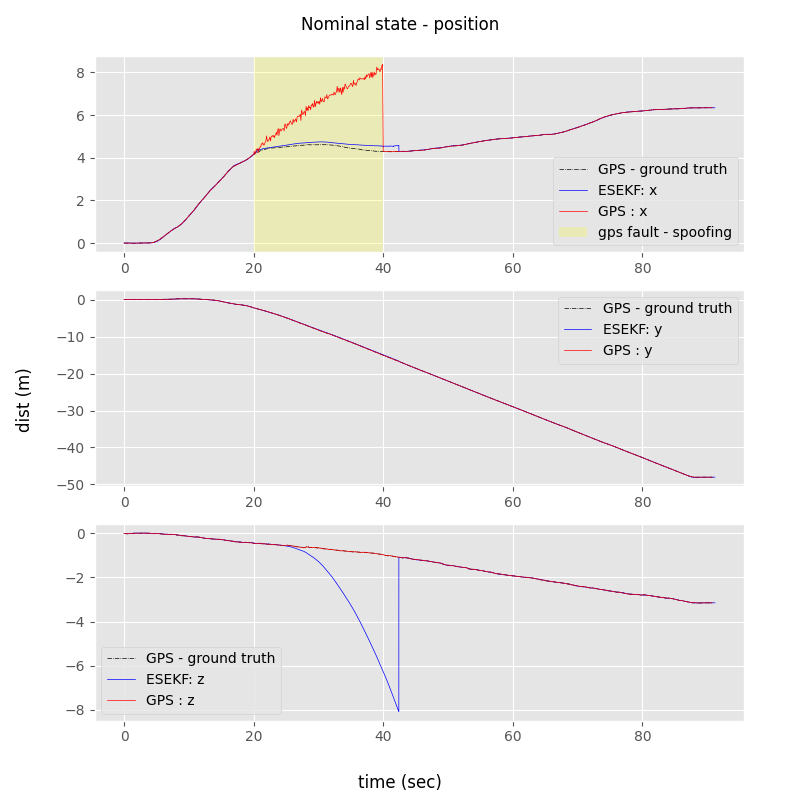

In [158]:
plt.rcParams["figure.figsize"] = (8,8)
vis_p(t_list, x_list, t_gps, p_gps, lab, gt_gps)

### Velocity

In [ ]:
vis_v(t_list, x_list, t_gps, v_gps, t_radar, v_ro_list, t_ro_list)

In [ ]:
vis_pol_v(t_list, x_list, t_gps, v_gps, v_ro_list, t_ro_list)

## Biases

In [ ]:
vis_ab(t_list, x_list, ab_imu)

In [ ]:
vis_wb(t_list, x_list, wb_imu)

## Gravity

In [ ]:
vis_g(t_list, x_list)

## Trajectory

<IPython.core.display.Javascript object>


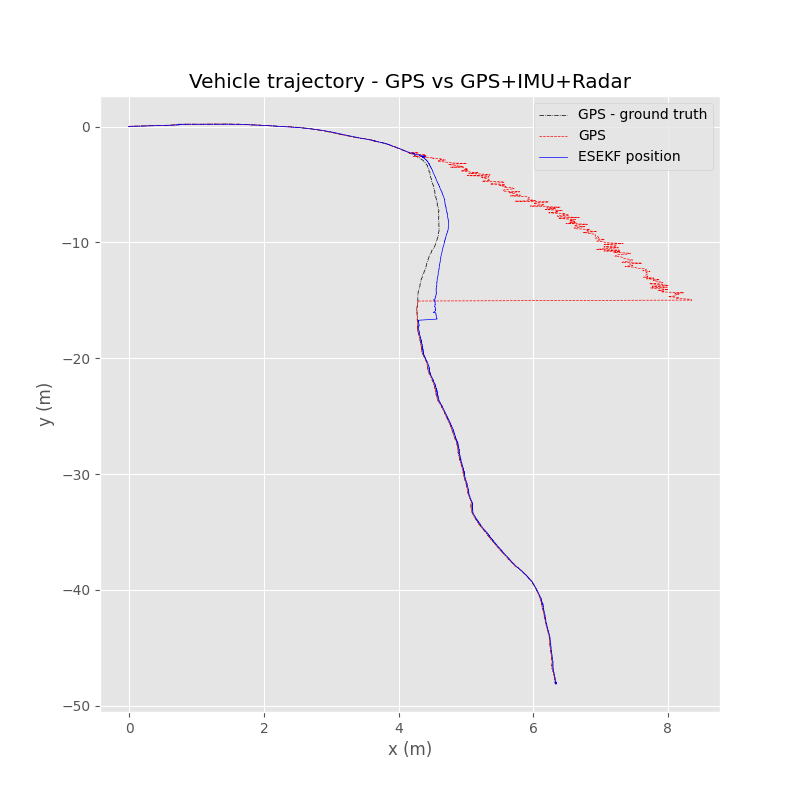

In [160]:
plt.rcParams["figure.figsize"] = (8,8)
vis_traj_2d(x_list, p_gps, gt_gps)

In [ ]:
# vis_traj_3d(x_list, p_gps)

# The End